# <font color = 'orange'> Count Repetations

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

In [2]:
pd.options.mode.chained_assignment = None

# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

---

### Load data

In [3]:
df = pd.read_pickle('../../data/interim/01_processed_data.pkl')
df = df[df['label']!='rest']

df['acc_r'] = np.sqrt(df['acc_x'] ** 2 + df['acc_y'] ** 2 + df['acc_z'] ** 2)
df['gyr_r'] = np.sqrt(df['gyr_x'] ** 2 + df['gyr_y'] ** 2 + df['gyr_z'] ** 2)

In [5]:
df

acc_x     acc_y     acc_z   gyr_x   gyr_y   gyr_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set     acc_r     gyr_r  
epoch (ms)                                                                    
2019-01-11 15:08:05.200           B  bench    heavy   30  0.979669  3.225625  
2019-01-11 15:08:05.400           B  bench    heavy   30  0.973752  2.887270  
2019-01-11 15:08:05.600           B  bench    heavy   30  0.973795  2.936720  
2019-01-11 15:08:05.800           B  bench    heavy   30  0.960118  9.473502  
2019-01-11 15:08:06.000           B  bench    heavy   30  0.964953  4.623585  
...                             ...    ...      ...  ...       ...       ...  
2019-01-20 17:33:27.000           E    row   medium   90  1.045408  5.804424  
2019-01-20 17:33:27.200           E    row   medium   90  1.032376  3.611408  
2019-01-20 17:33:27.400           E    row   medium   90  1.035995  5.869377  
2019-01-20 17:33:27.600           E    row   medium   90  1.027367  1.173990  
2019-01-20 17:33:27.800           E    row   medium   90  1.036616  4.283778  

[7899 rows x 12 columns]

---

### Split data

In [6]:
bench_df = df[df['label'] == 'bench']
ohp_df = df[df['label'] == 'ohp']
squat_df = df[df['label'] == 'squat']
dead_df = df[df['label'] == 'dead']
row_df = df[df['label'] == 'row']

---

### Visualize data to identify patterns

<AxesSubplot: xlabel='epoch (ms)'>

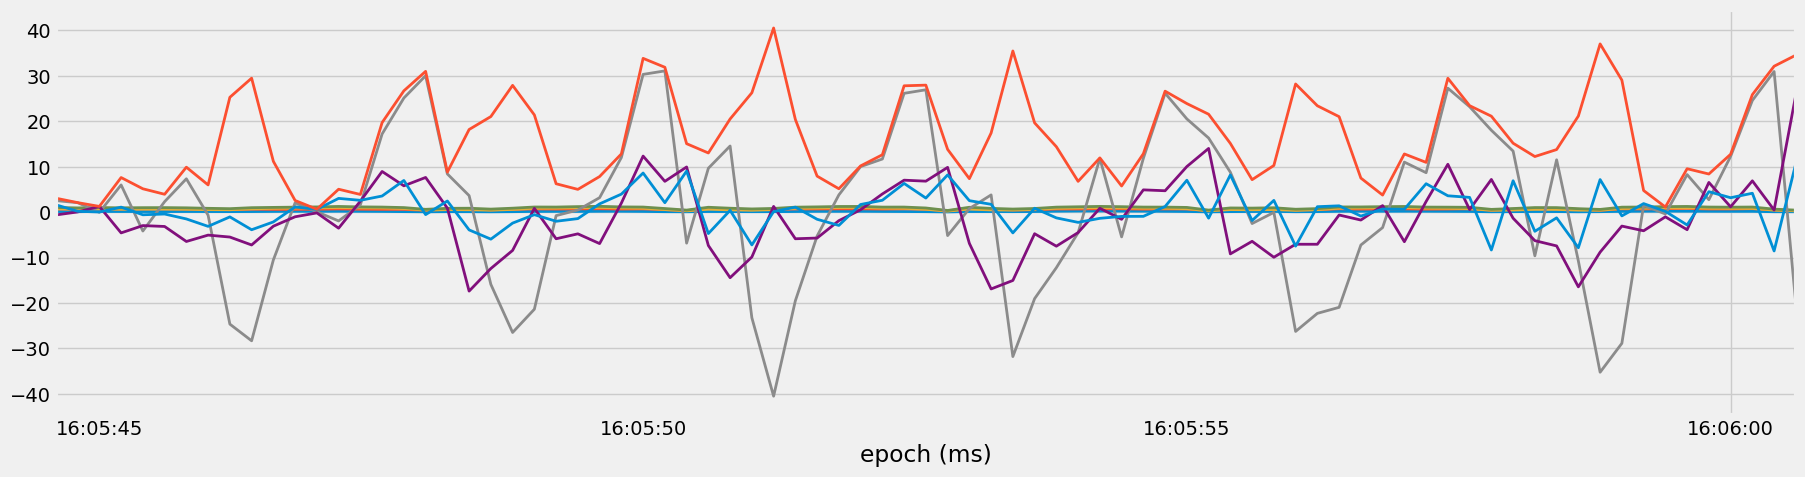

In [10]:
plot_df = squat_df

plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_x'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_y'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_z'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['acc_r'].plot()

plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_x'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_y'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_z'].plot()
plot_df[plot_df['set'] == plot_df['set'].unique()[0]]['gyr_r'].plot()

---

### Configure LowPassFilter

In [11]:
sf = (1000 / 200)
LowPass  = LowPassFilter()

---

### Apply and tweak LowPassFilter

In [12]:
# taking the first set of all the class of the label
bench_set  = bench_df[bench_df['set'] == bench_df['set'].unique()[0]]
ohp_set  = ohp_df[ohp_df['set'] == ohp_df['set'].unique()[0]]
squat_set  = squat_df[squat_df['set'] == squat_df['set'].unique()[0]]
dead_set  = dead_df[dead_df['set'] == dead_df['set'].unique()[0]]
row_set  = row_df[row_df['set'] == row_df['set'].unique()[0]]

<AxesSubplot: xlabel='epoch (ms)'>

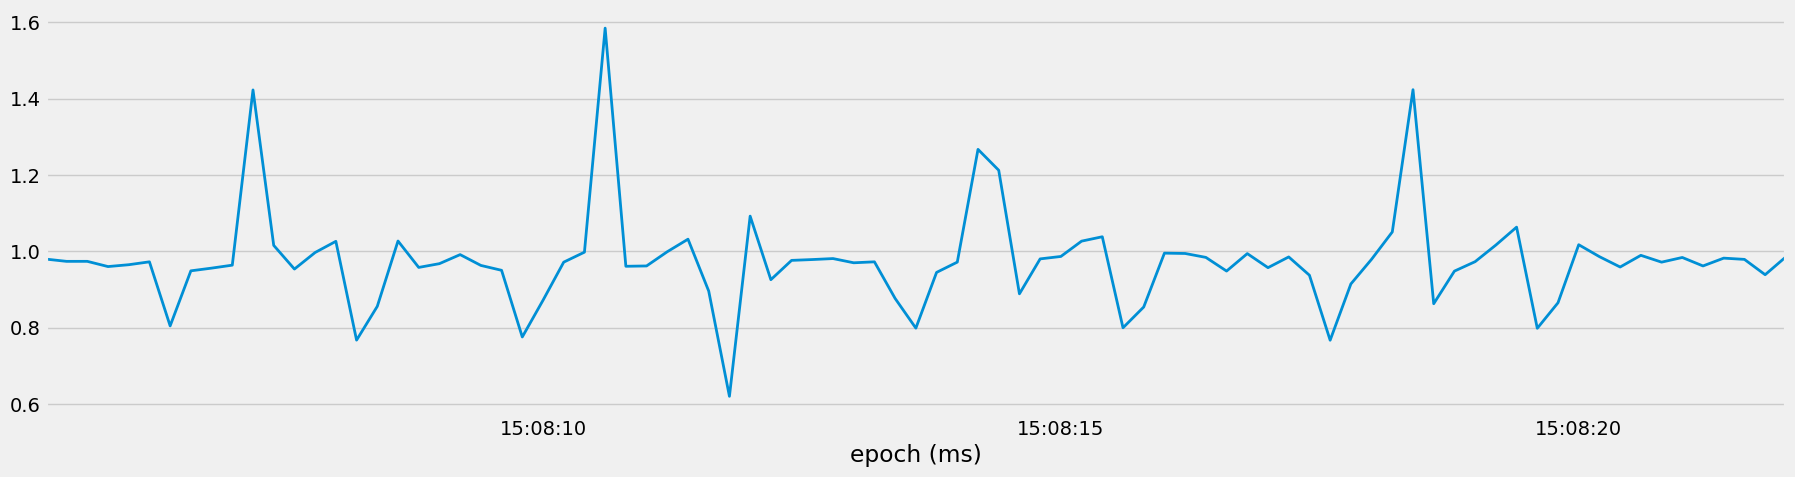

In [13]:
# let's visualize the set with some label with low pass filter and without it
bench_set['acc_r'].plot()

<AxesSubplot: xlabel='epoch (ms)'>

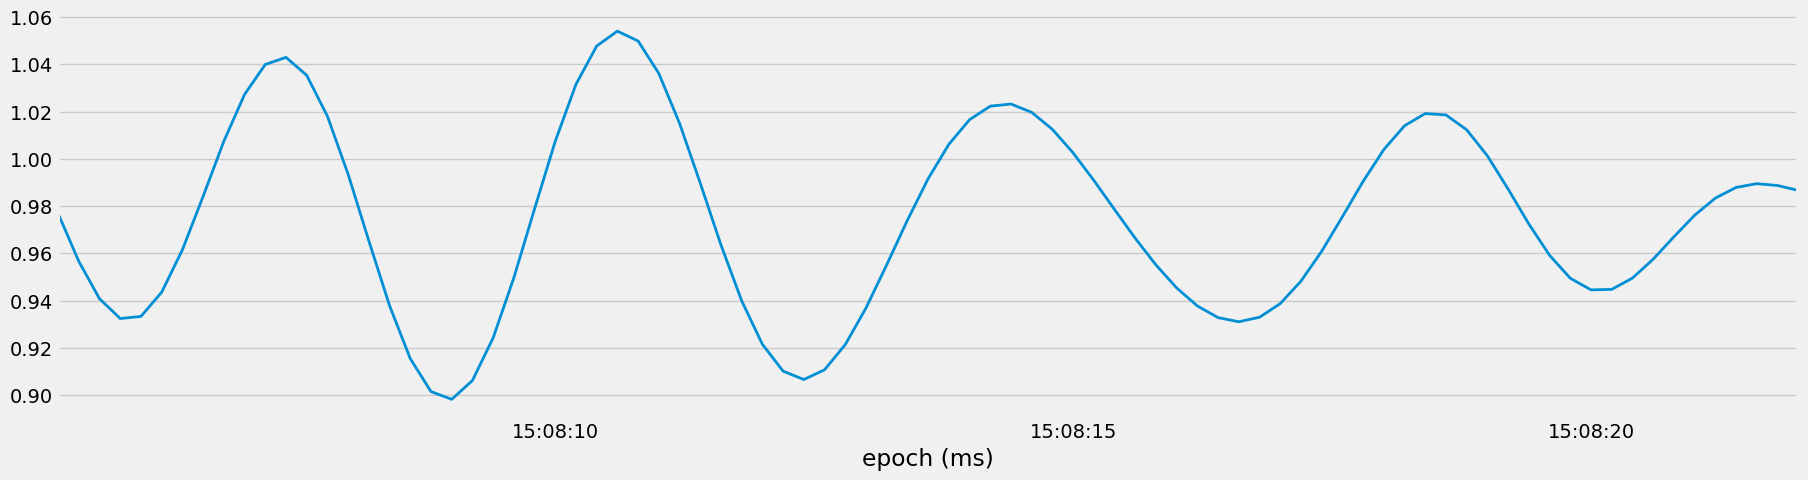

In [14]:
column = 'acc_r'
LowPass.low_pass_filter(
    bench_set, col = column, sampling_frequency = sf, cutoff_frequency = 0.4, order = 10
)[column + '_lowpass'].plot()


---

### Create function to count repetitions

In [32]:
import matplotlib.pyplot as plt

In [33]:
def count_repetations(dataset, column = 'acc_r', cutoff = 0.4, order = 10):
    data = LowPass.low_pass_filter(
        dataset, col = column, sampling_frequency = sf, cutoff_frequency = cutoff, order = order
    )
    indexes = argrelextrema(data[column + '_lowpass'].values, np.greater)
    peaks = data.iloc[indexes]
    
    # let's visualize the count
    # fig, ax = plt.subplots()
    plt.plot(dataset[column + '_lowpass'])
    plt.plot(peaks[column + '_lowpass'], 'o', color = 'red')
    # ax.set_ylabel(column + '_lowpass')
    exercise = dataset['label'].iloc[0].title()
    category = dataset['category'].iloc[0].title()
    plt.title(f'{category} {exercise}: {len(peaks)} Reps')
    plt.show()
    
    return len(peaks)

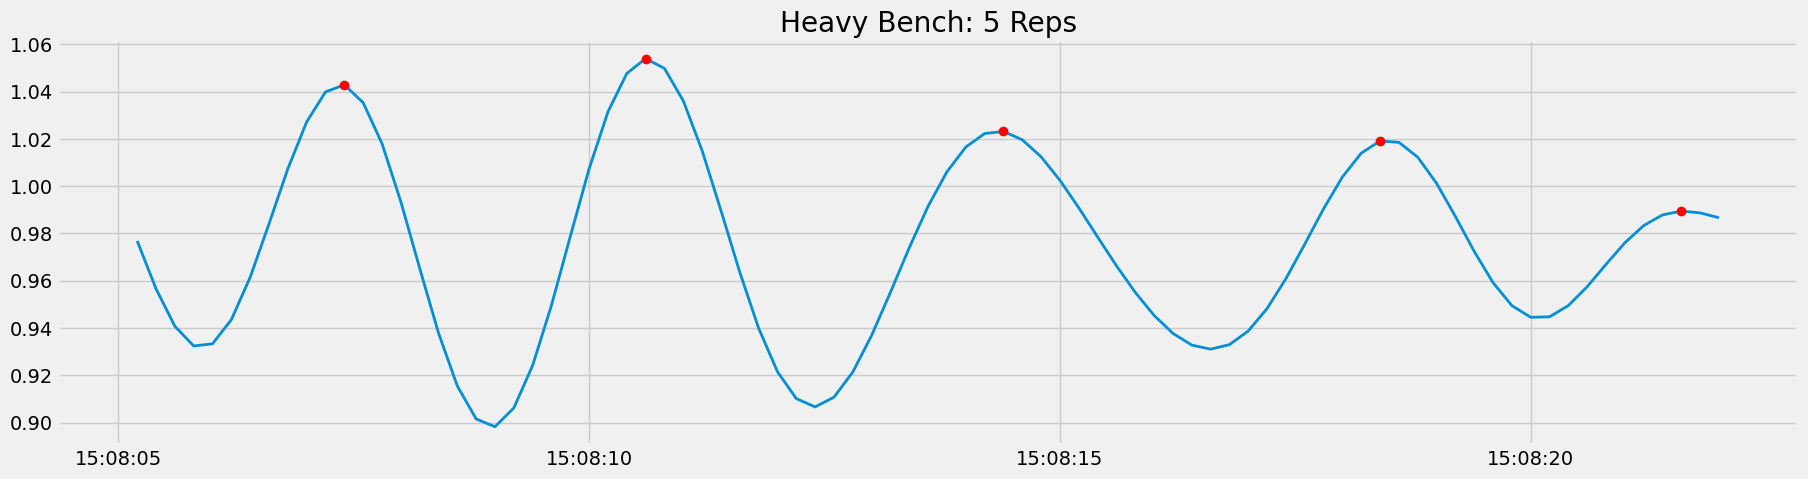

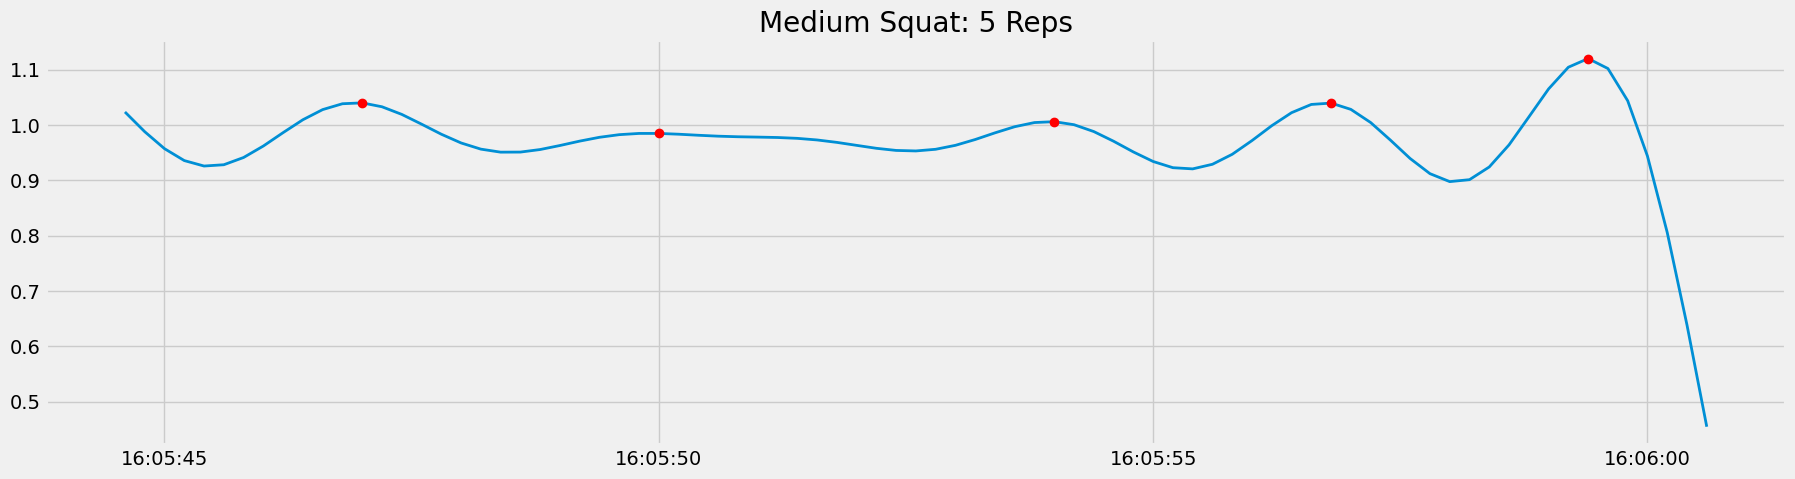

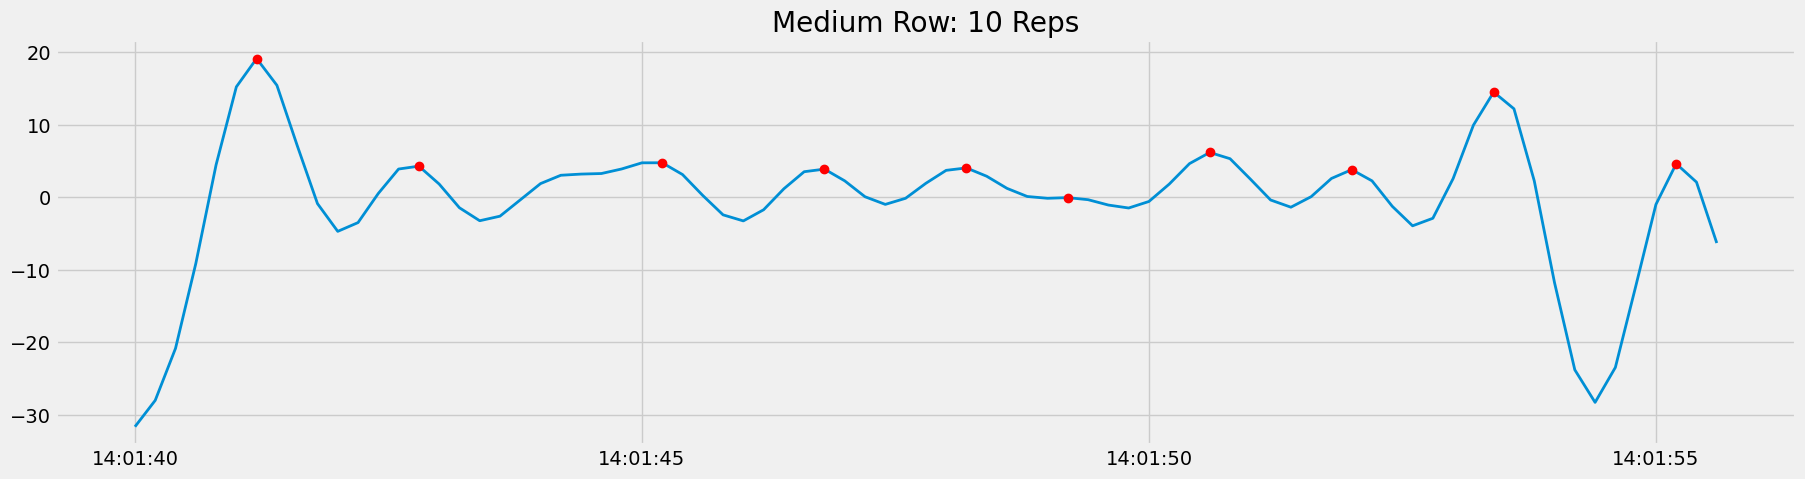

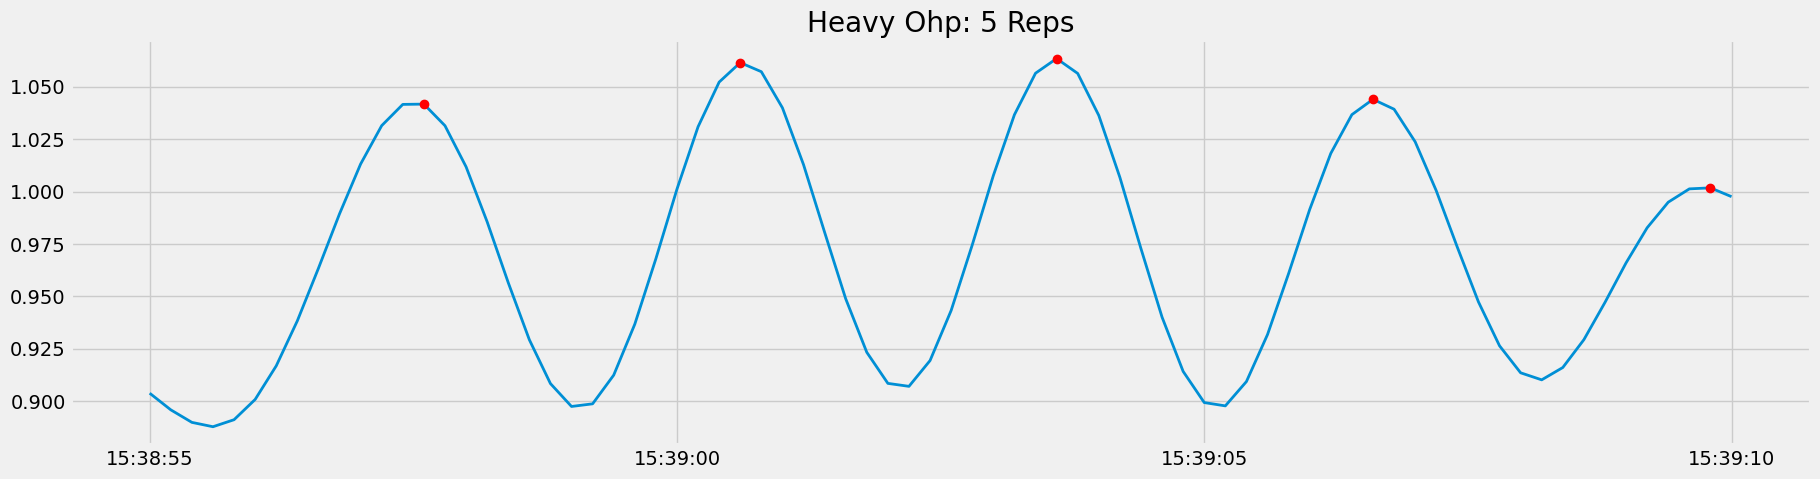

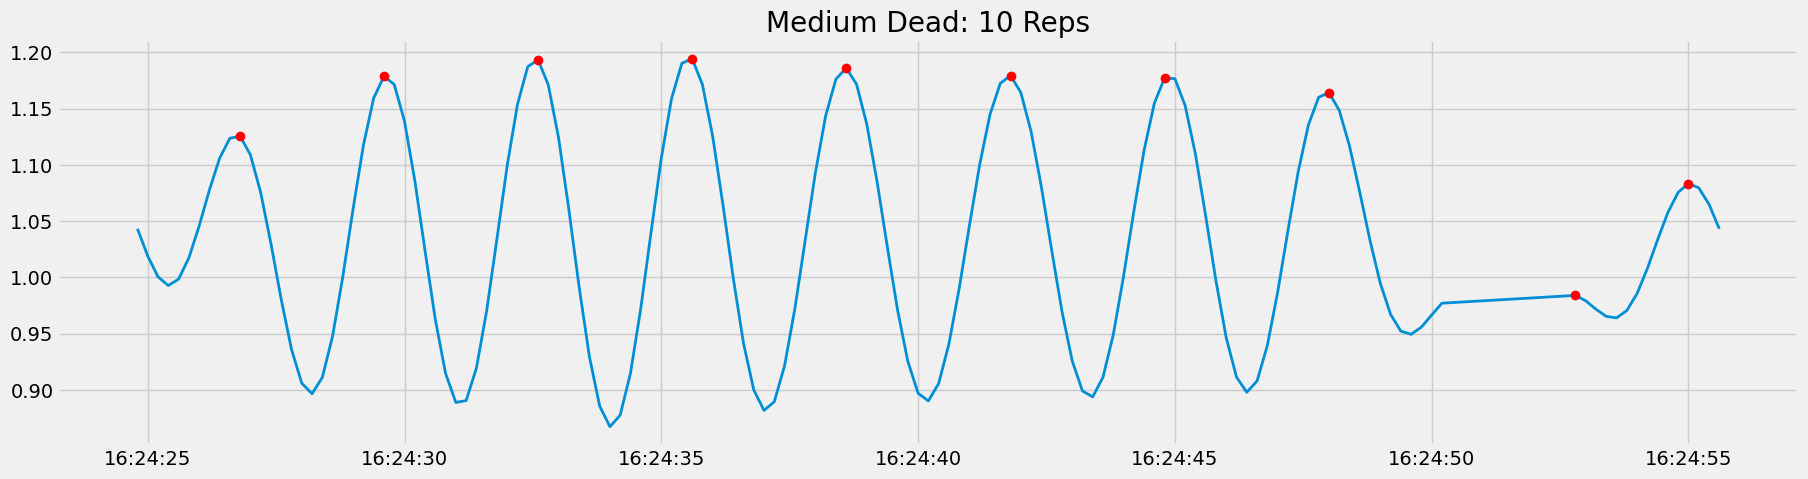

10

In [35]:
# tweak the cutoff to get the proper output
count_repetations(bench_set, cutoff = 0.4)
count_repetations(squat_set, cutoff = 0.35)
count_repetations(row_set, cutoff = 0.65, column = 'gyr_x')
count_repetations(ohp_set, cutoff = 0.35)
count_repetations(dead_set, cutoff = 0.4)
# heavy should 5 and should be 10

---

### Create benchmark dataframe

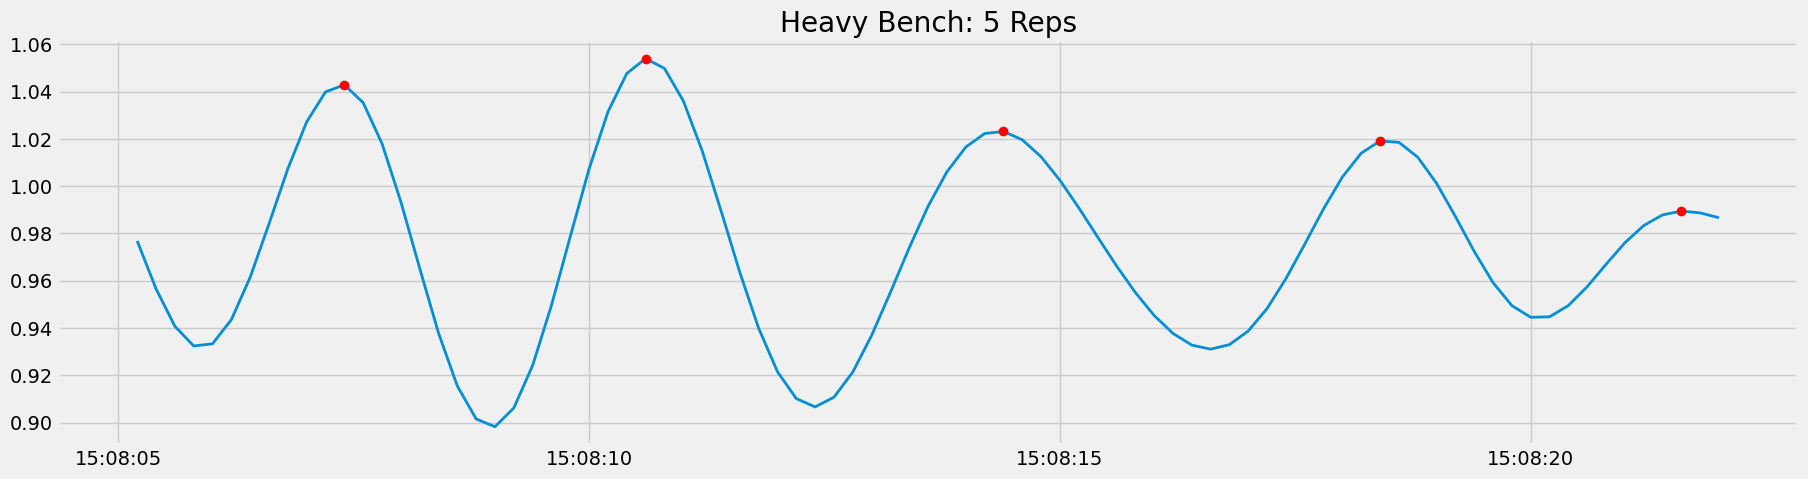

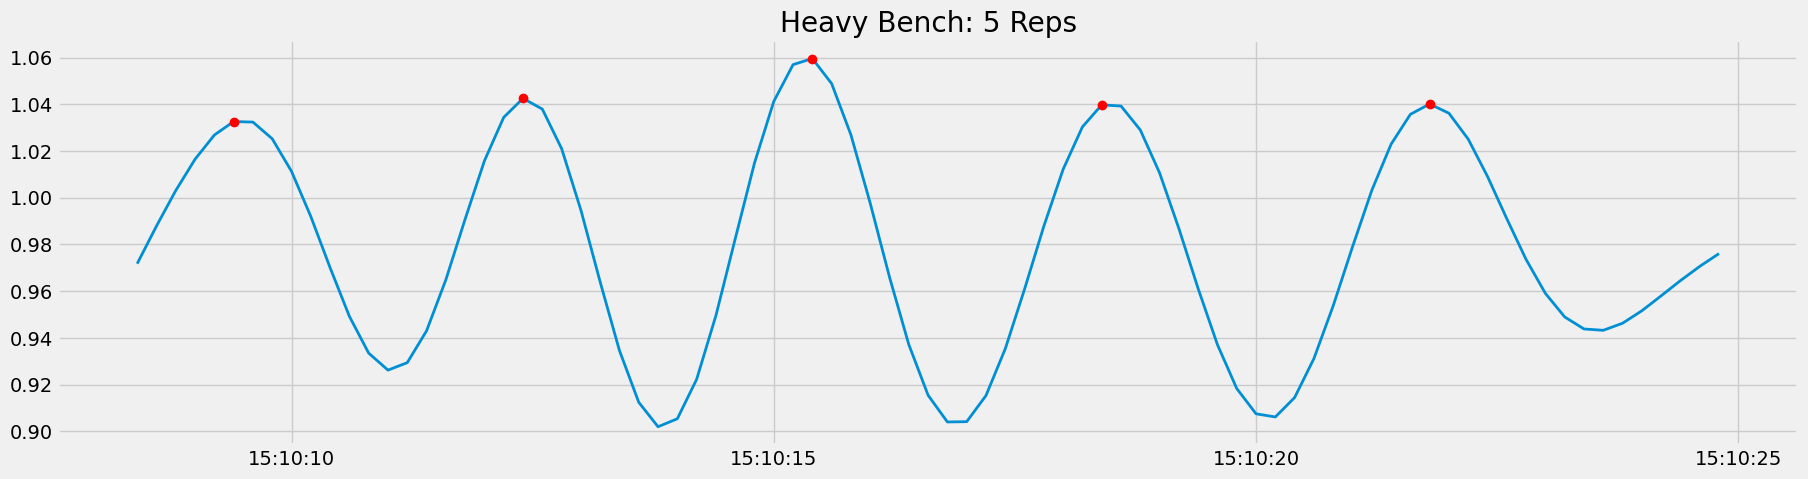

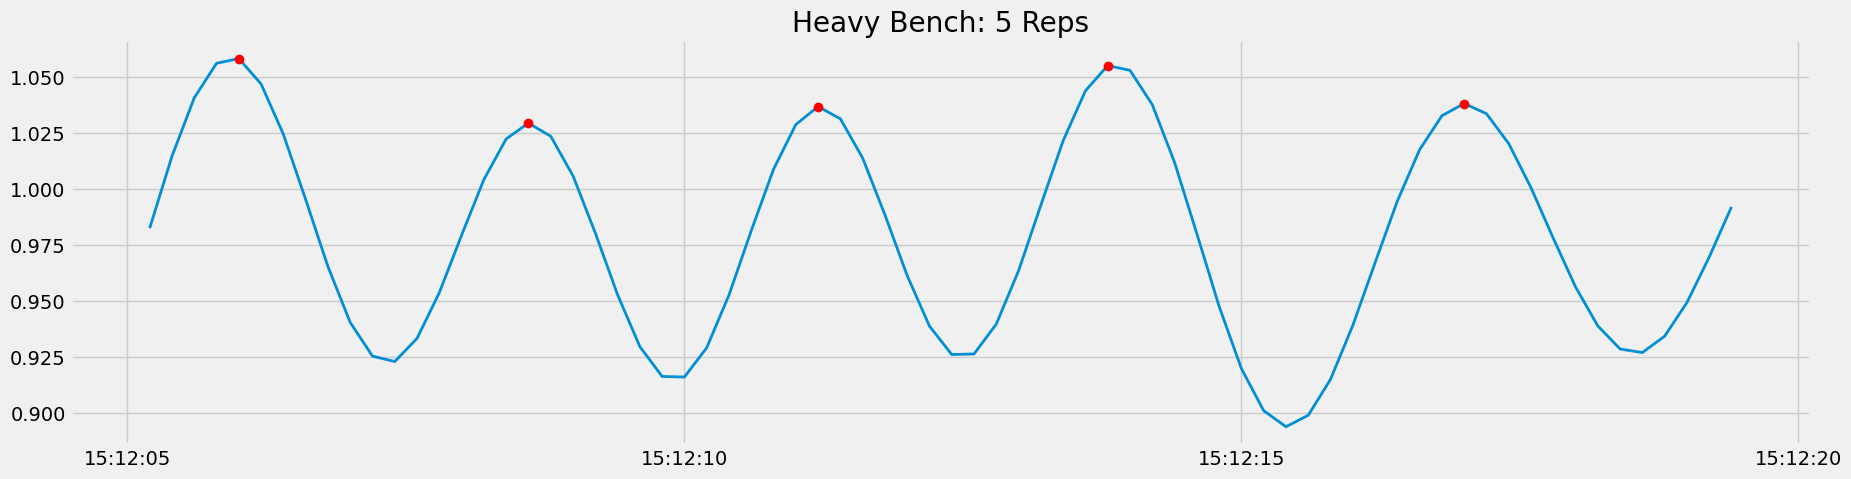

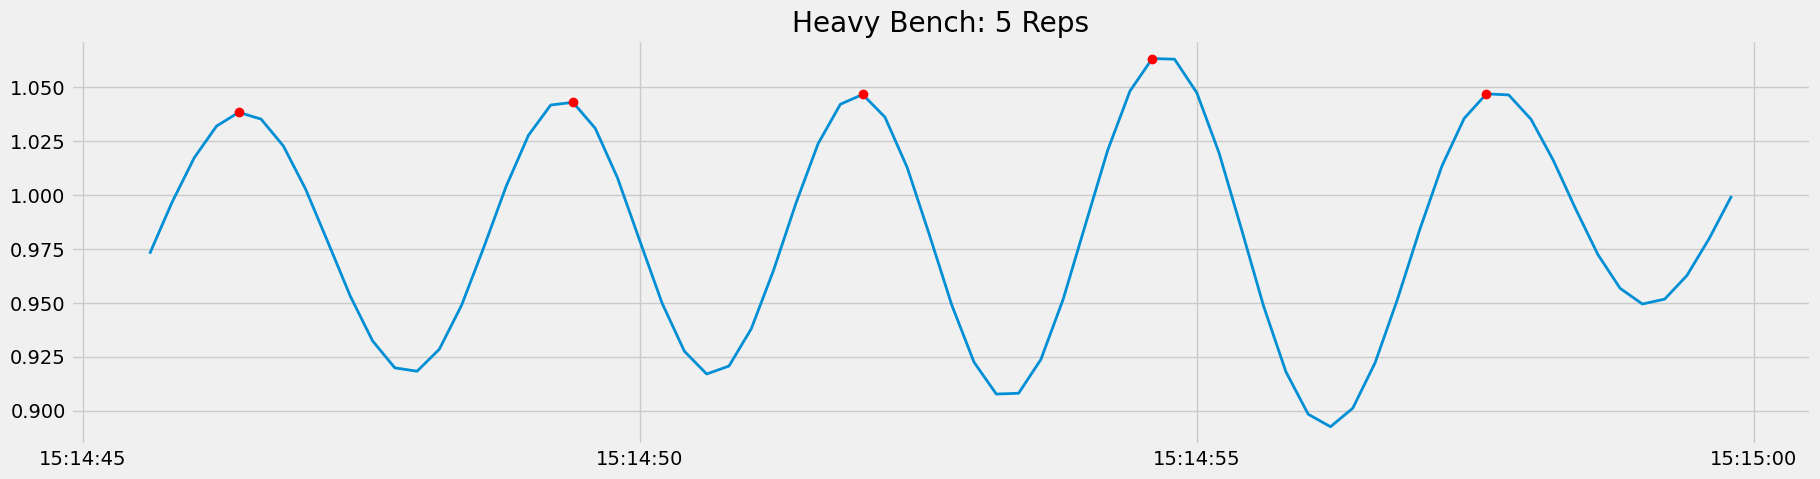

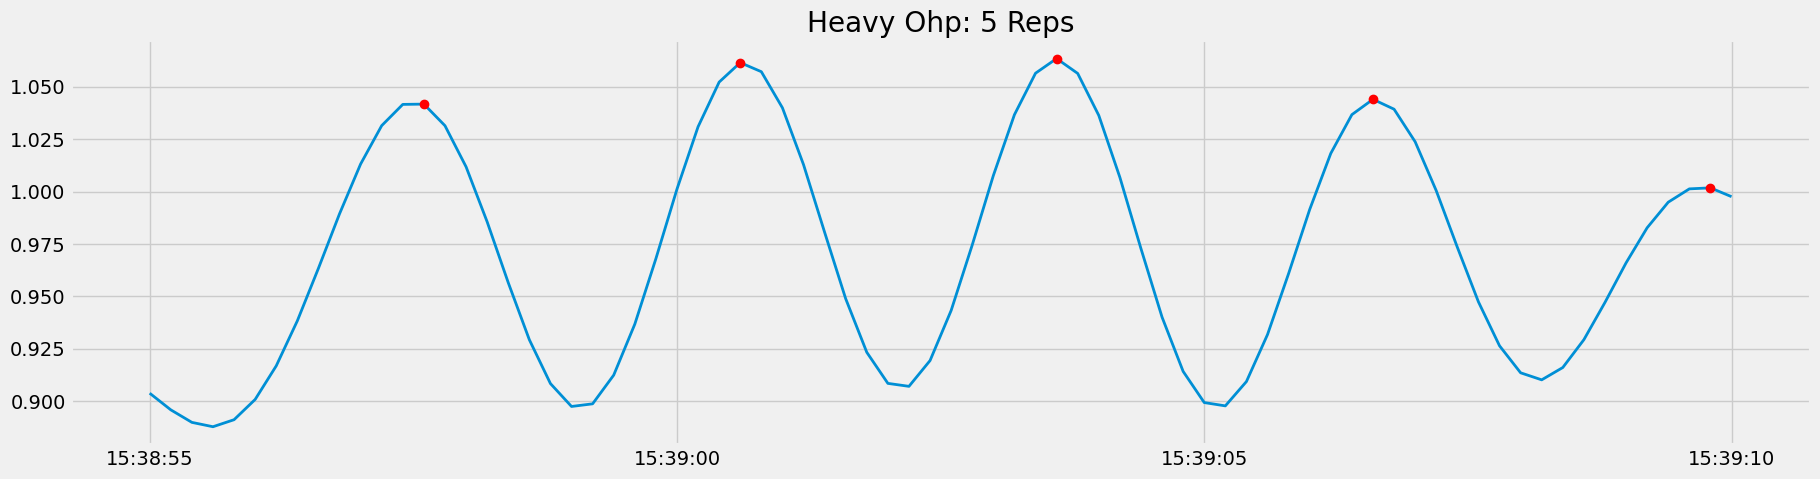

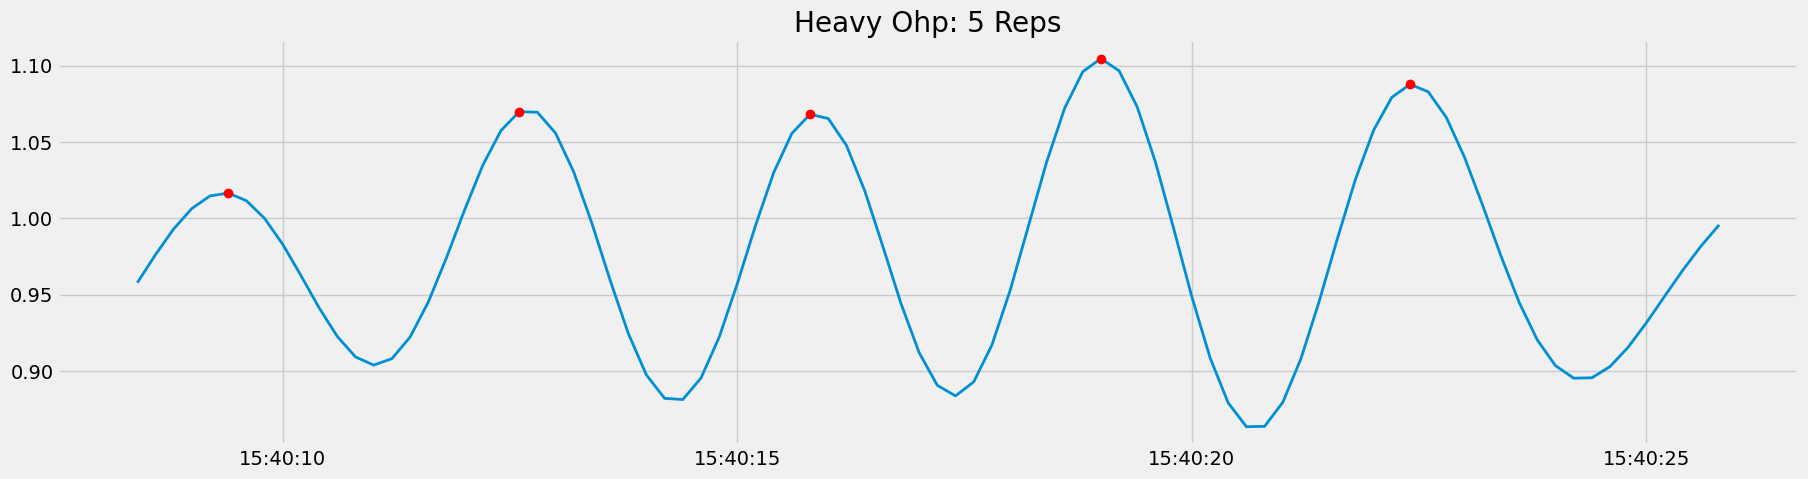

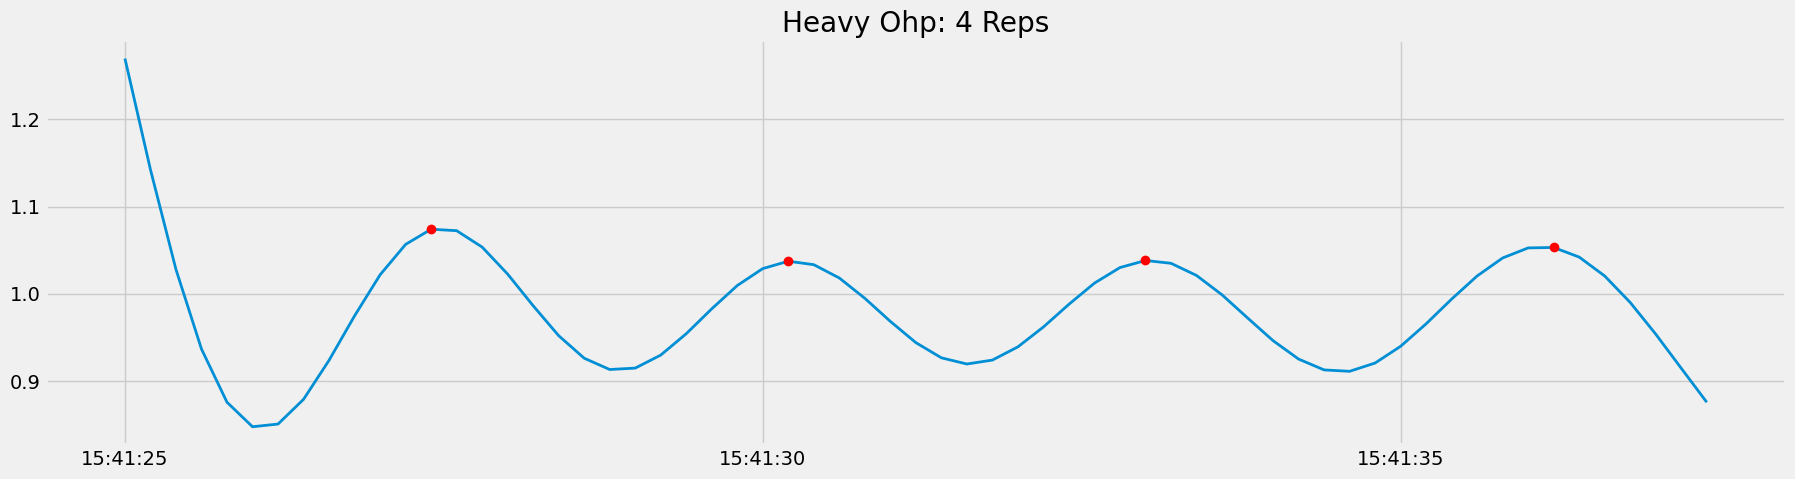

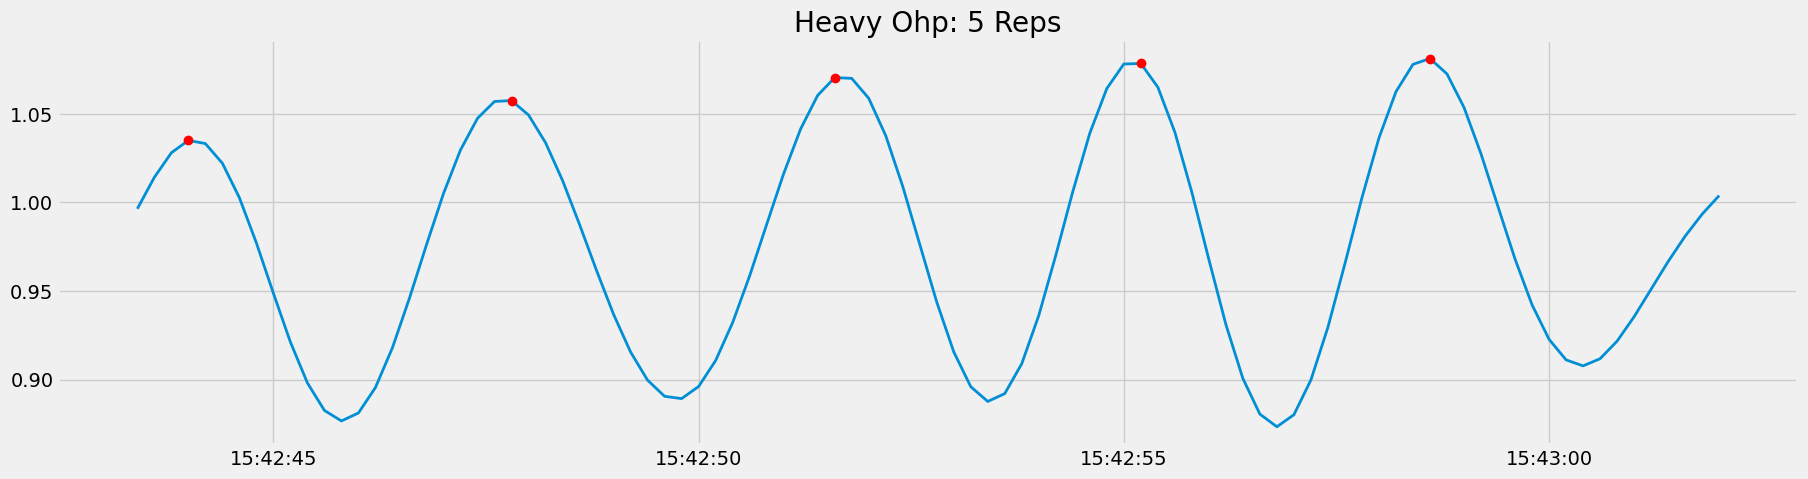

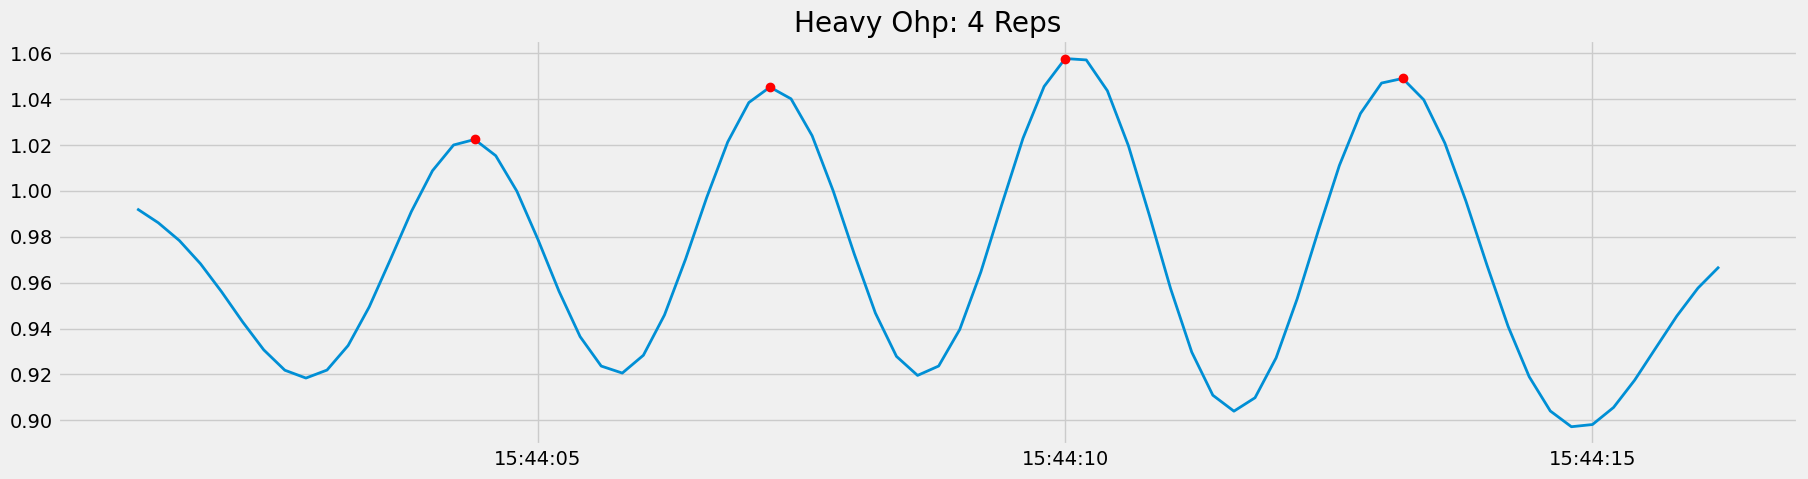

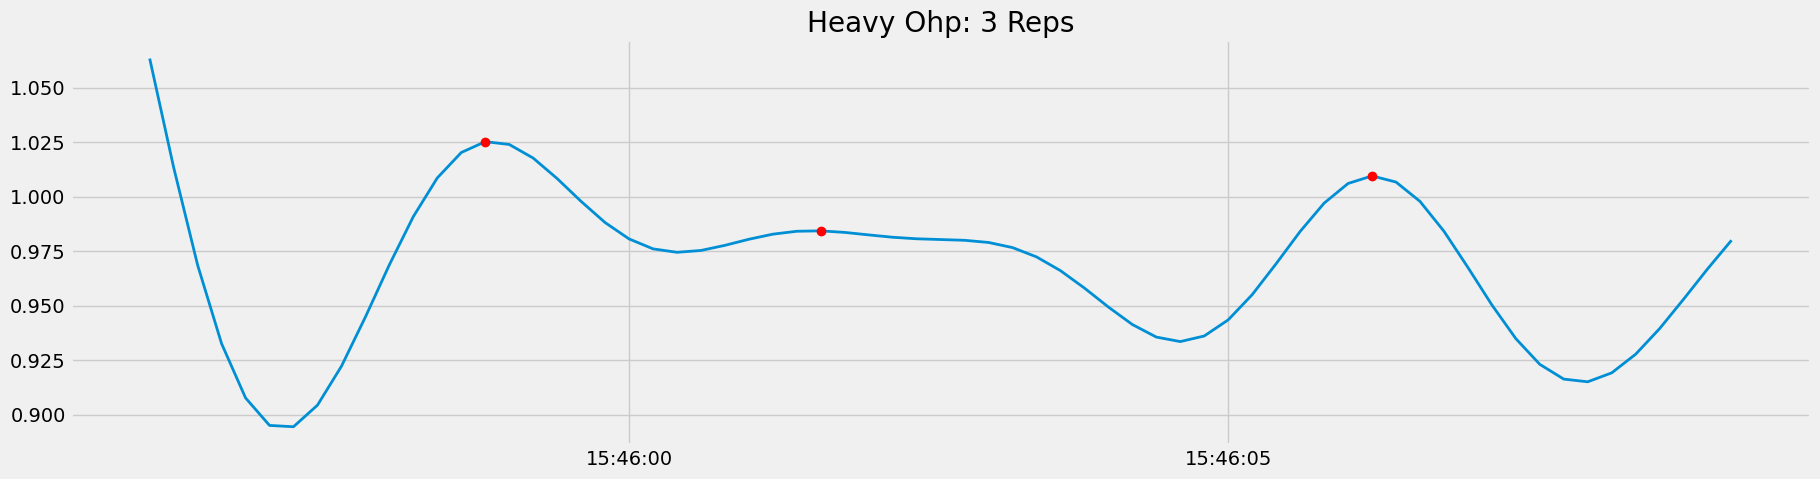

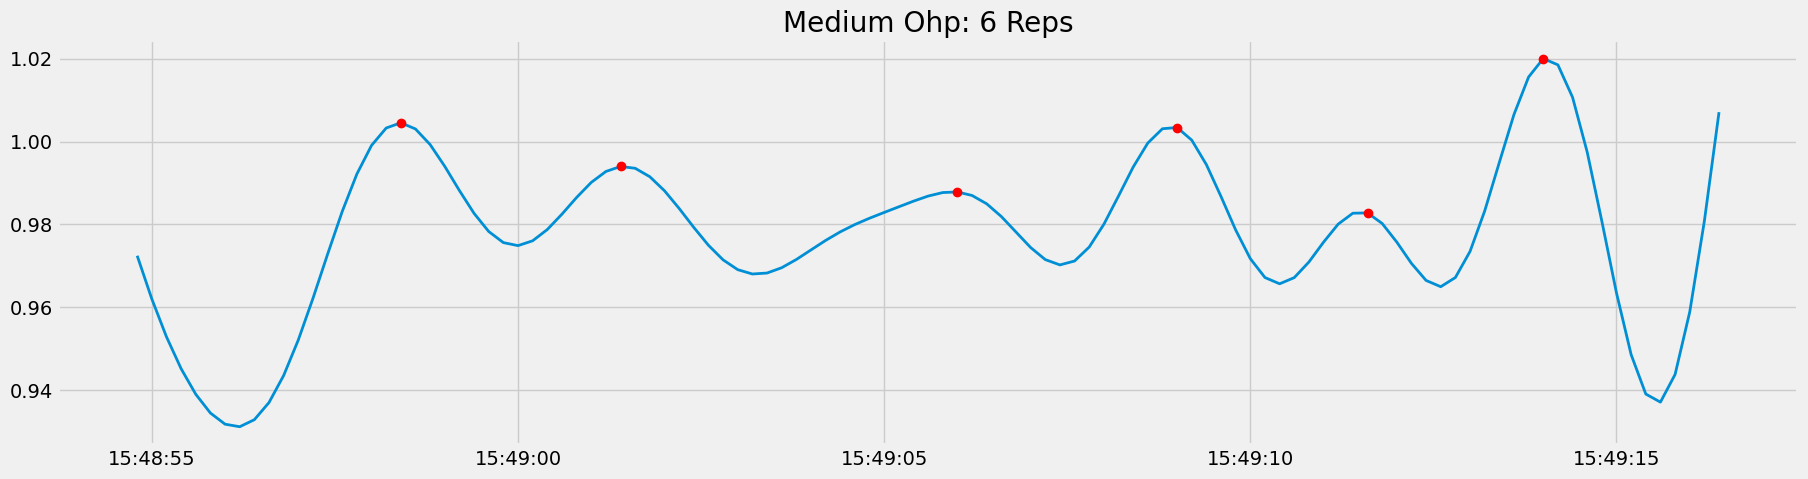

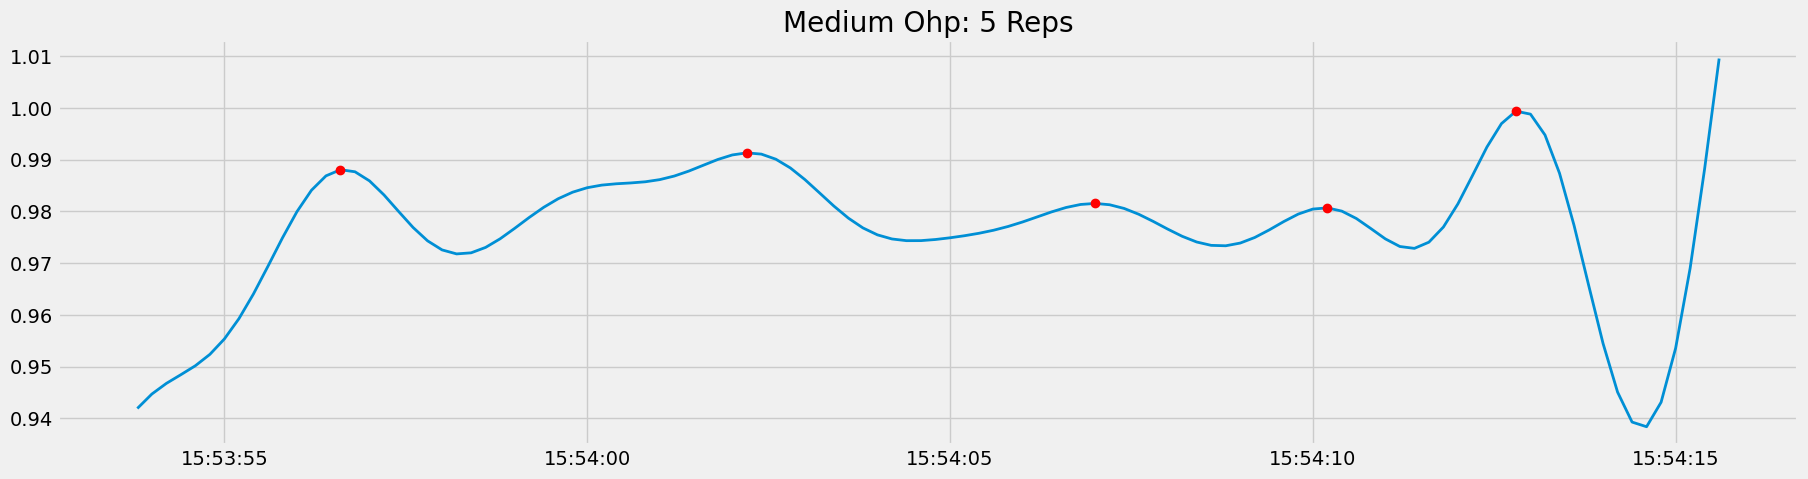

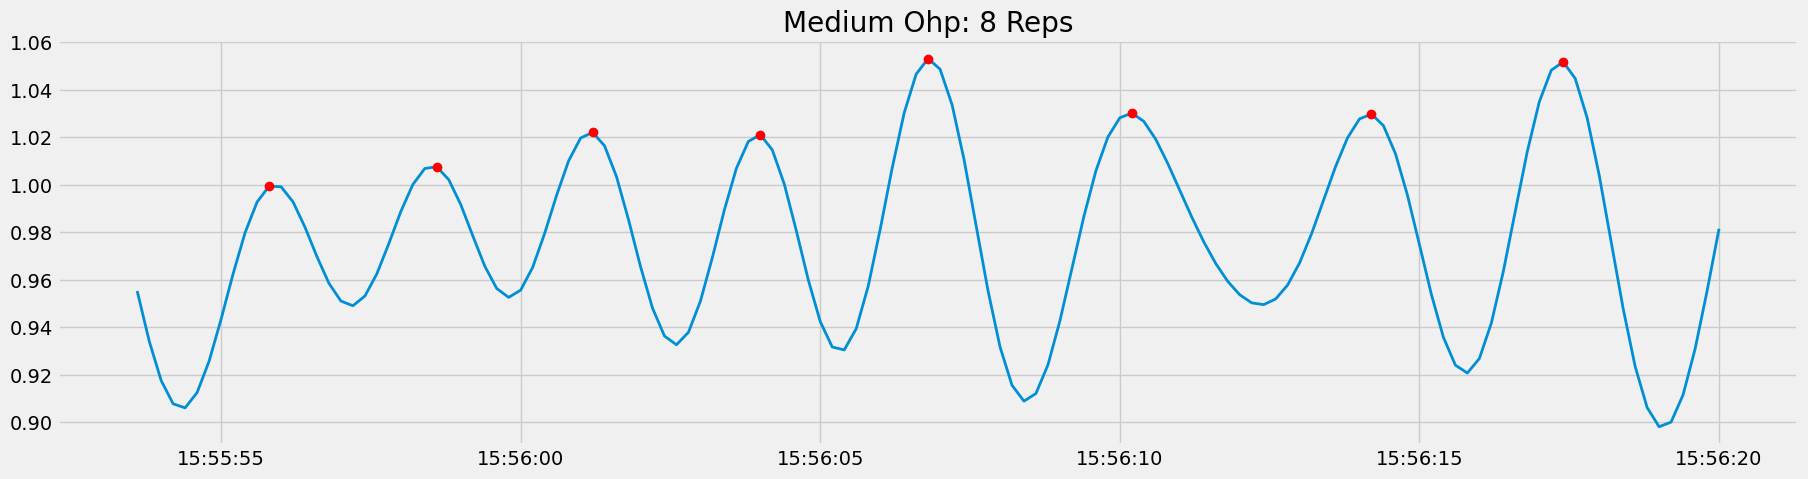

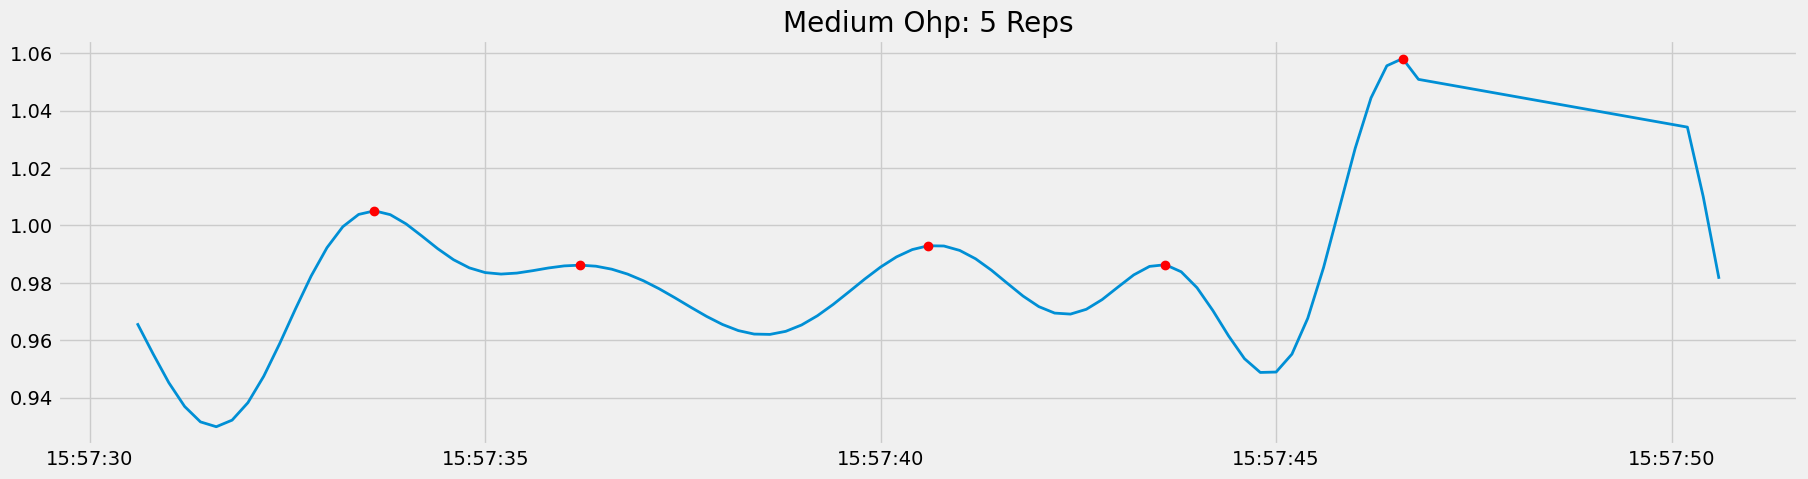

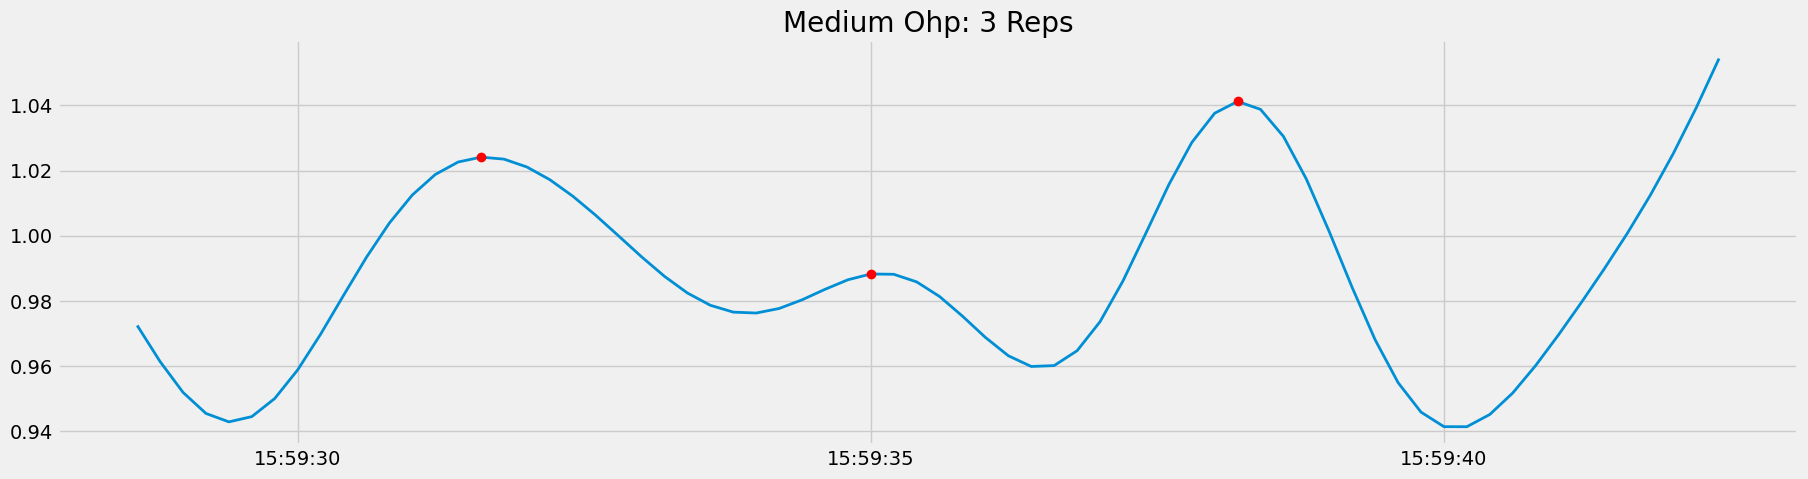

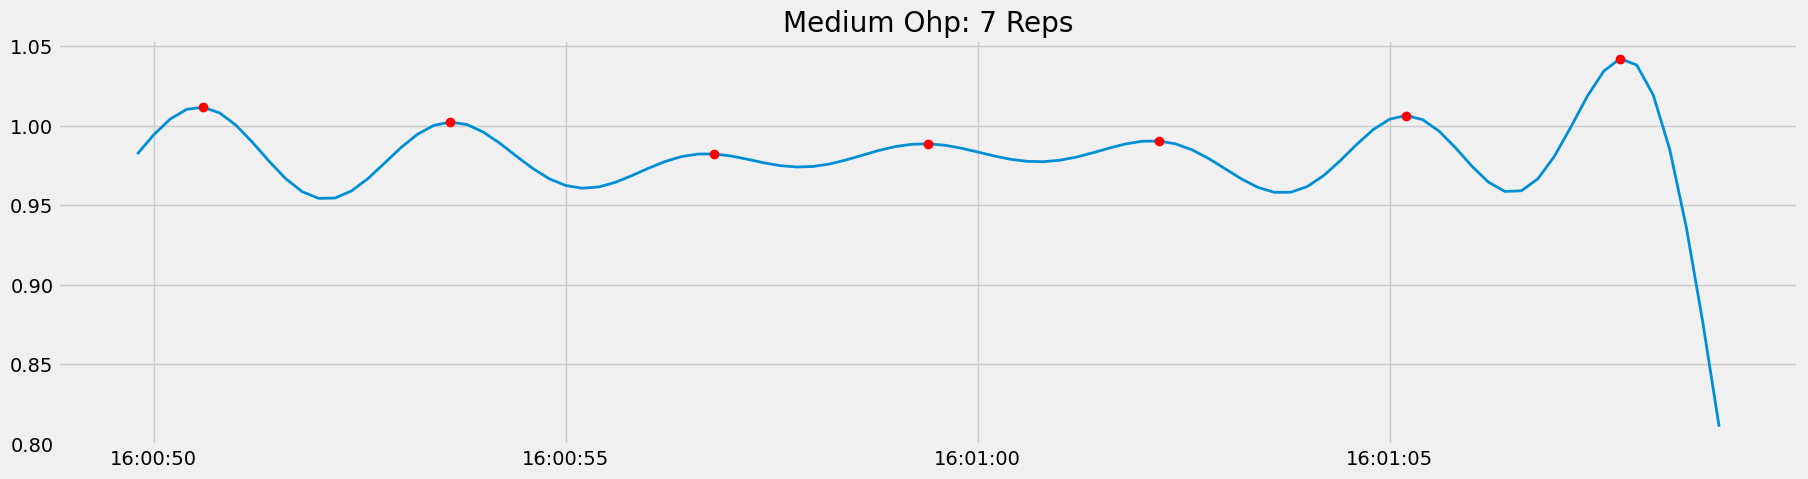

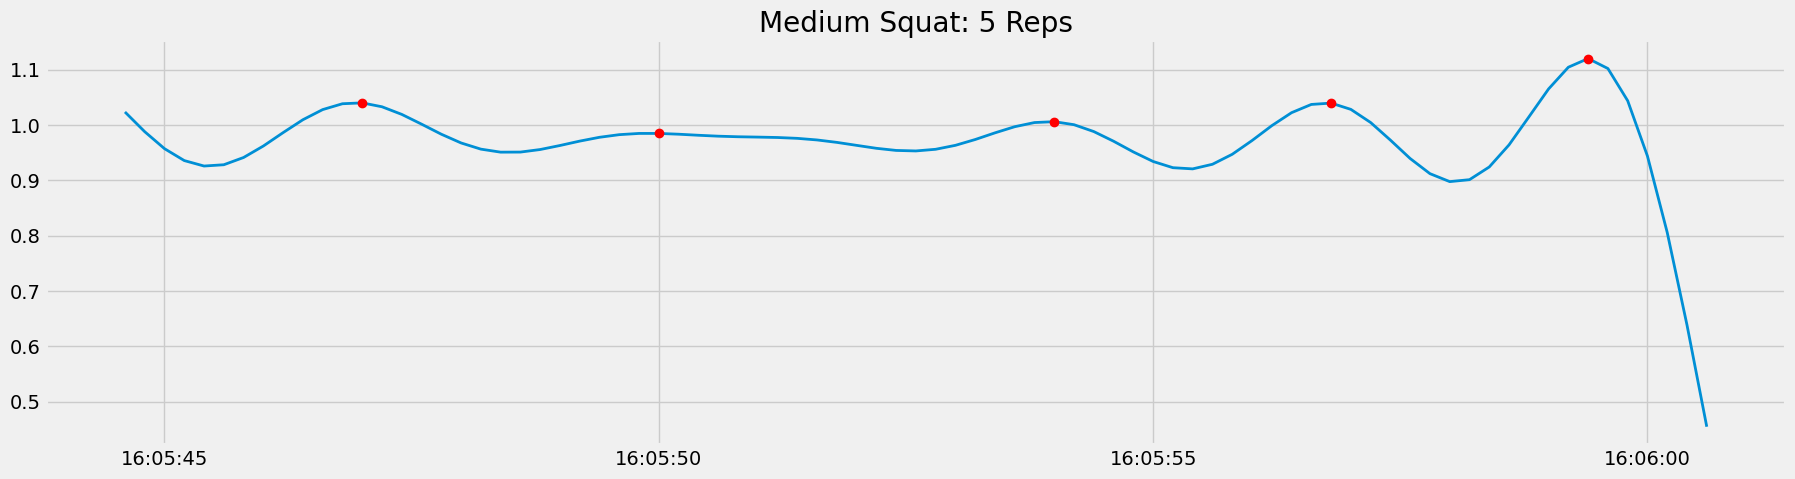

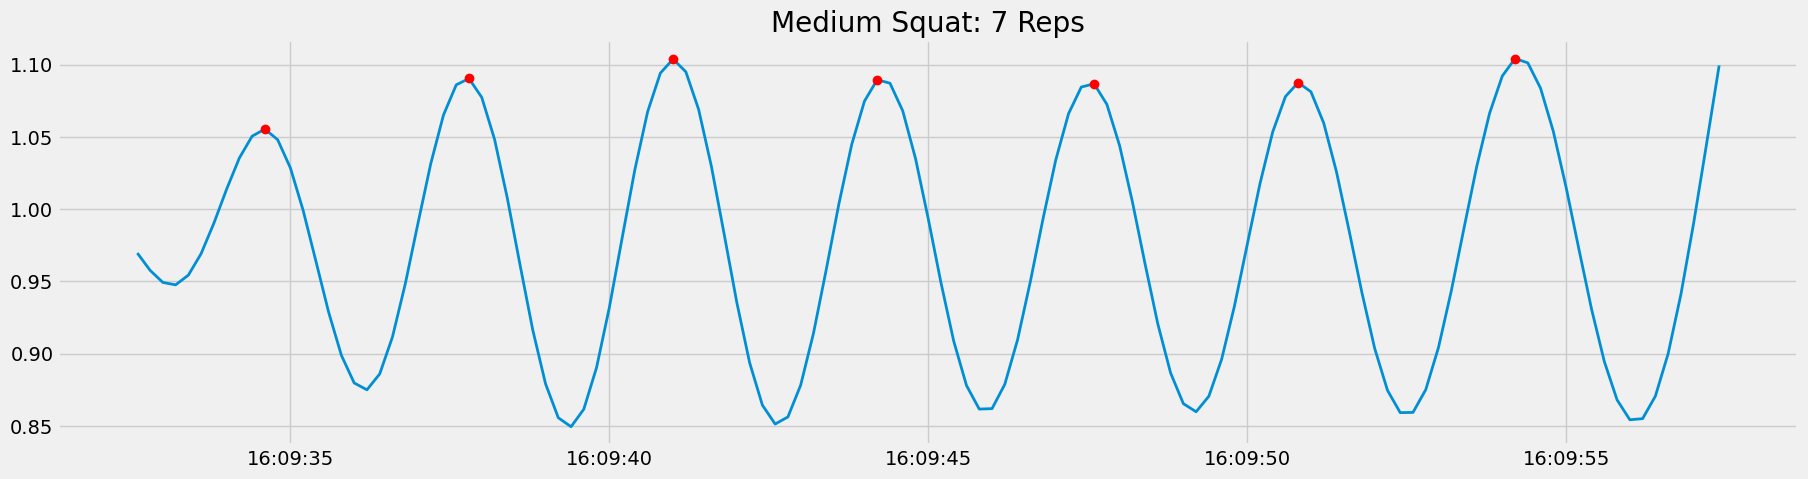

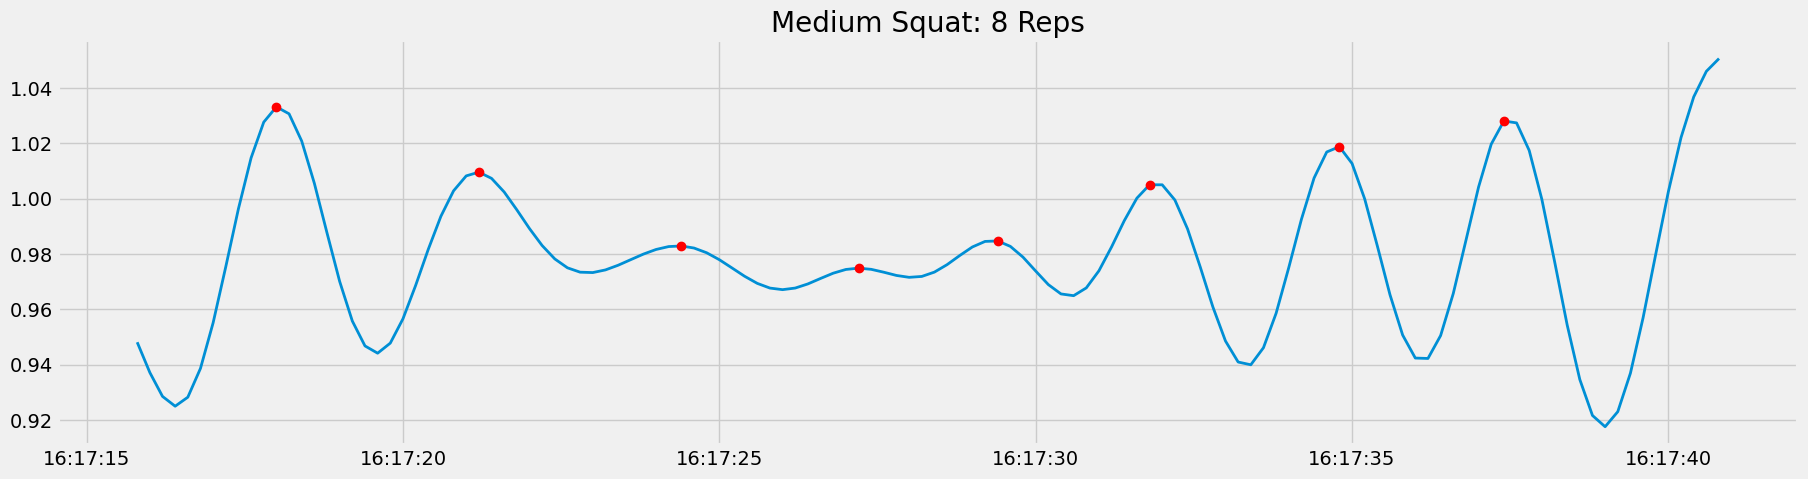

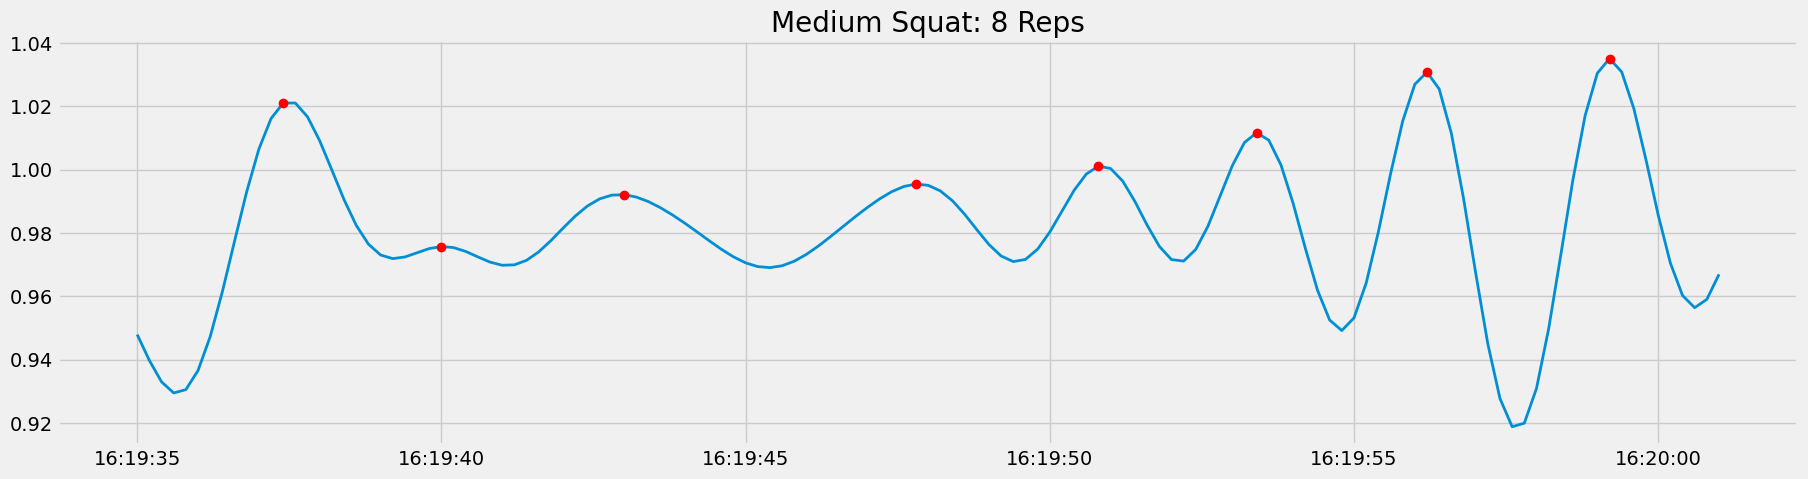

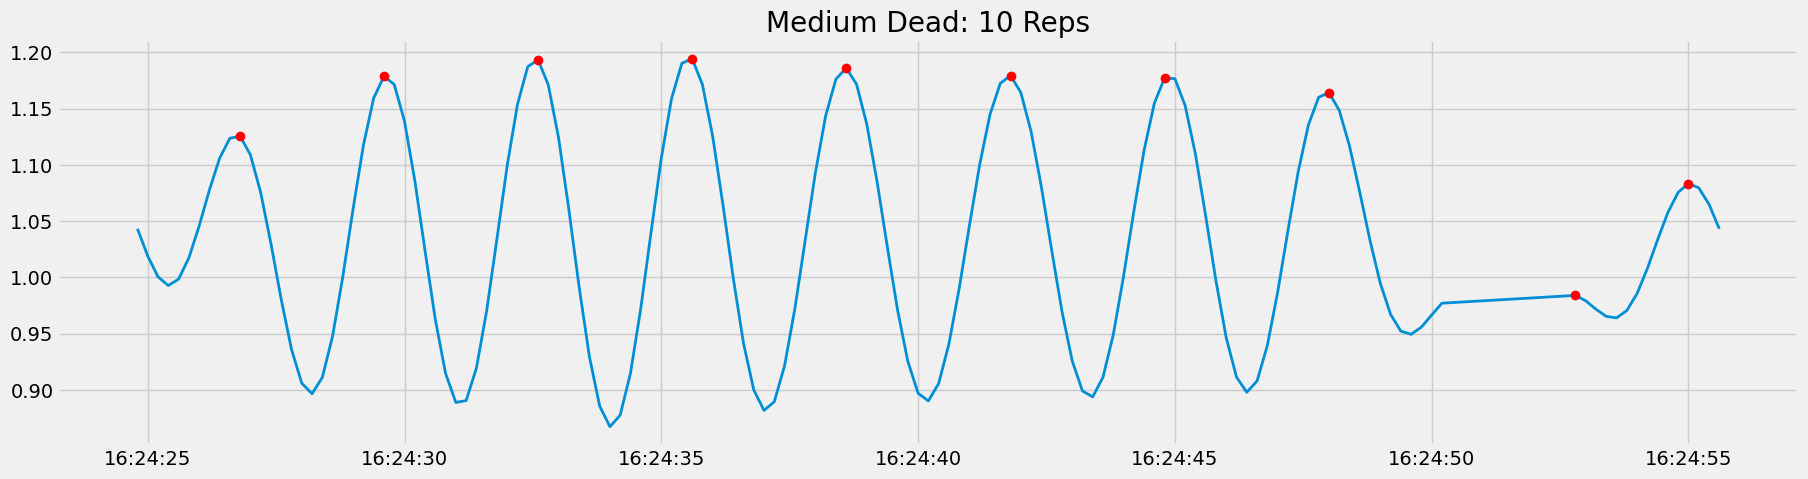

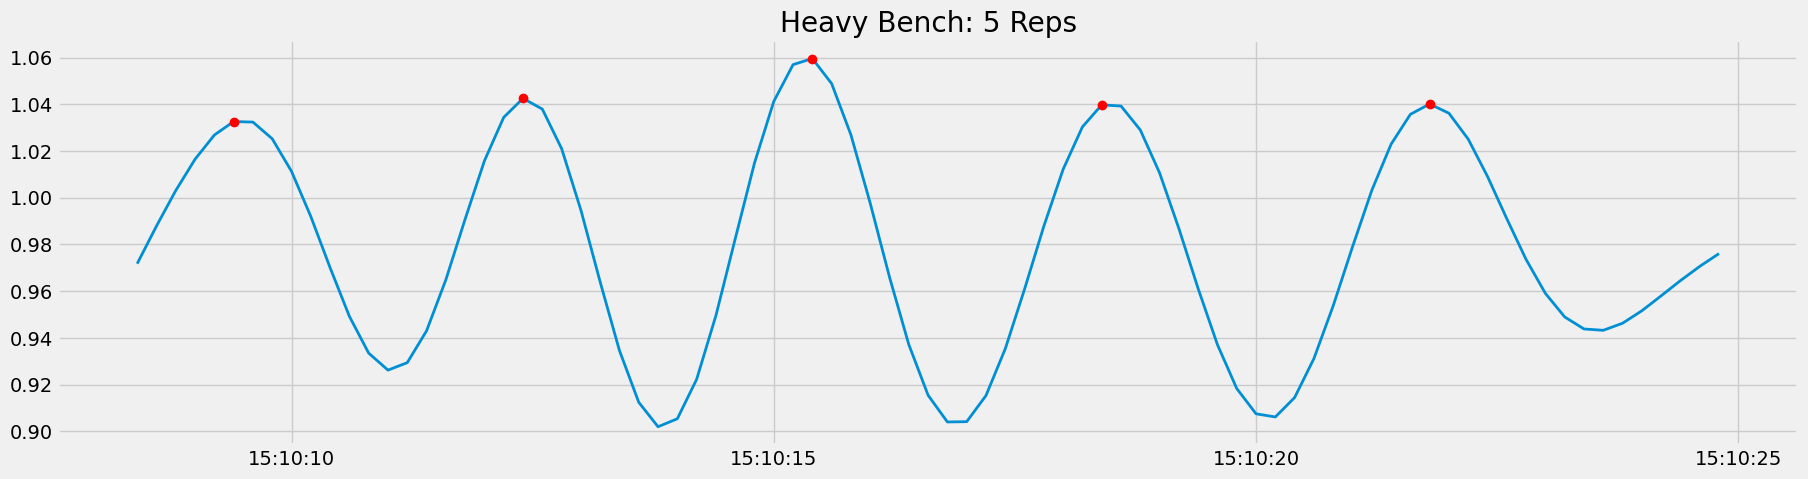

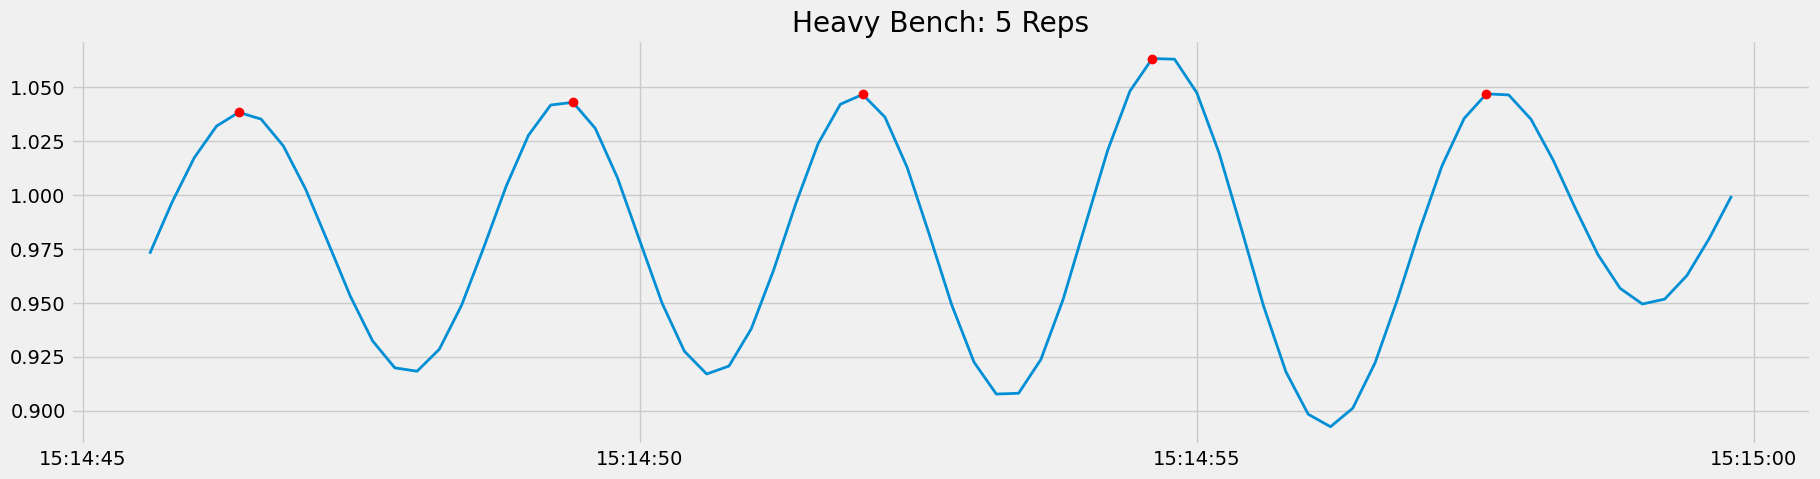

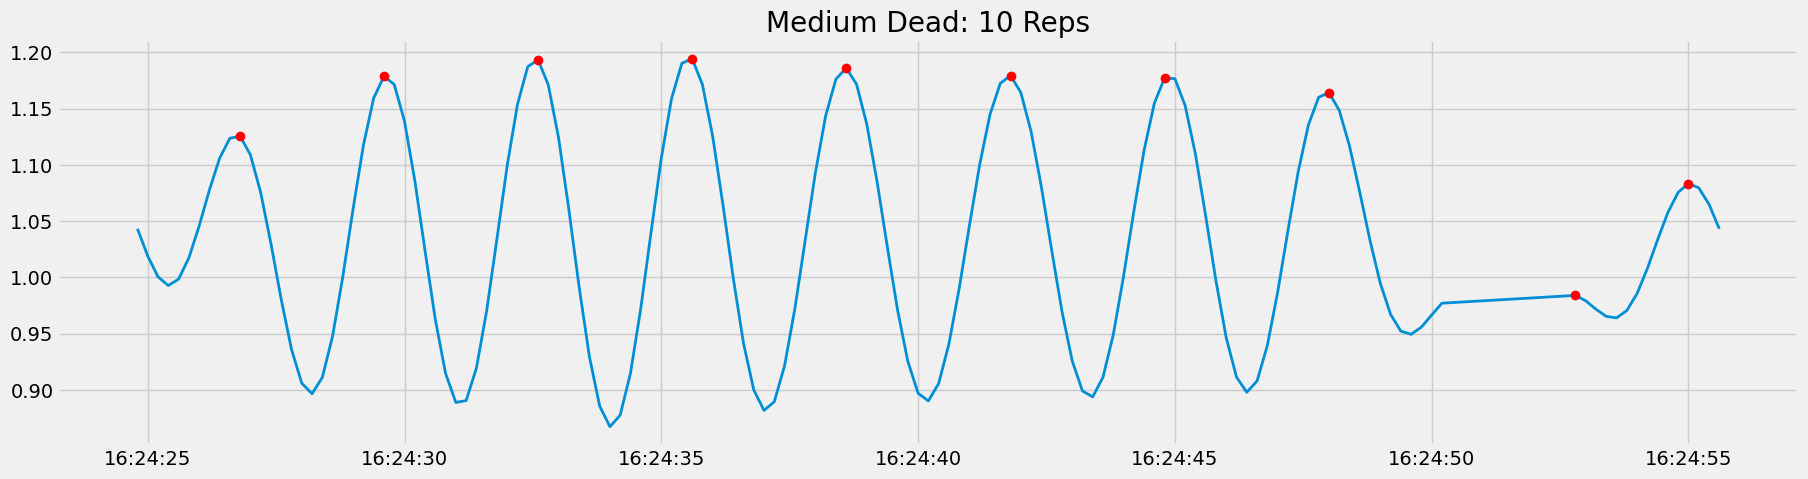

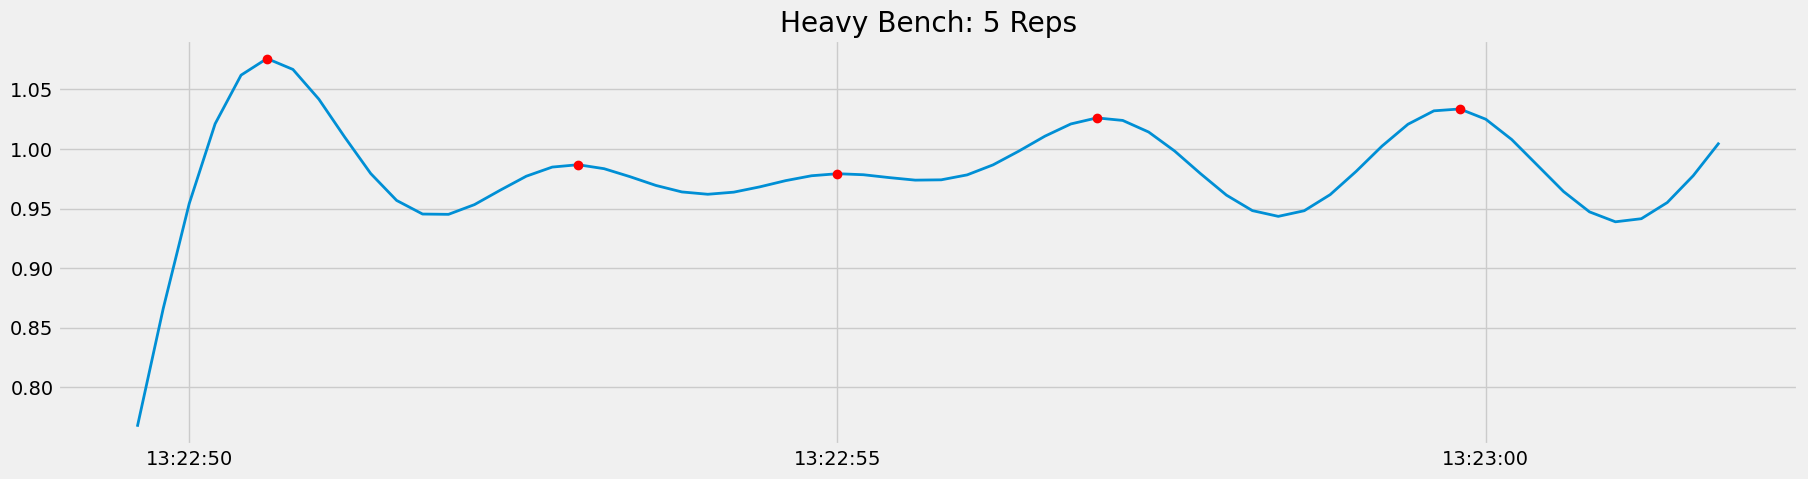

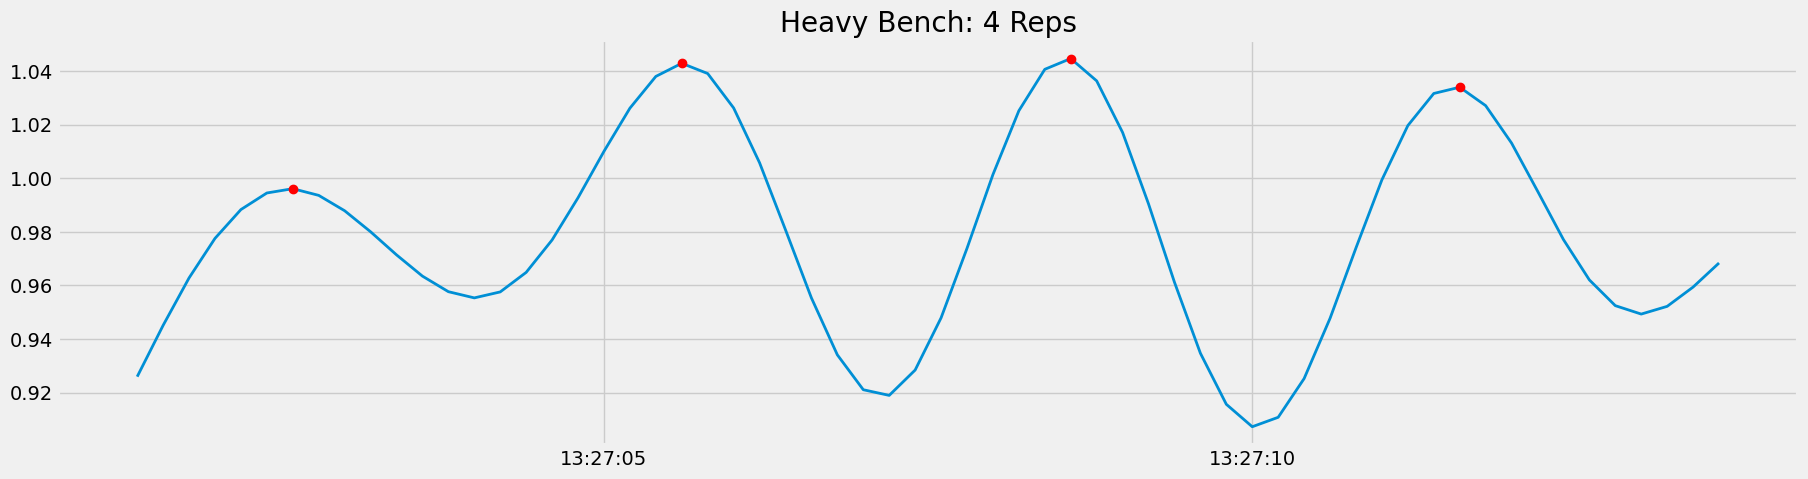

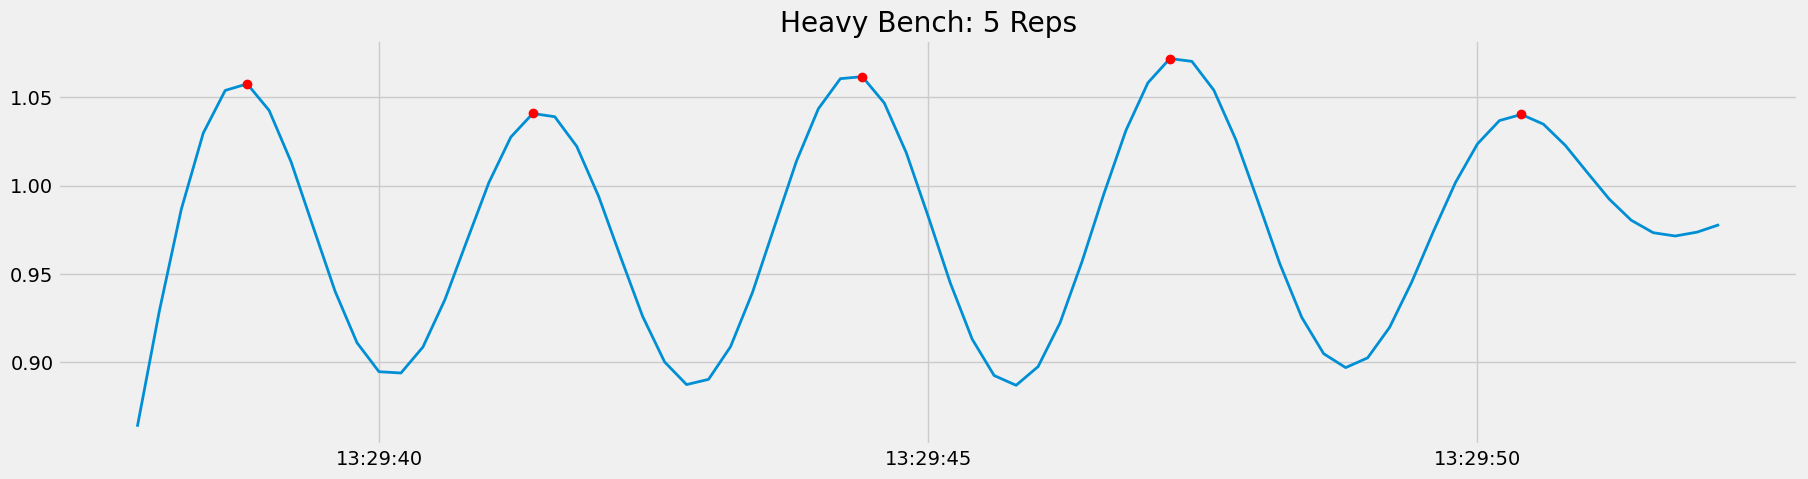

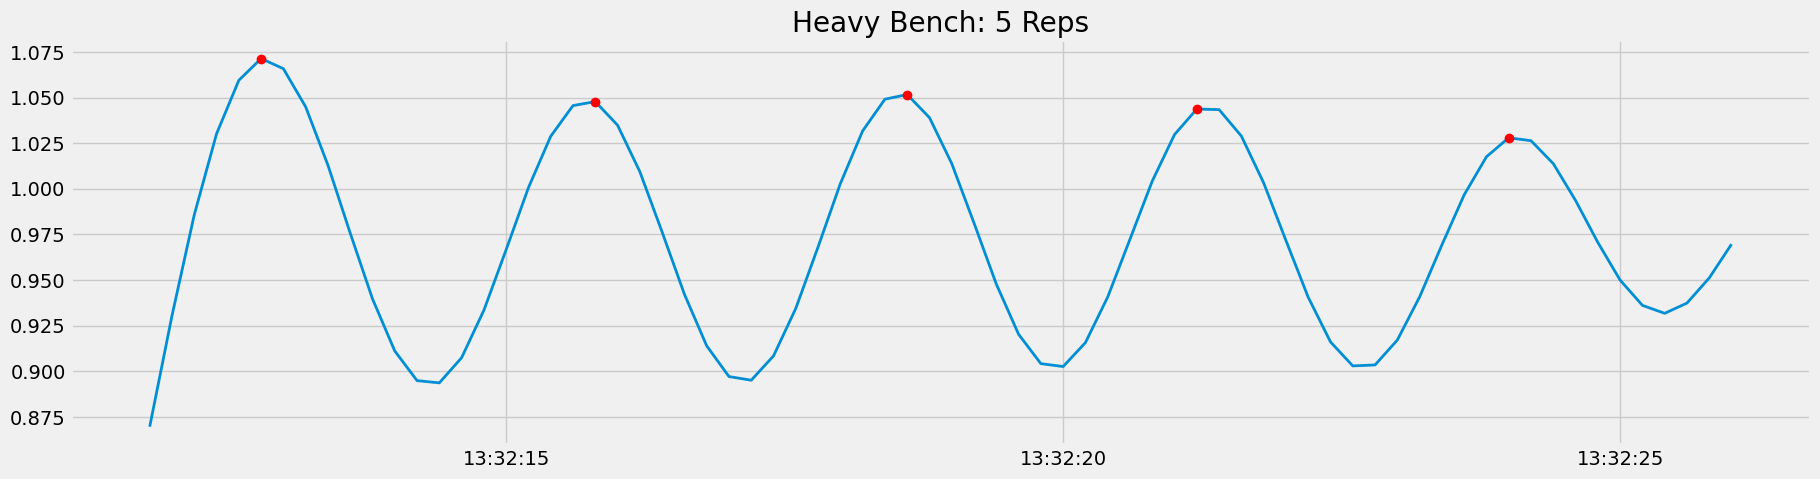

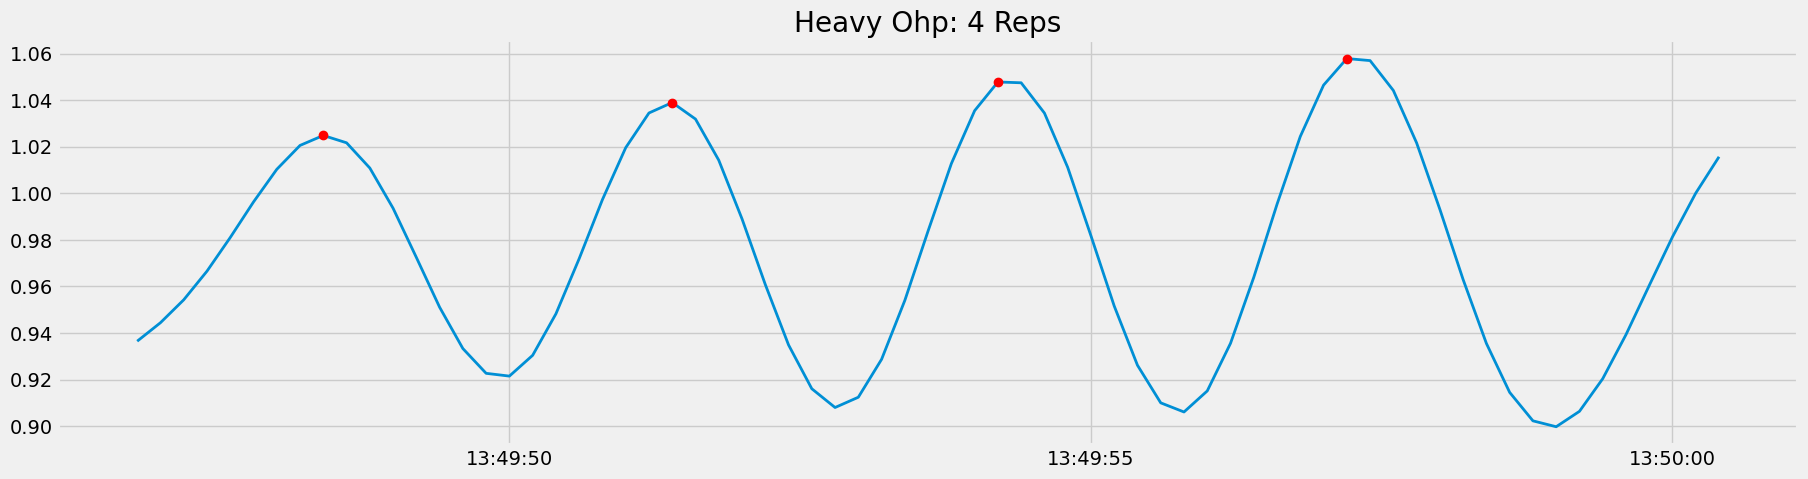

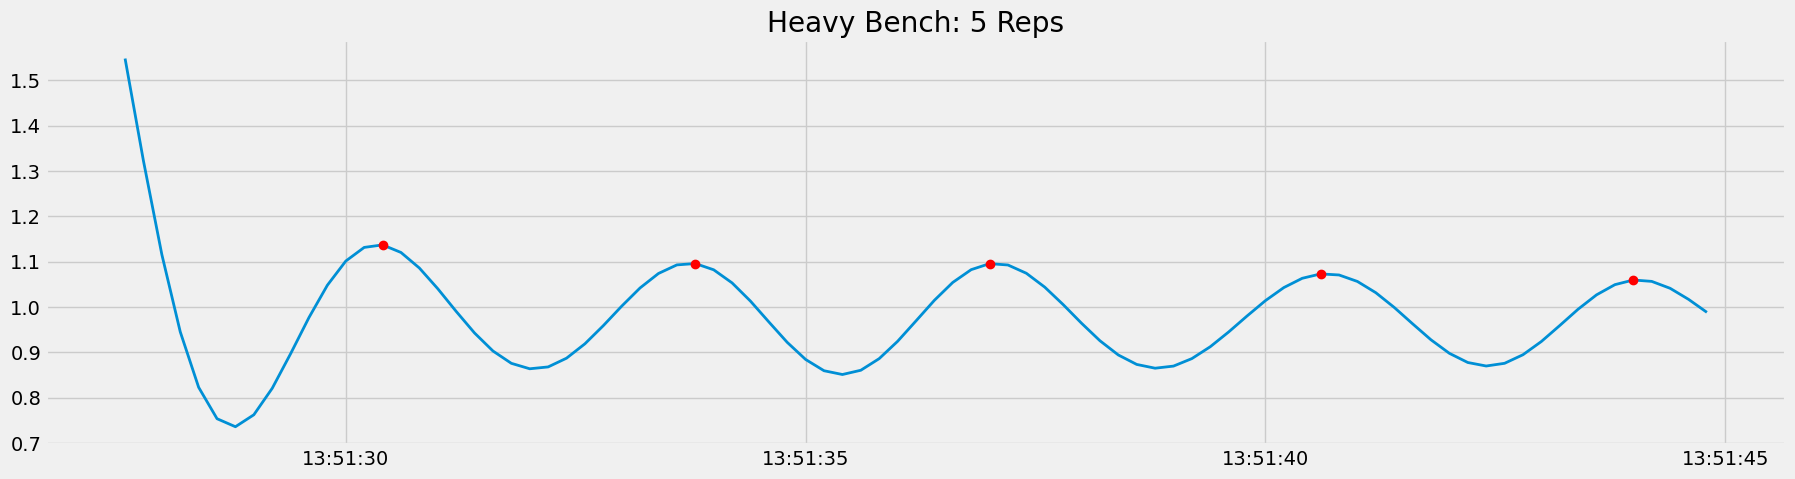

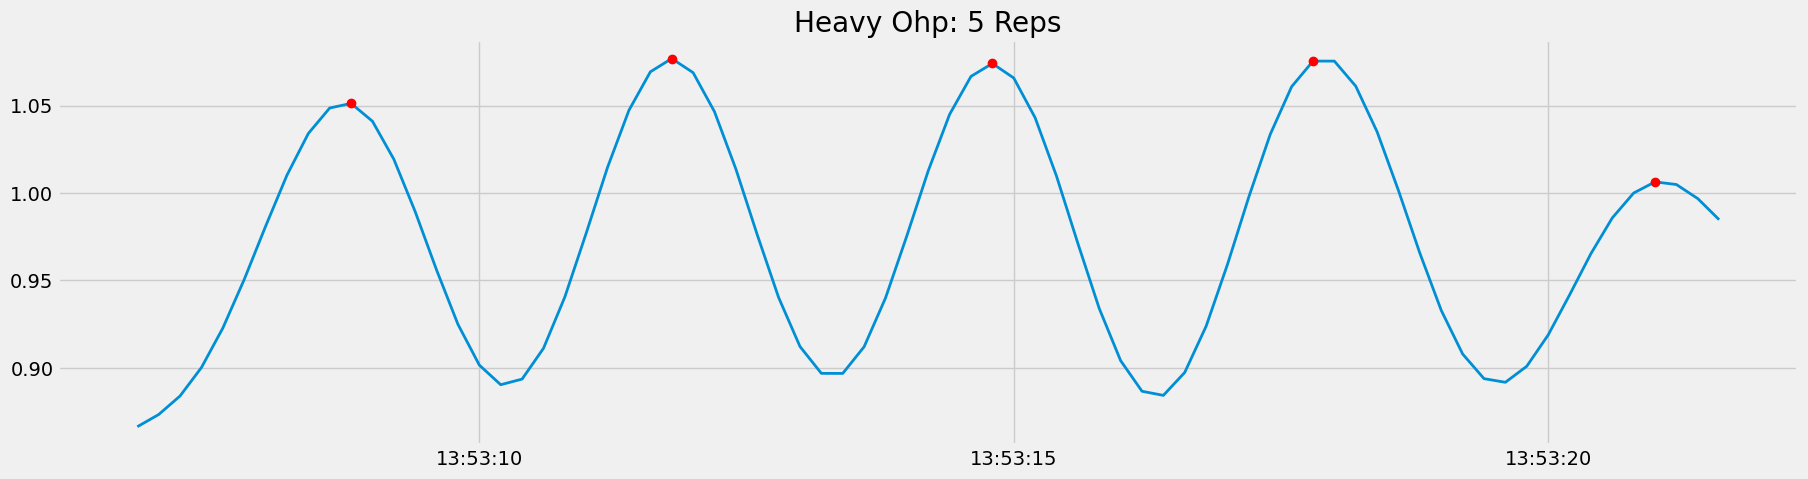

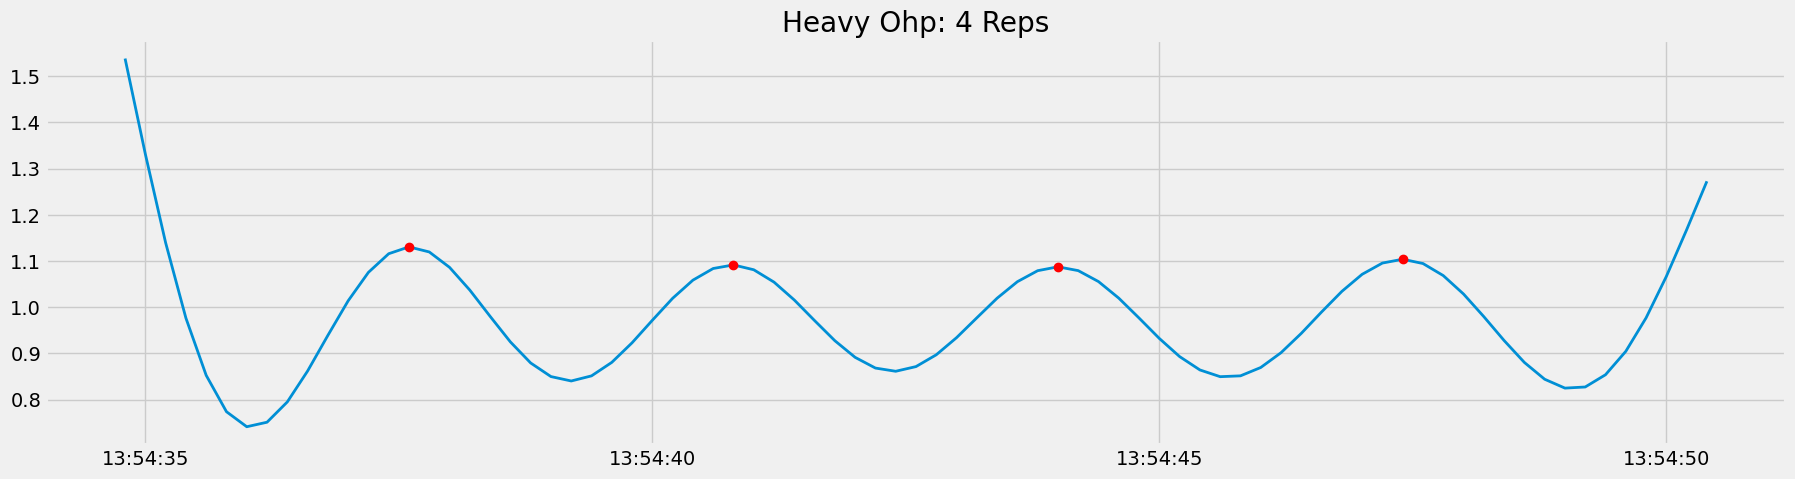

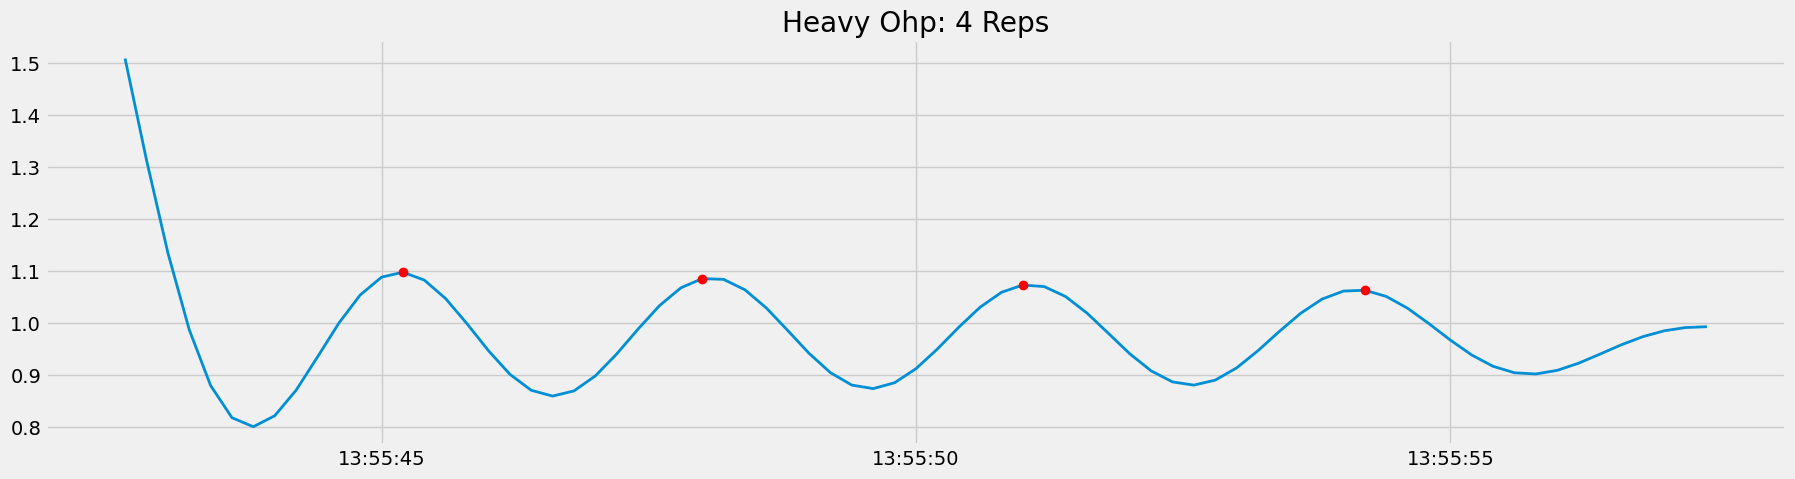

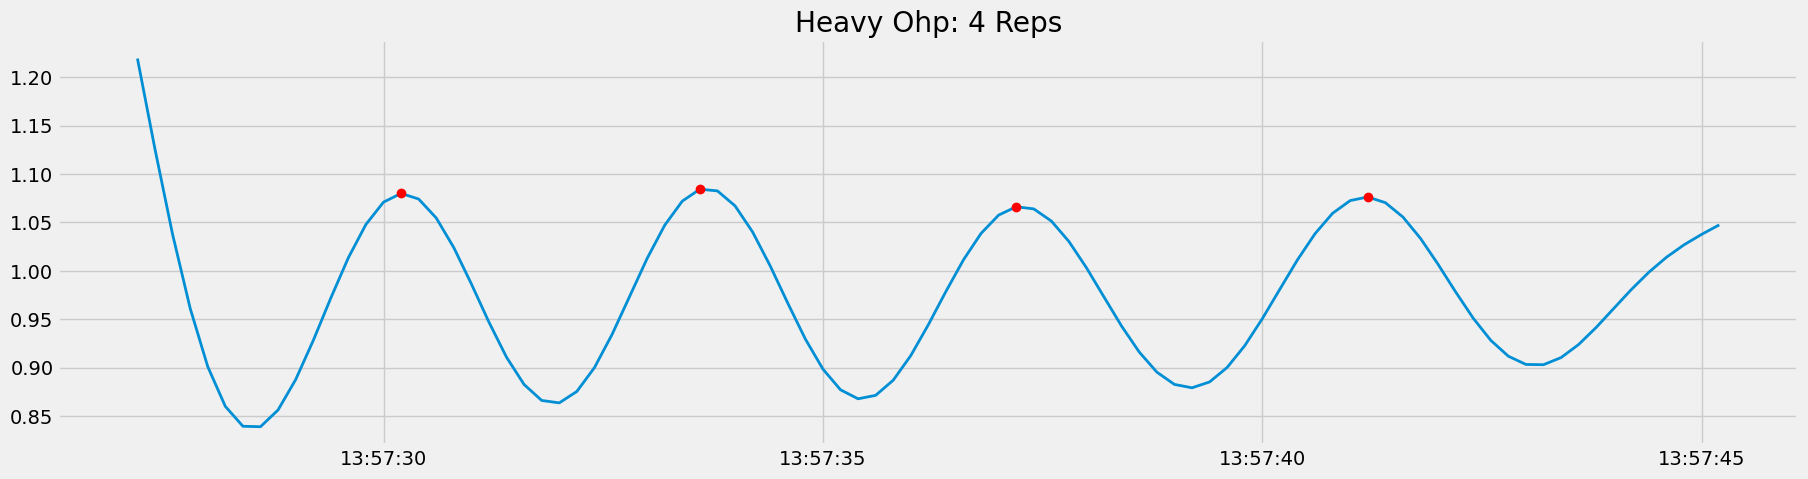

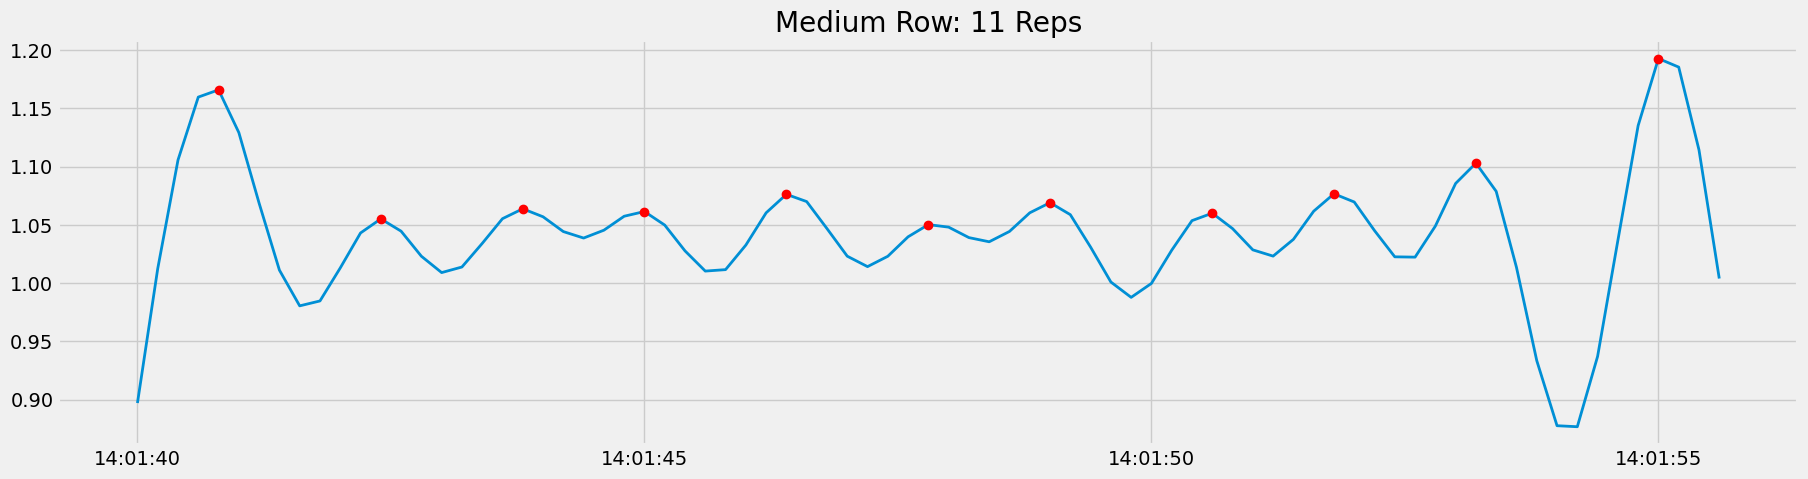

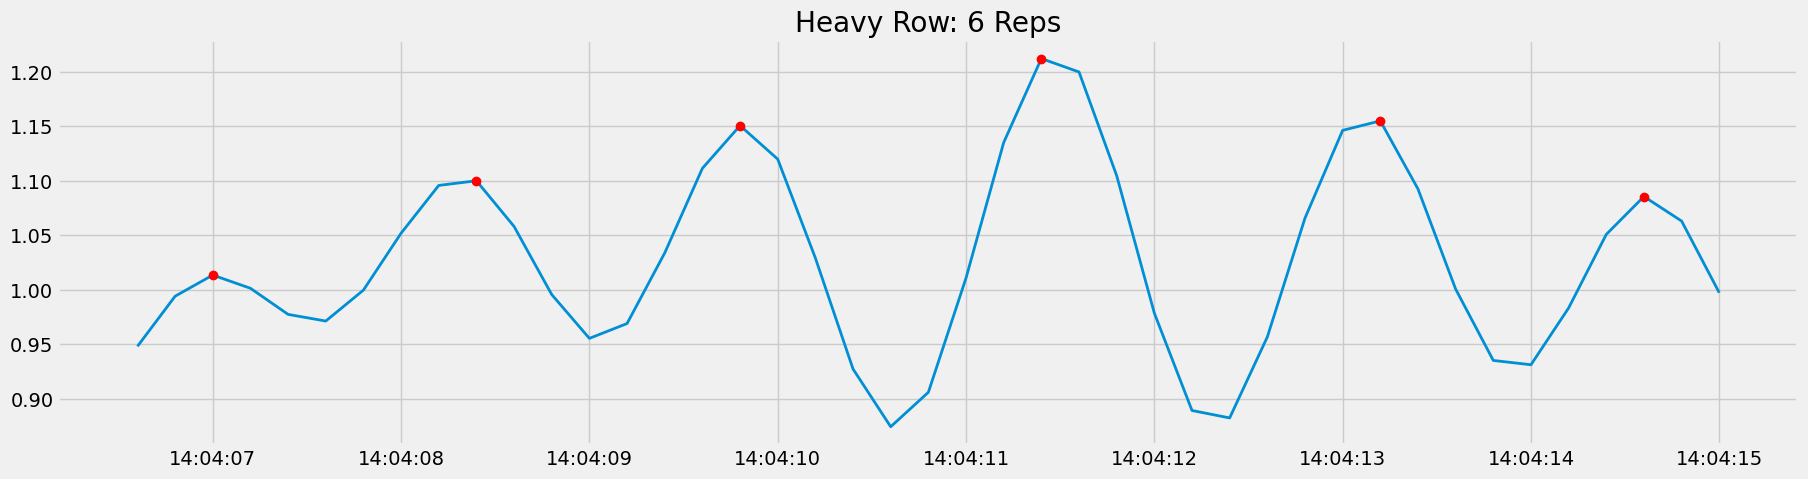

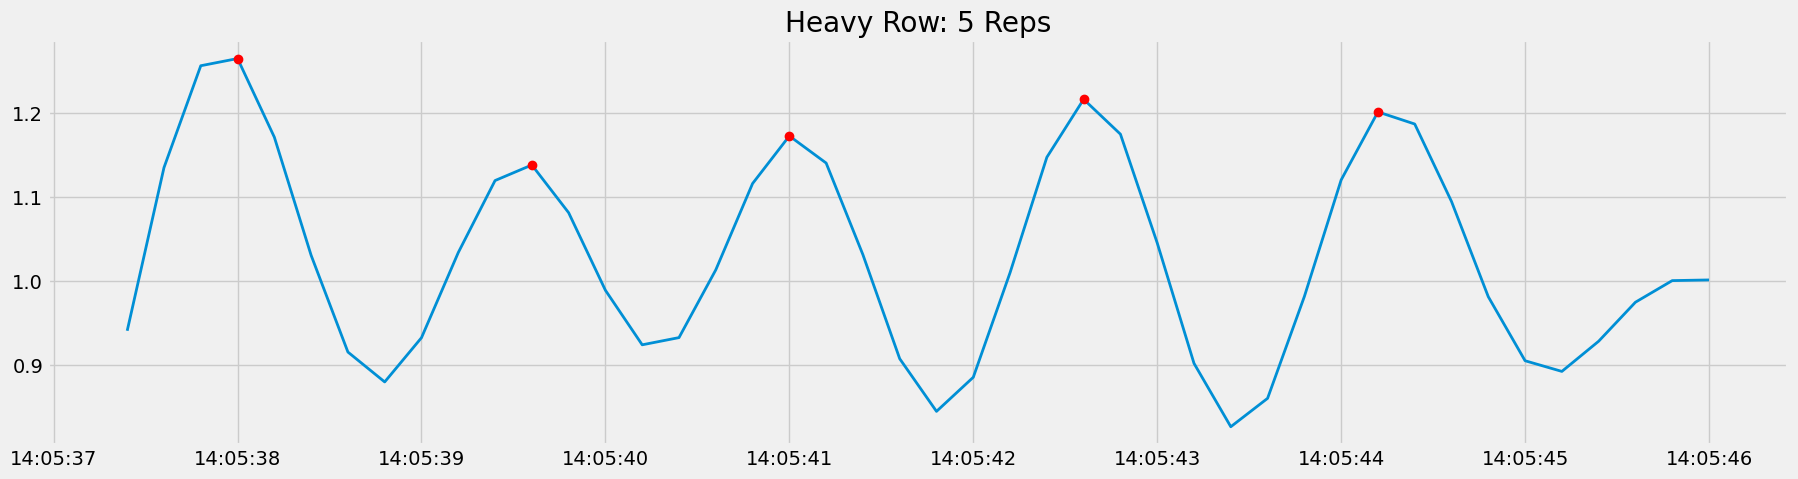

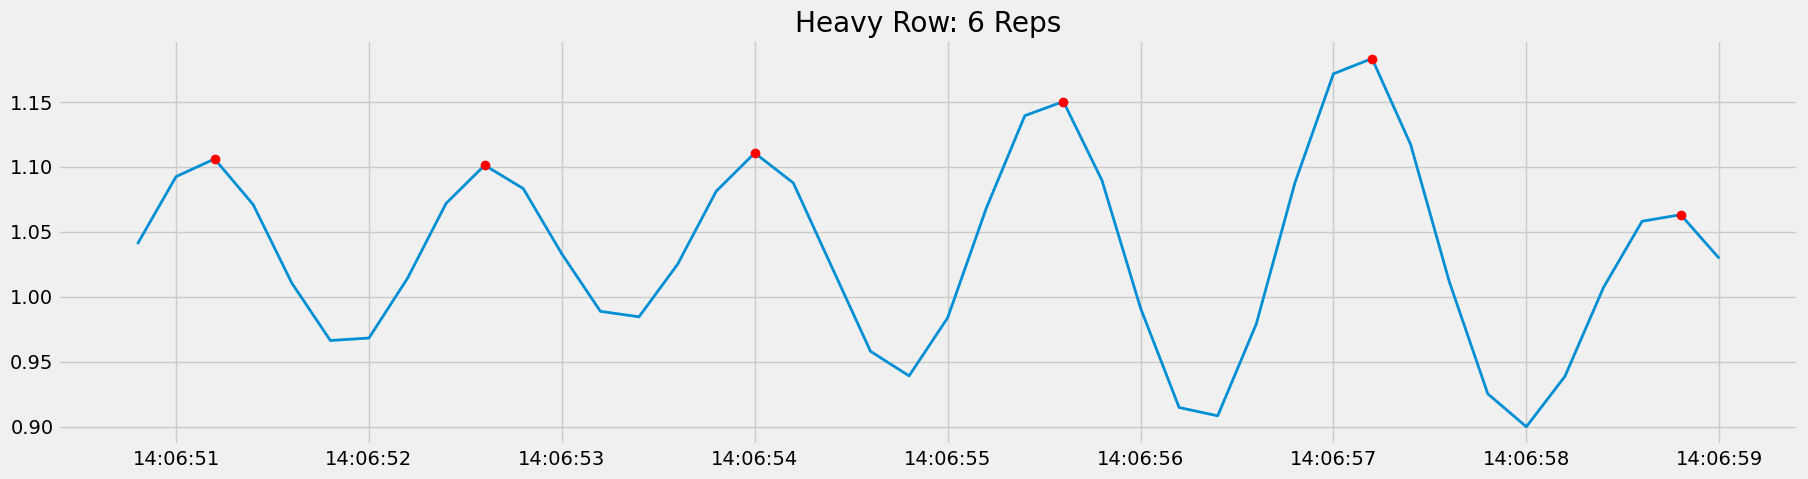

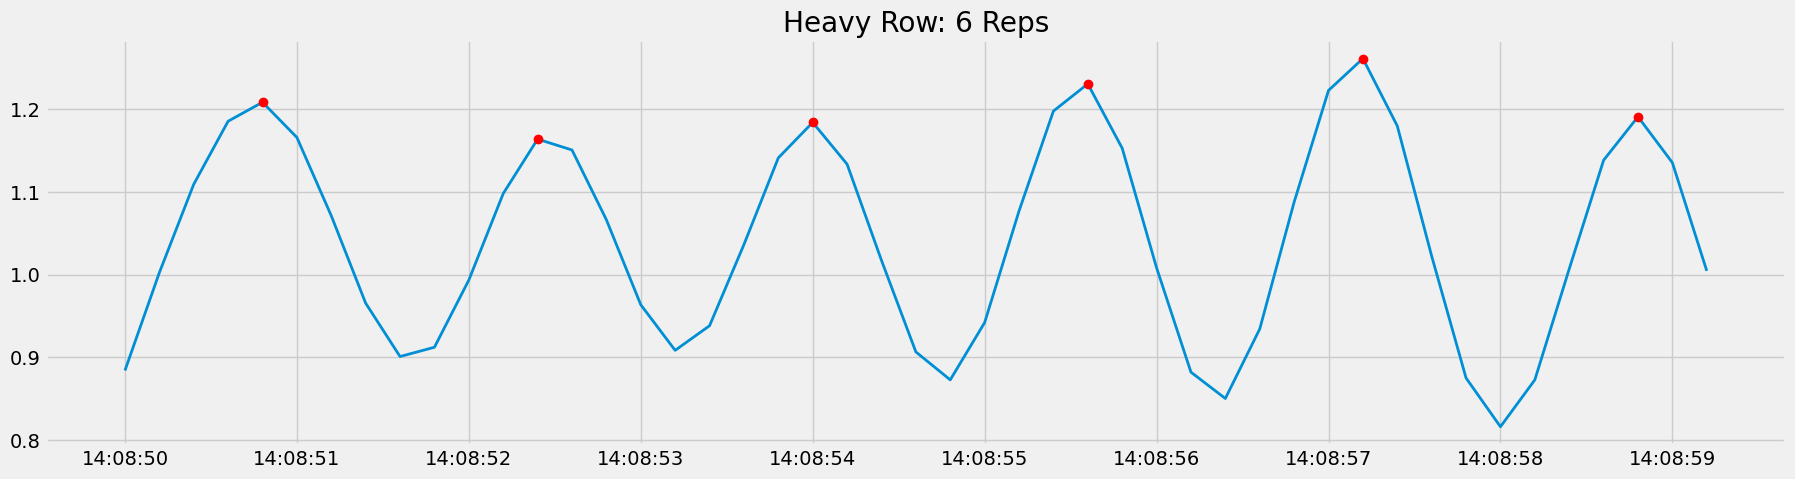

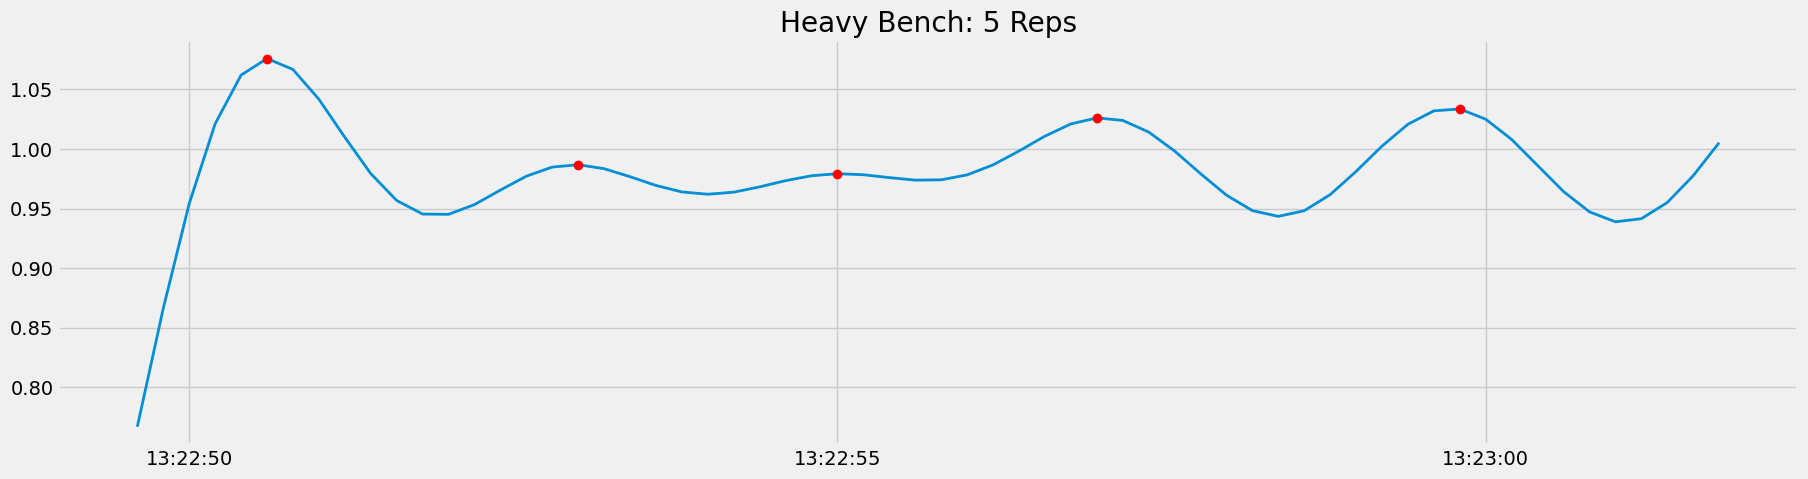

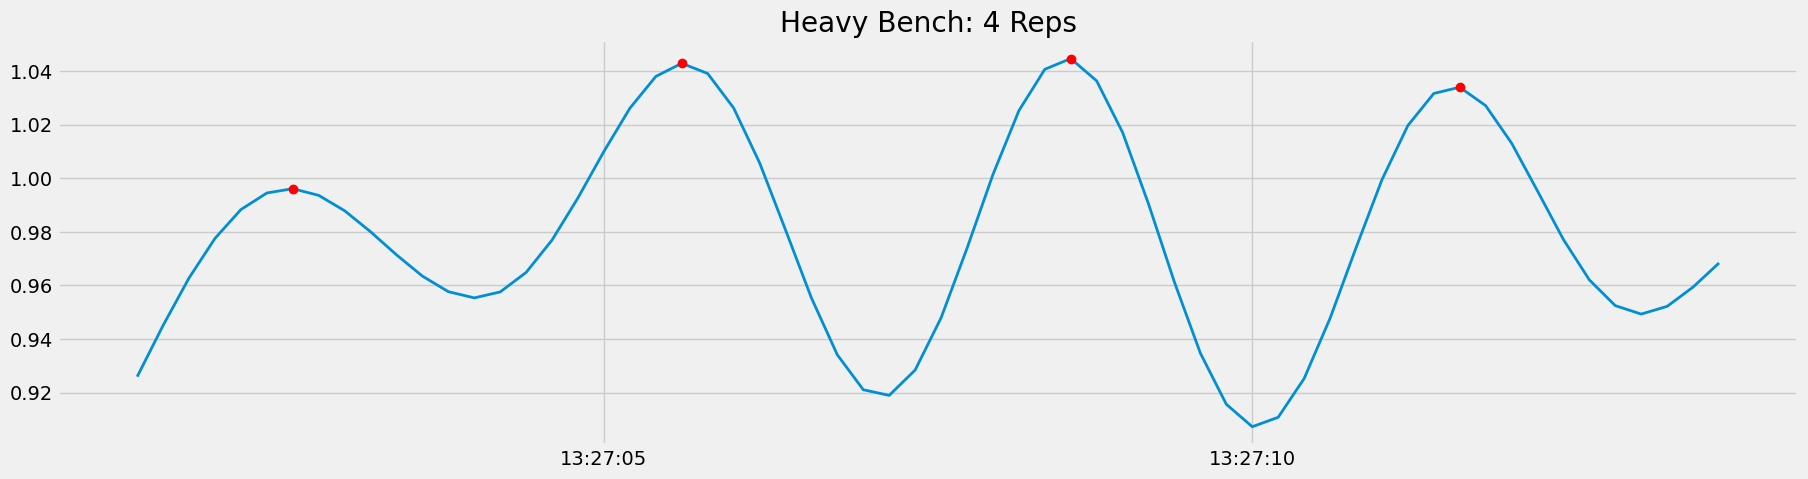

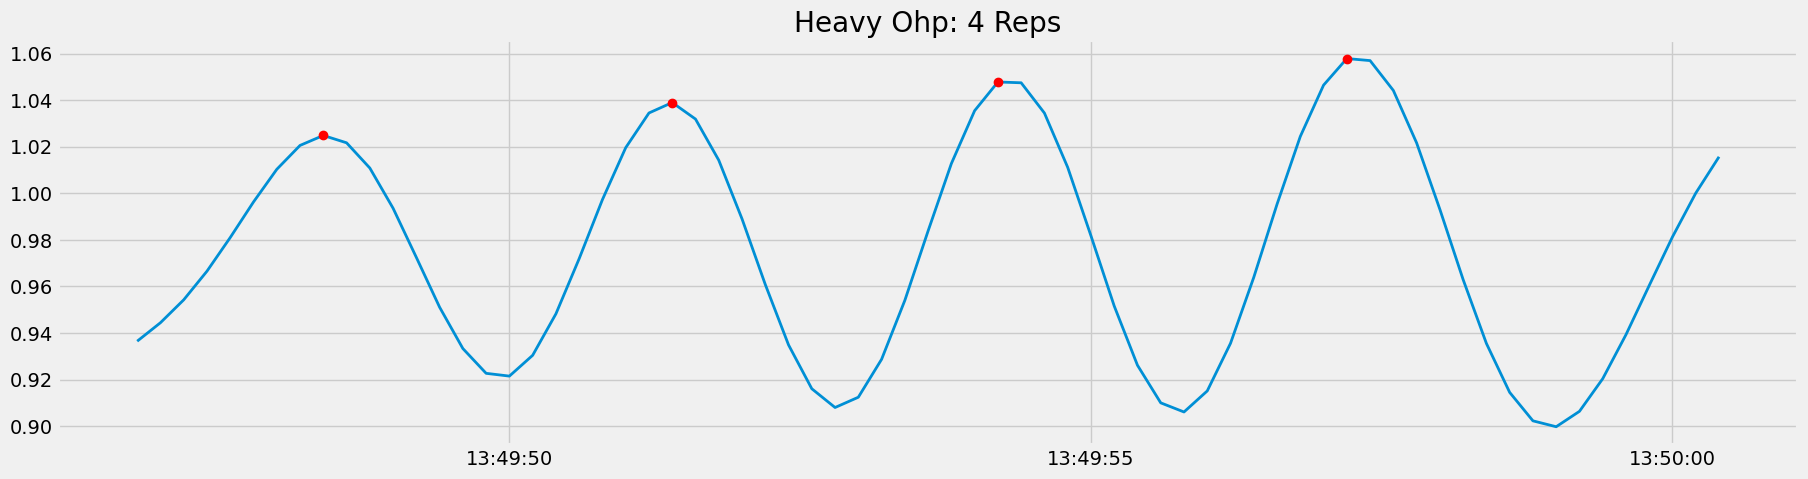

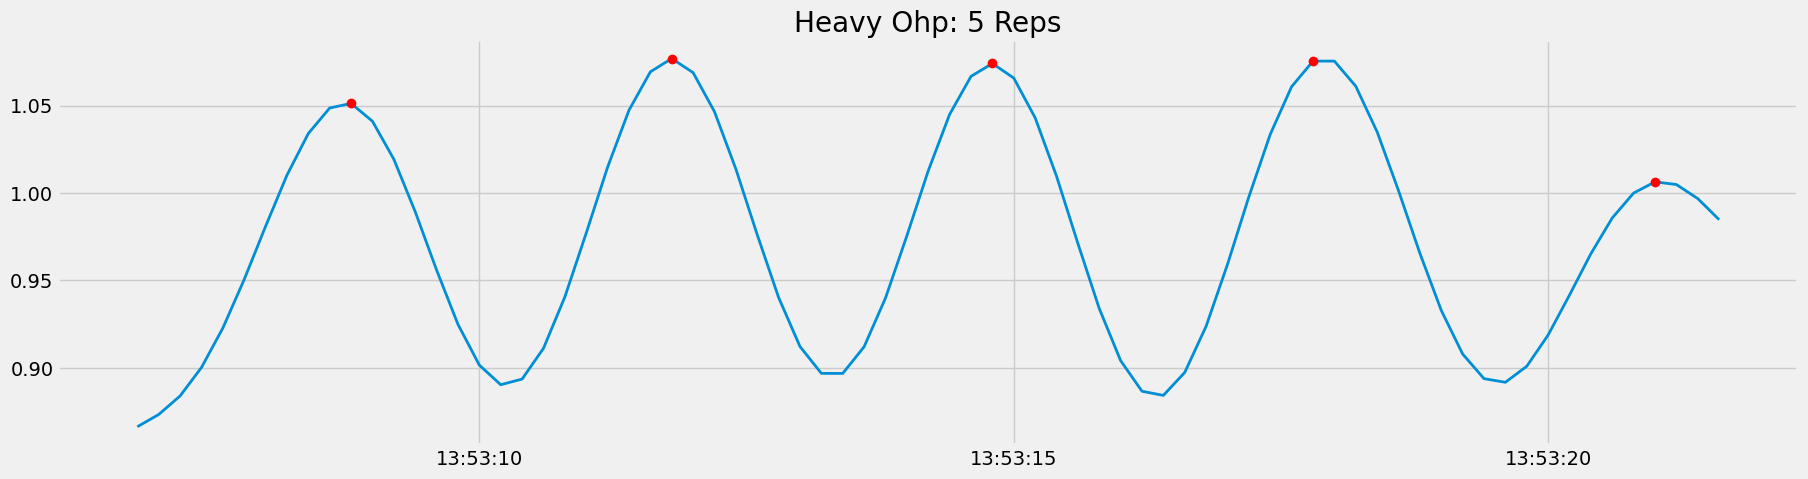

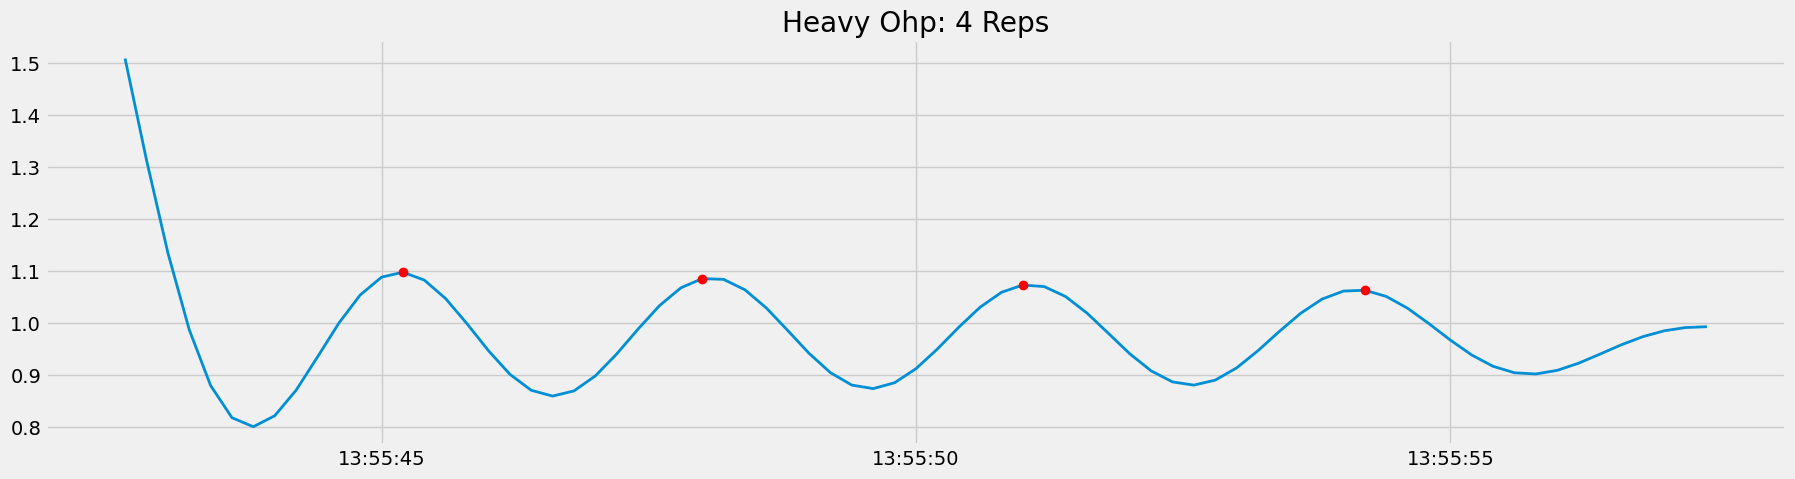

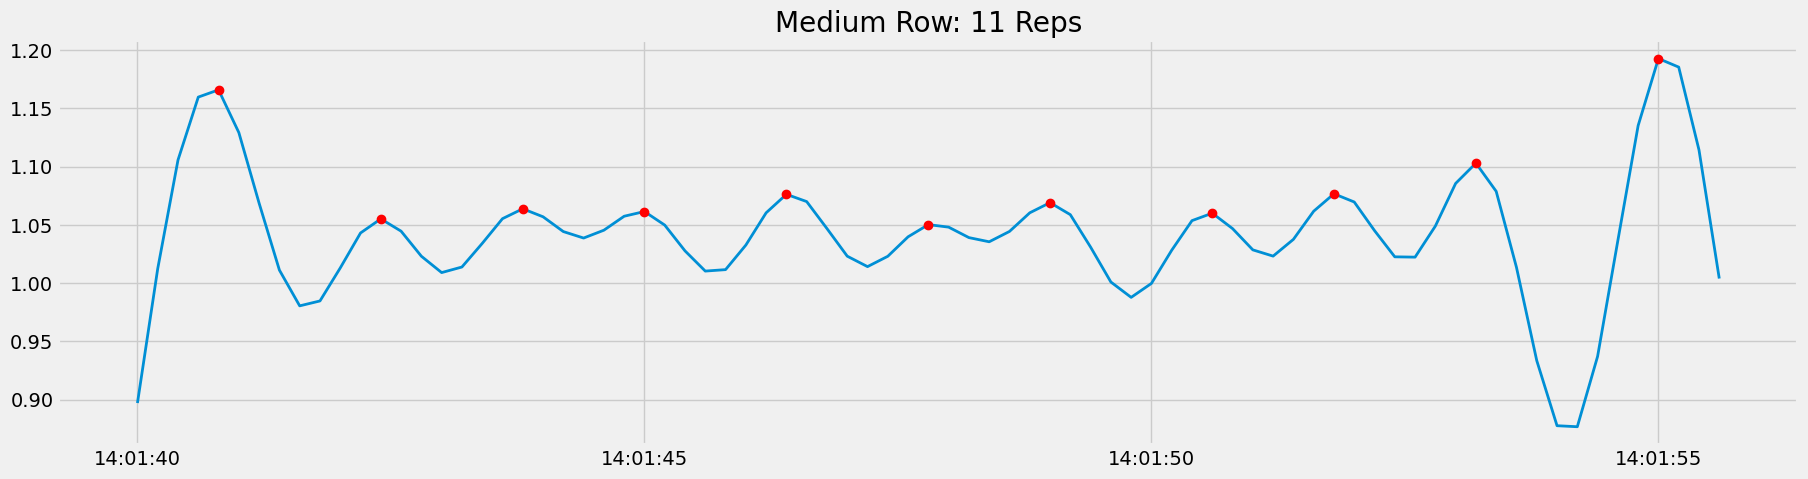

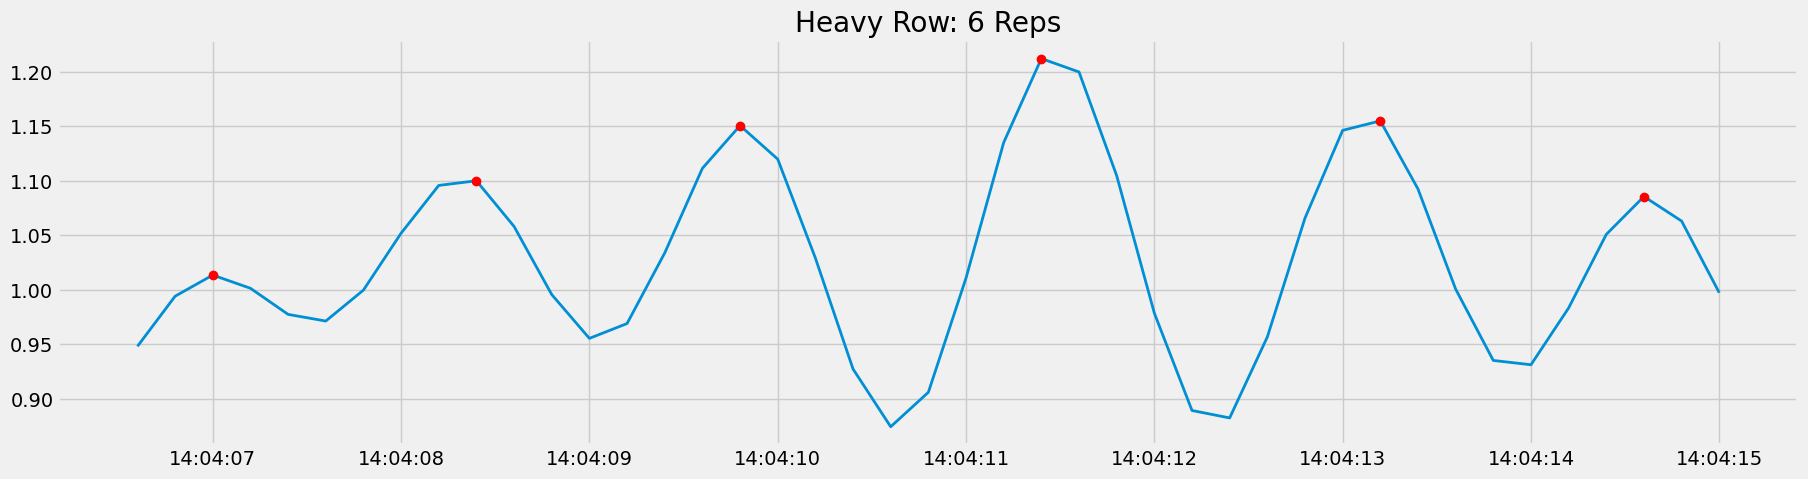

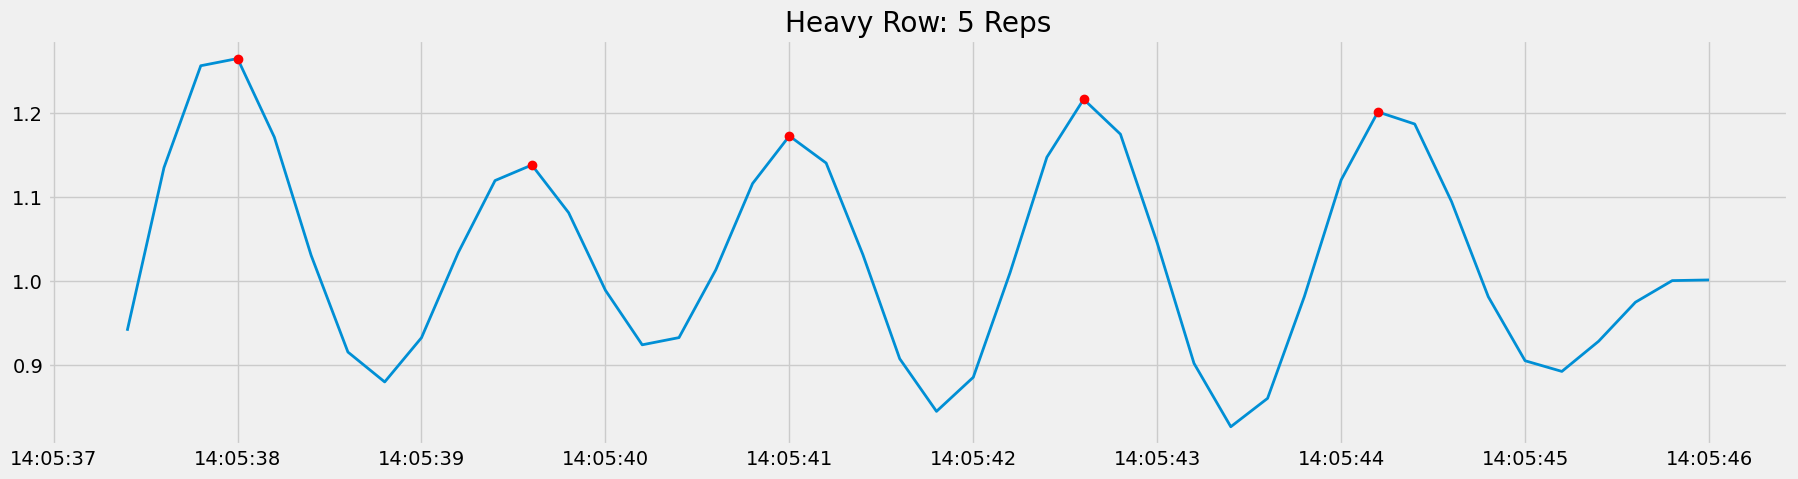

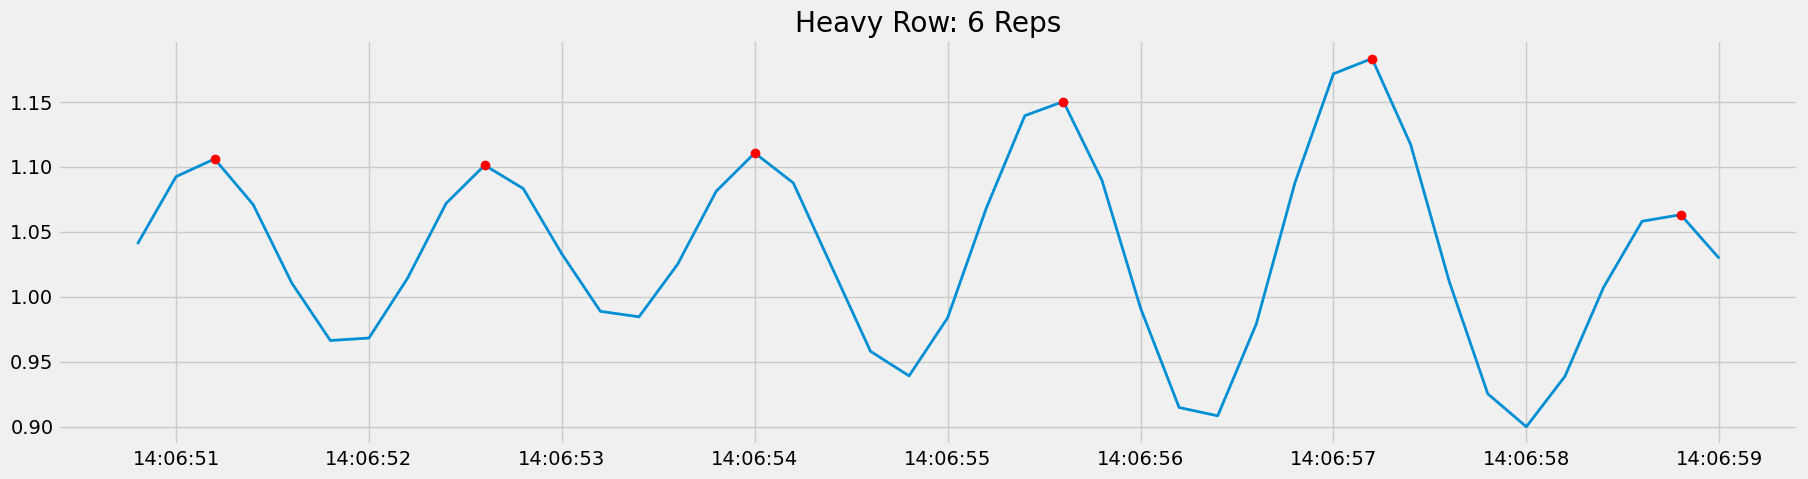

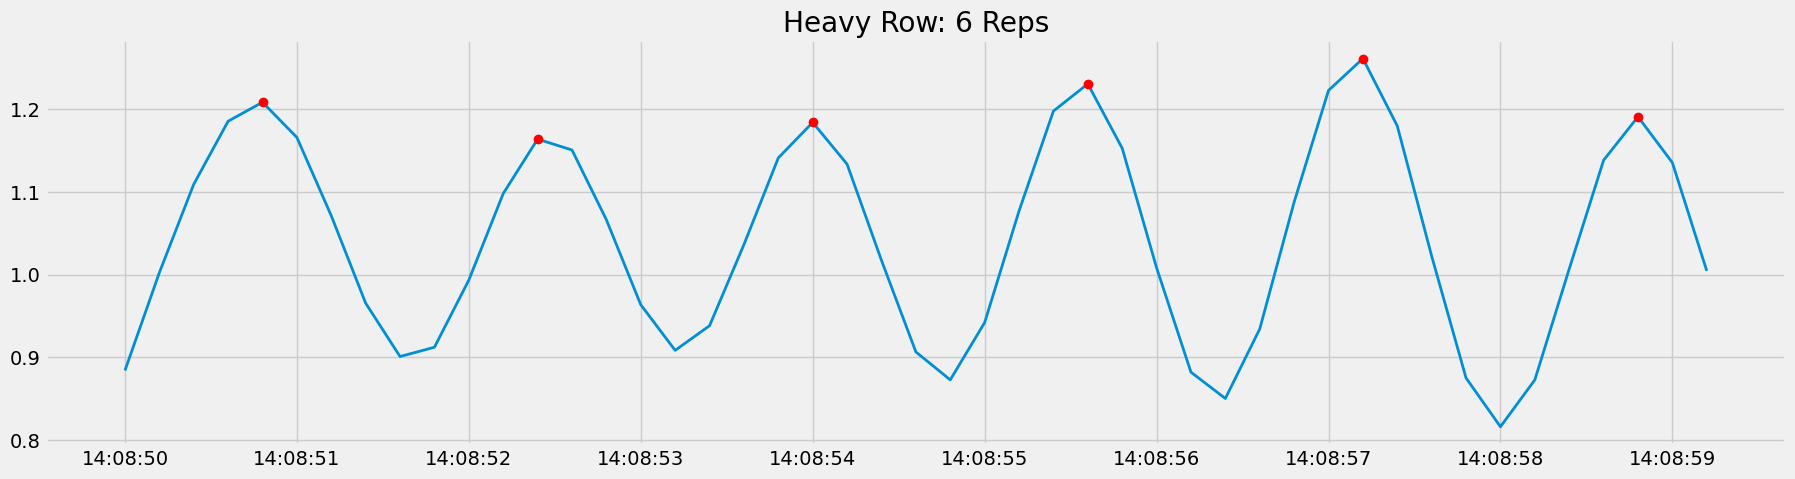

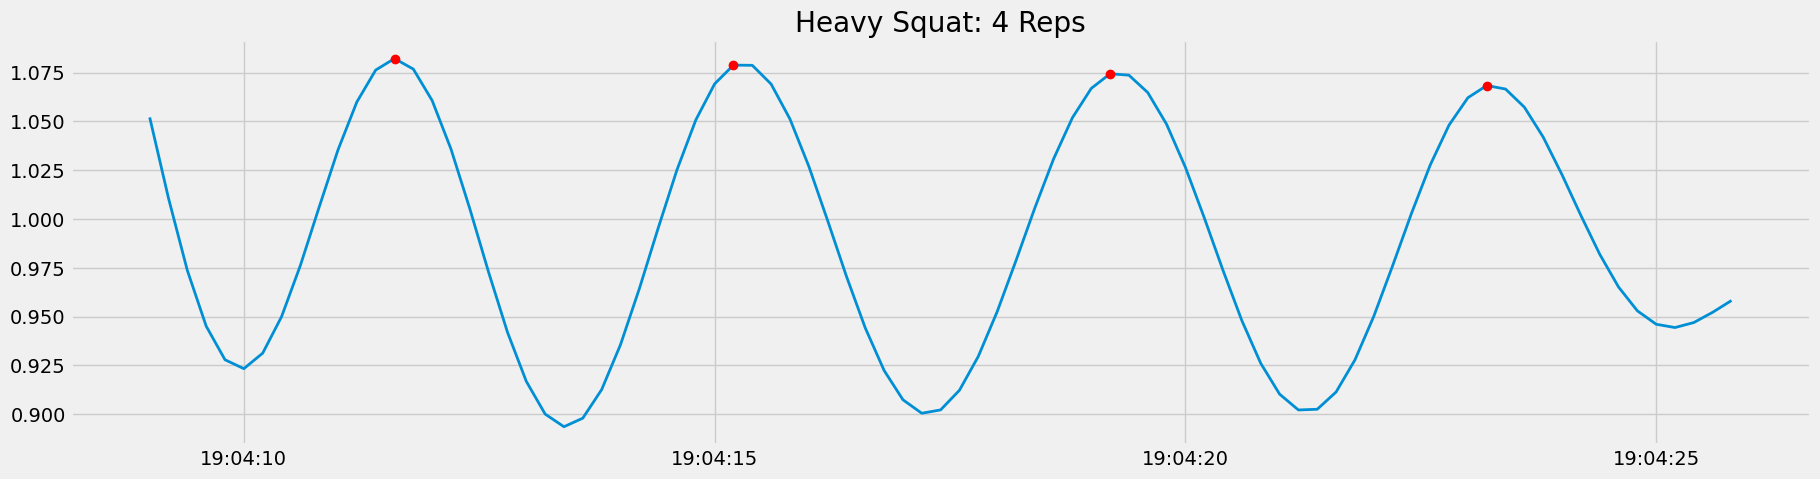

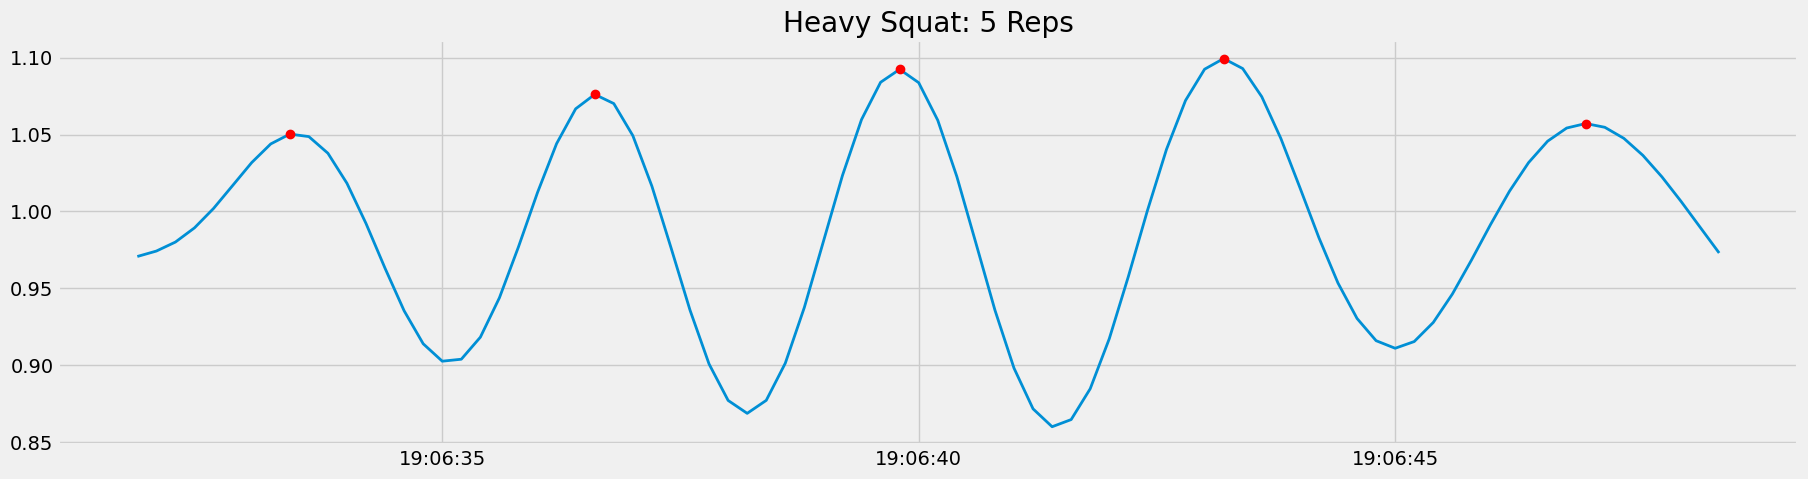

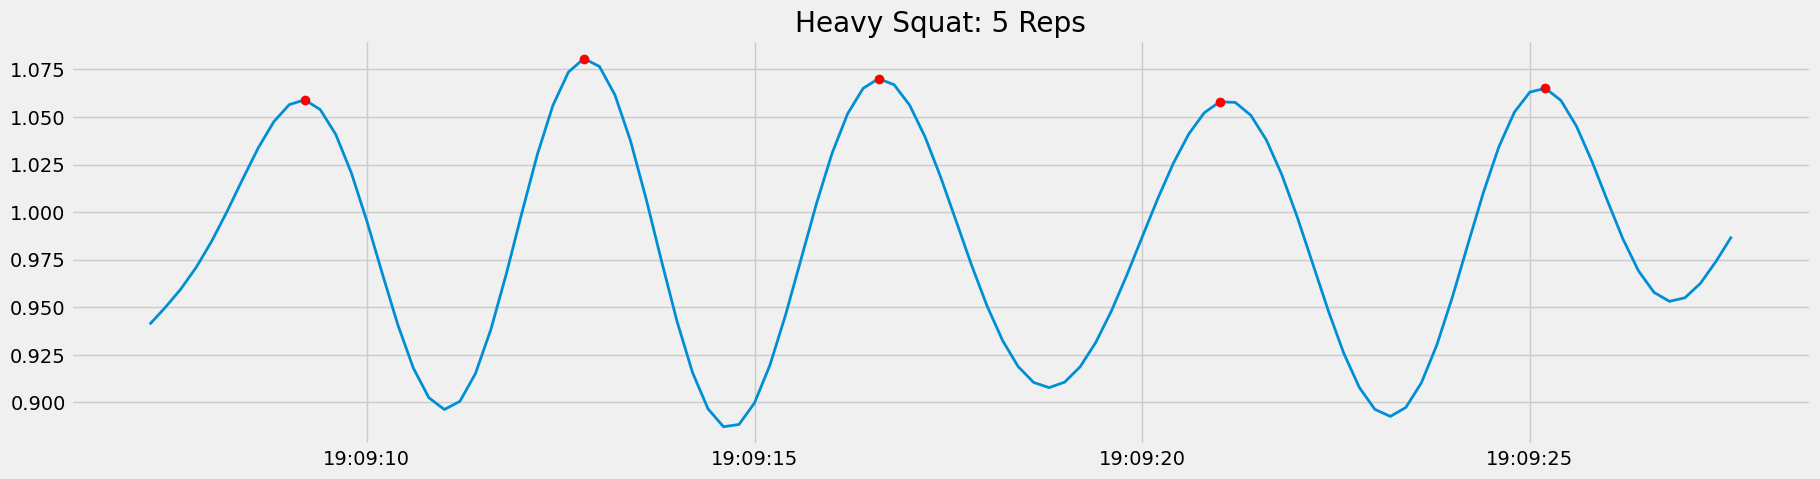

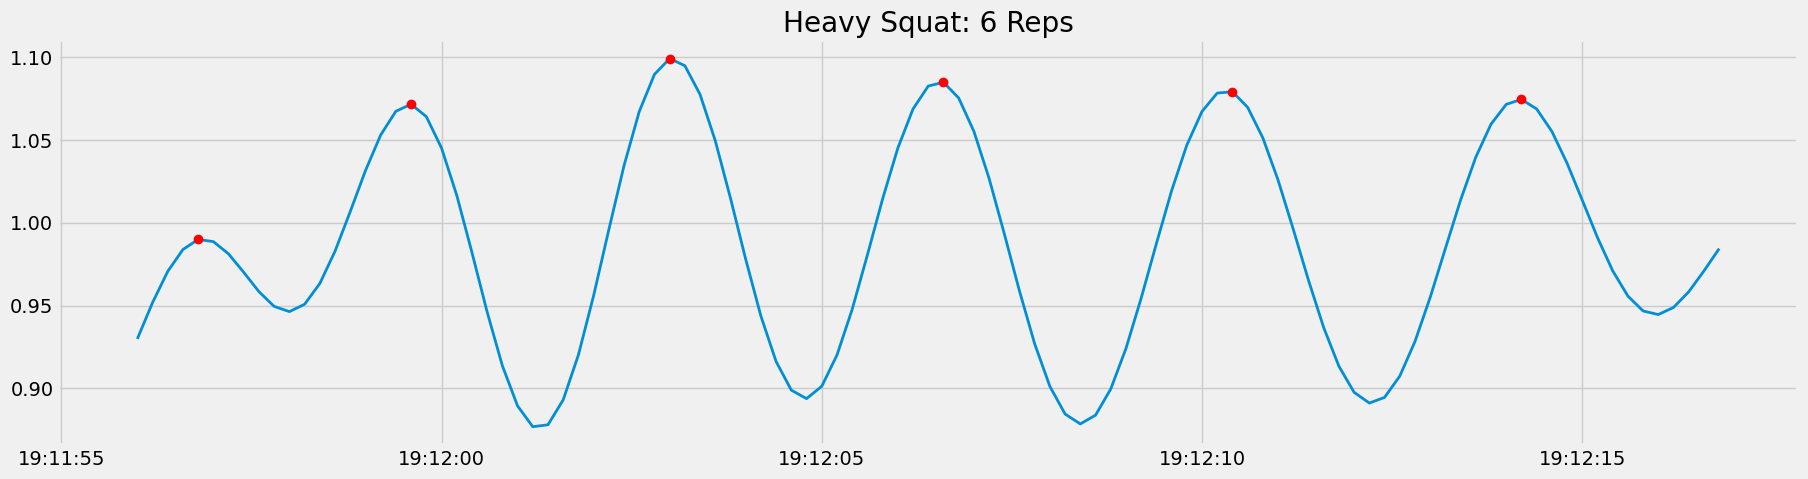

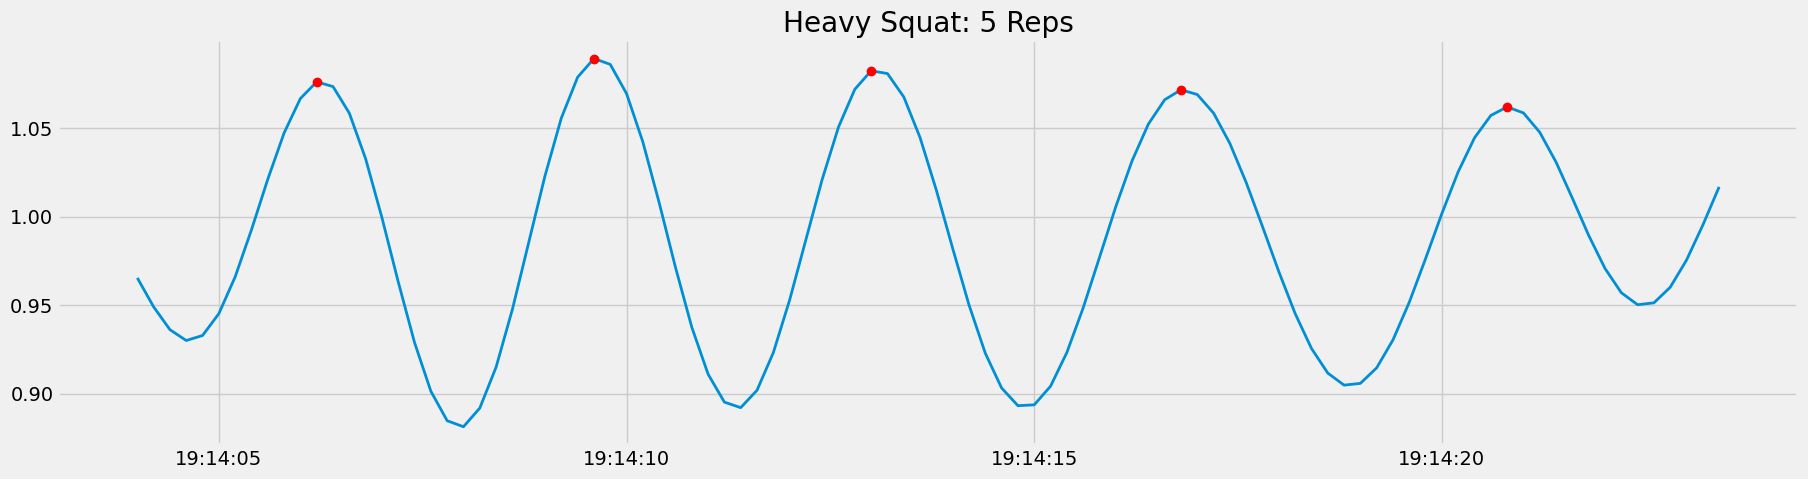

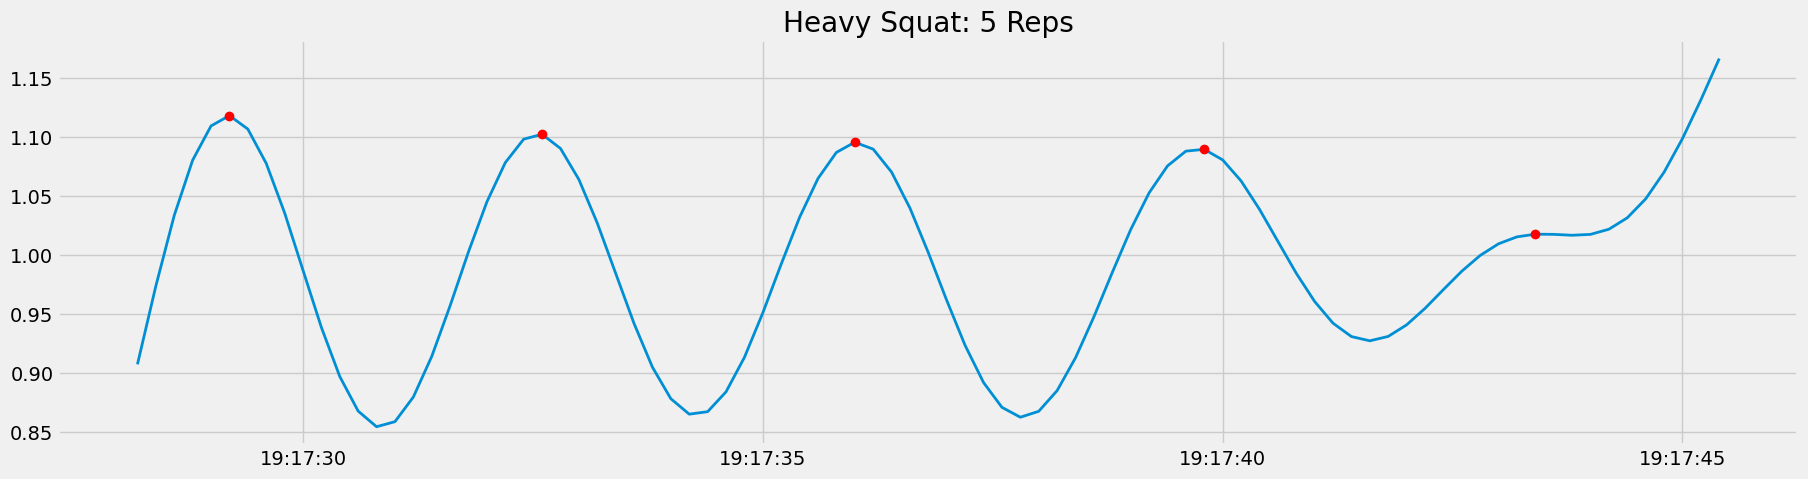

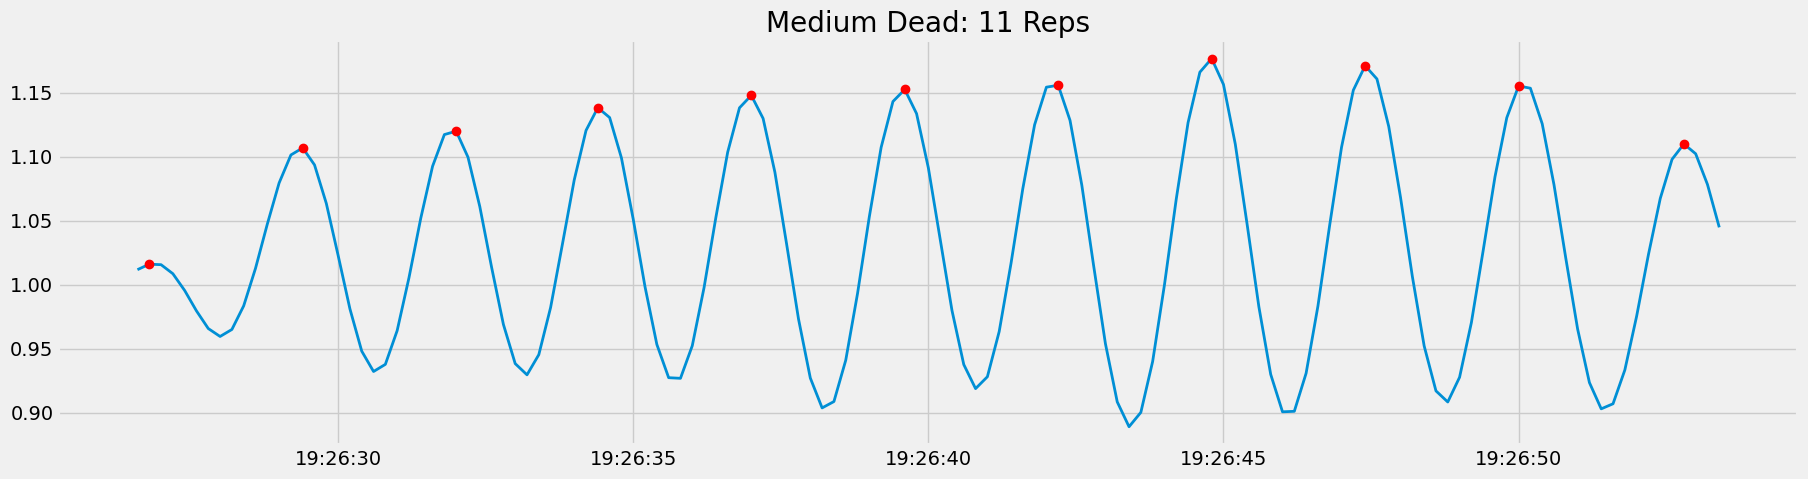

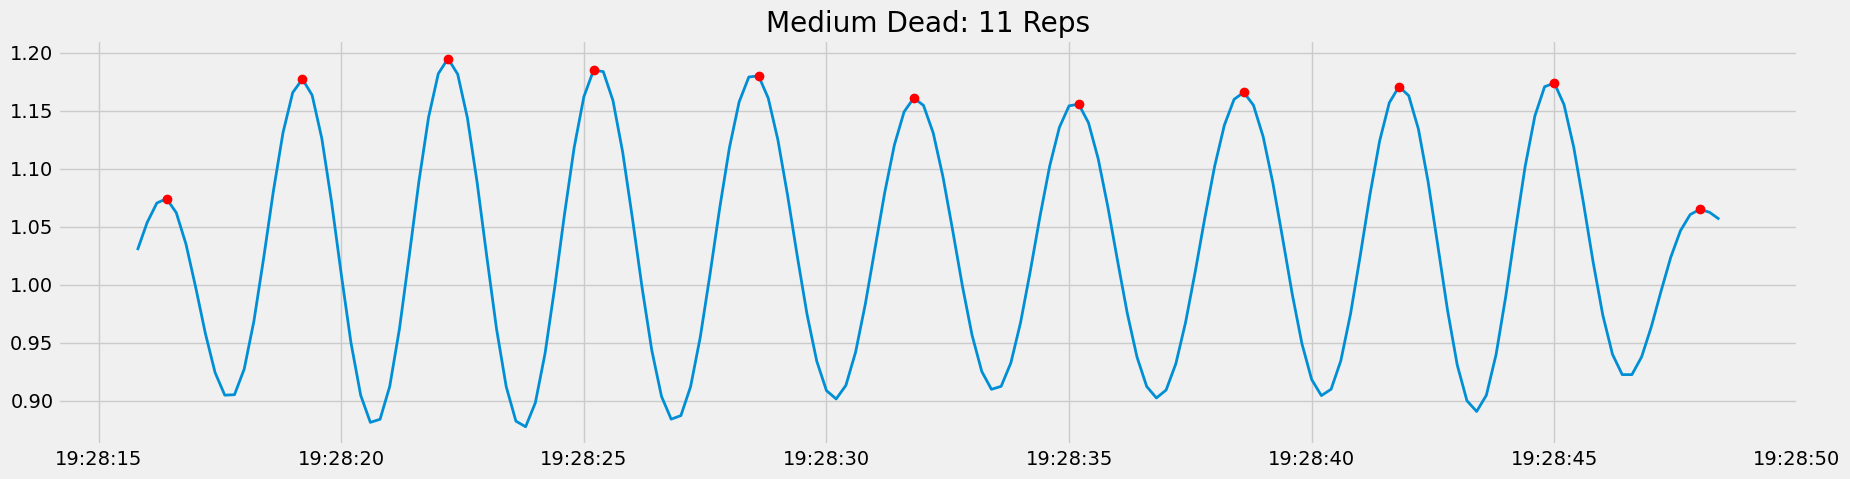

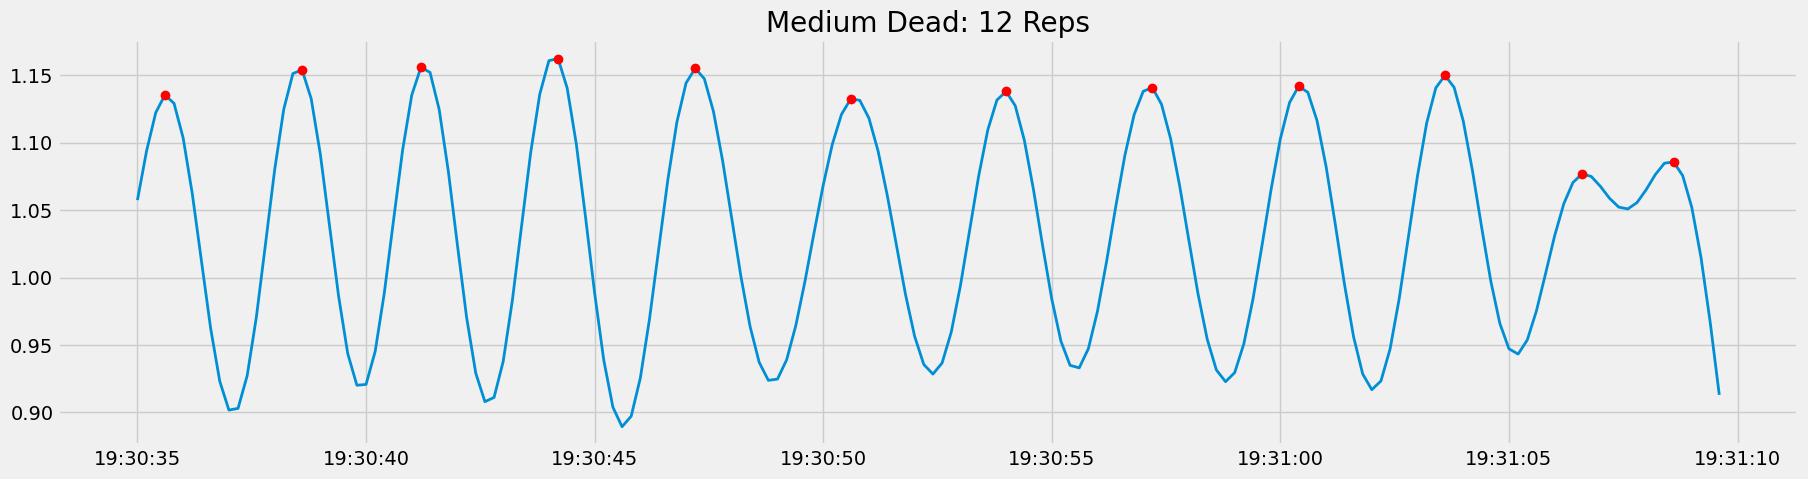

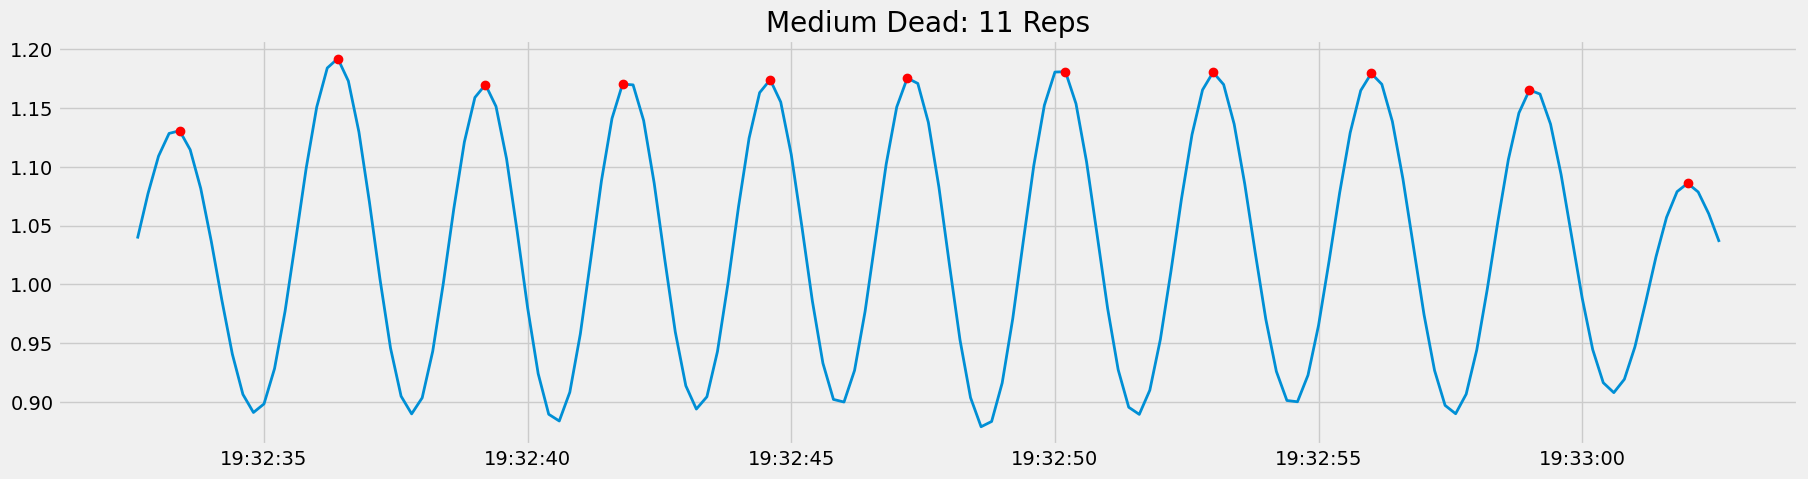

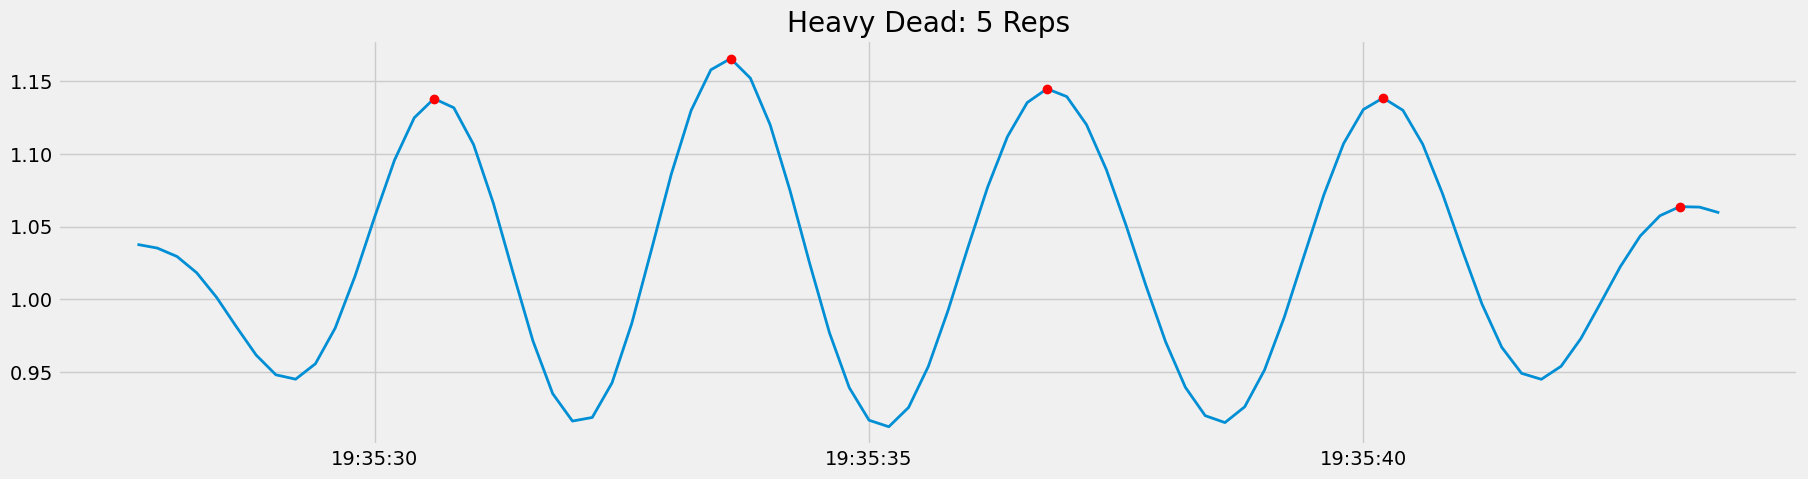

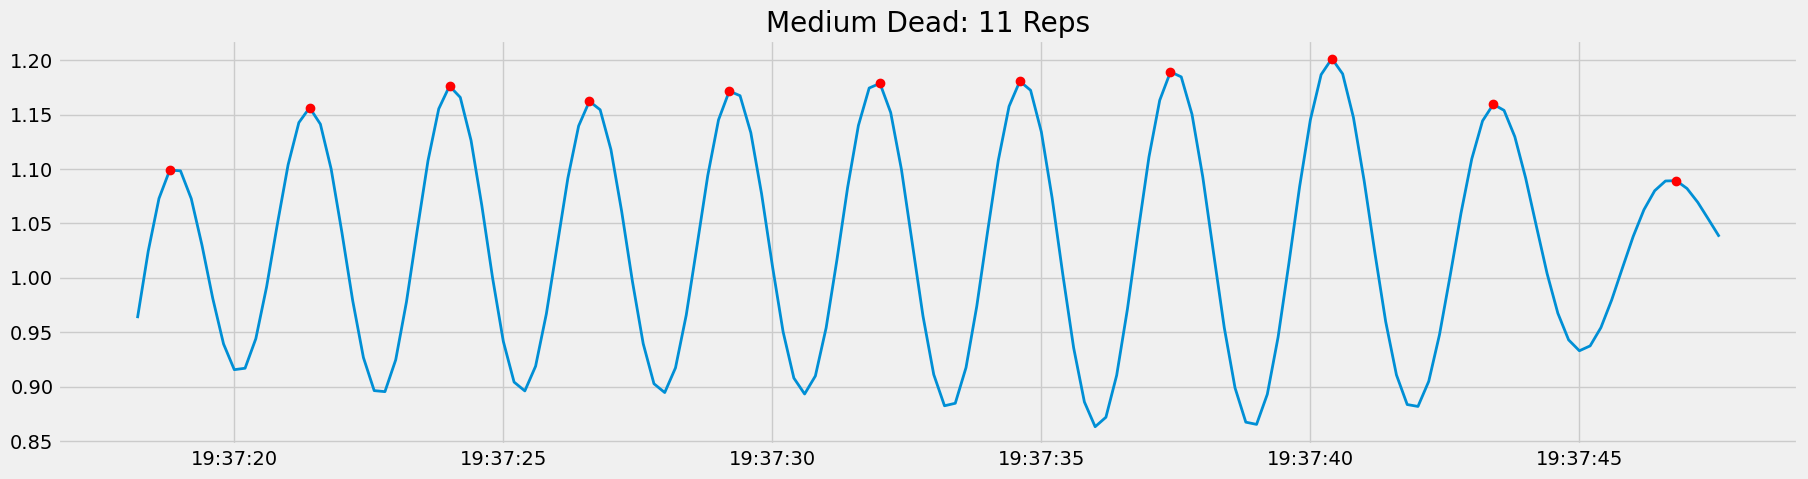

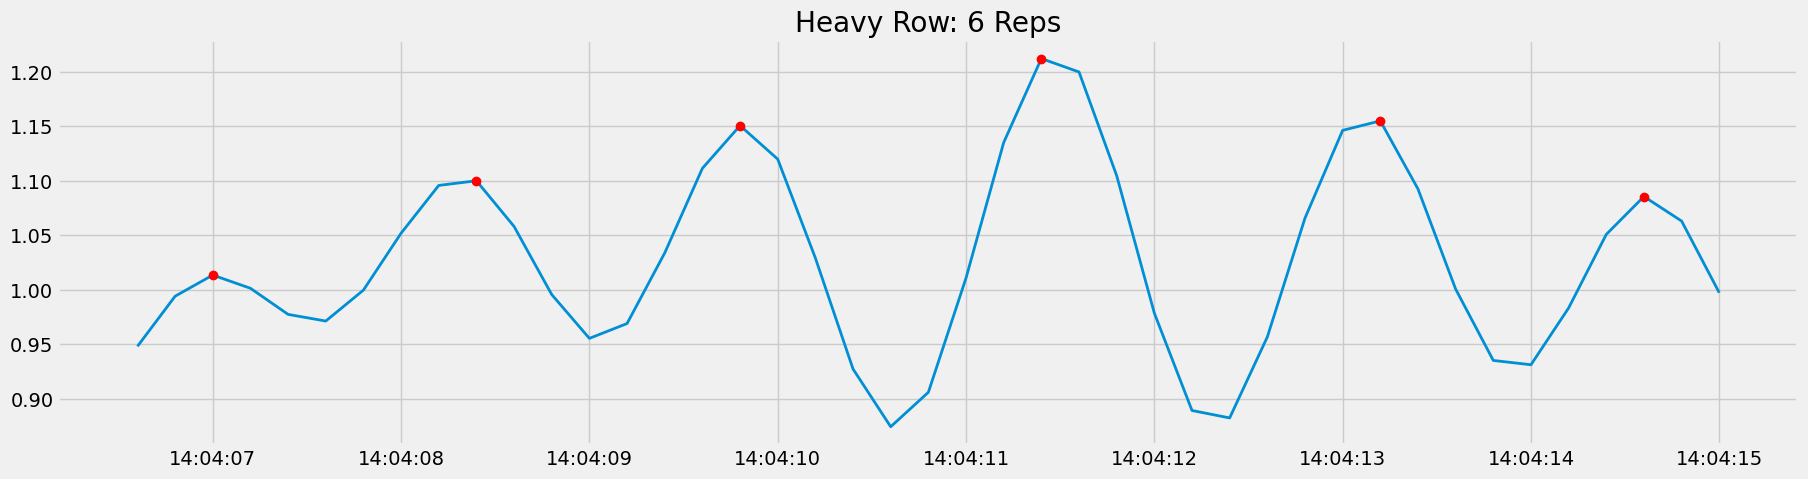

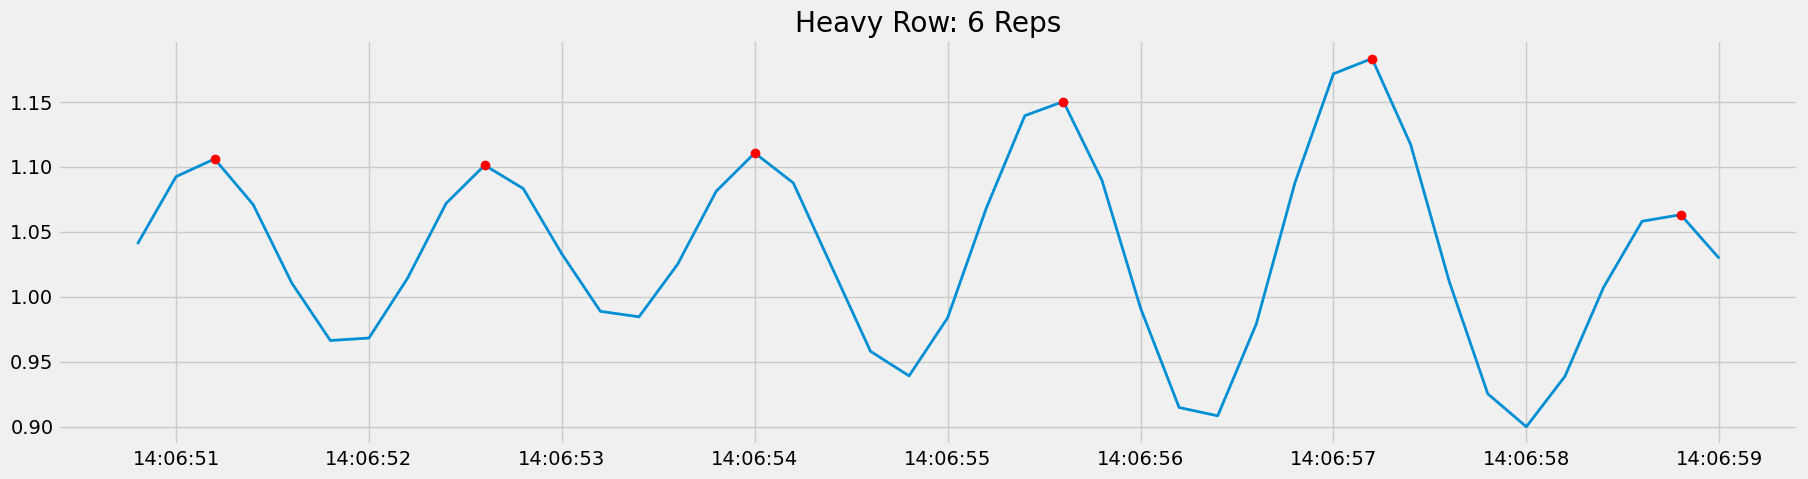

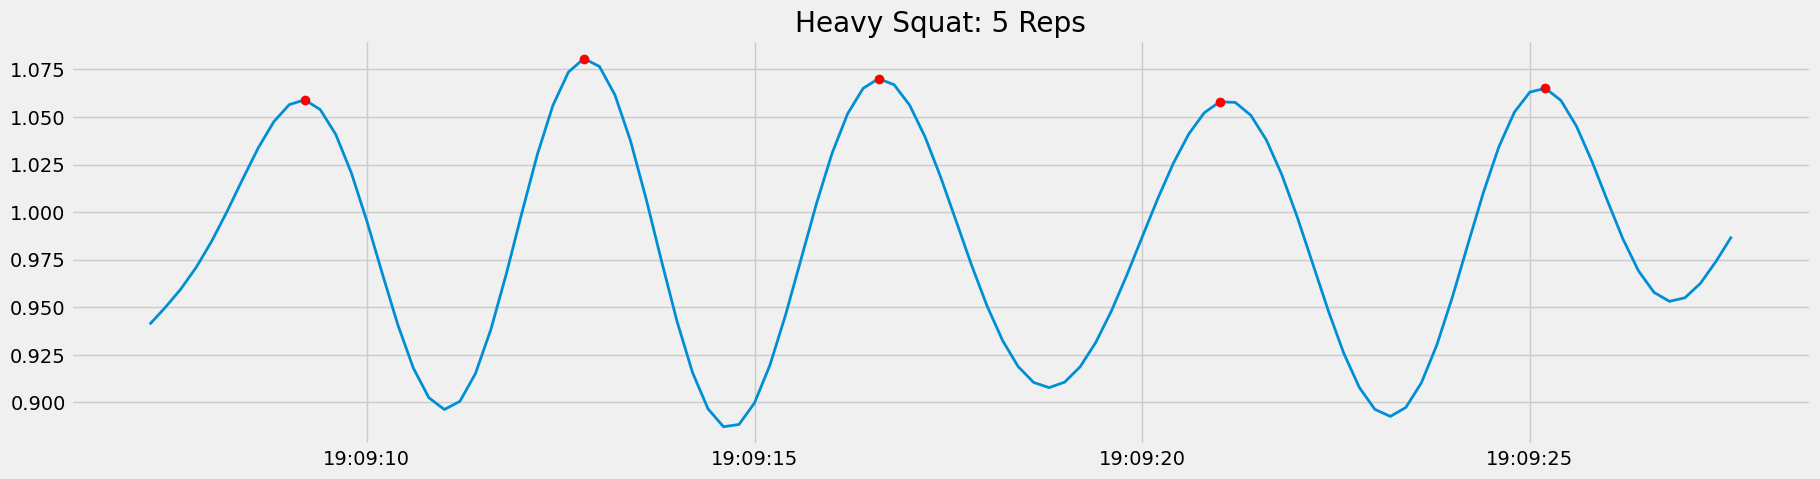

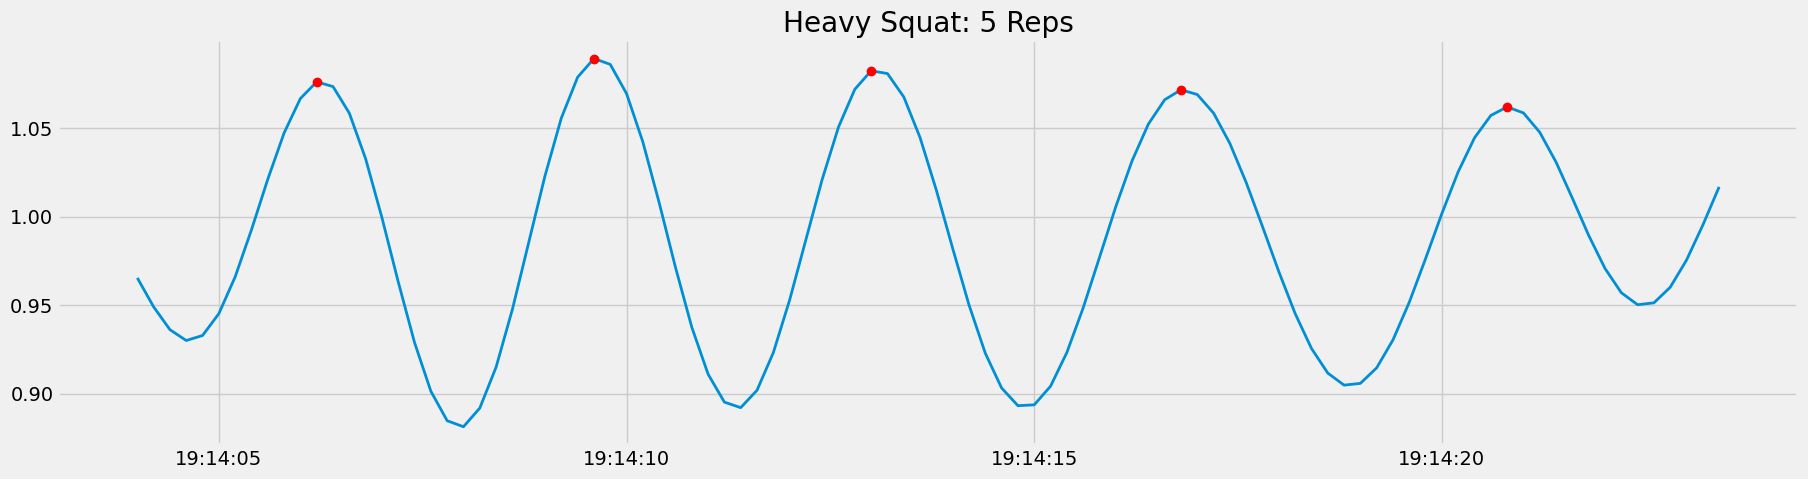

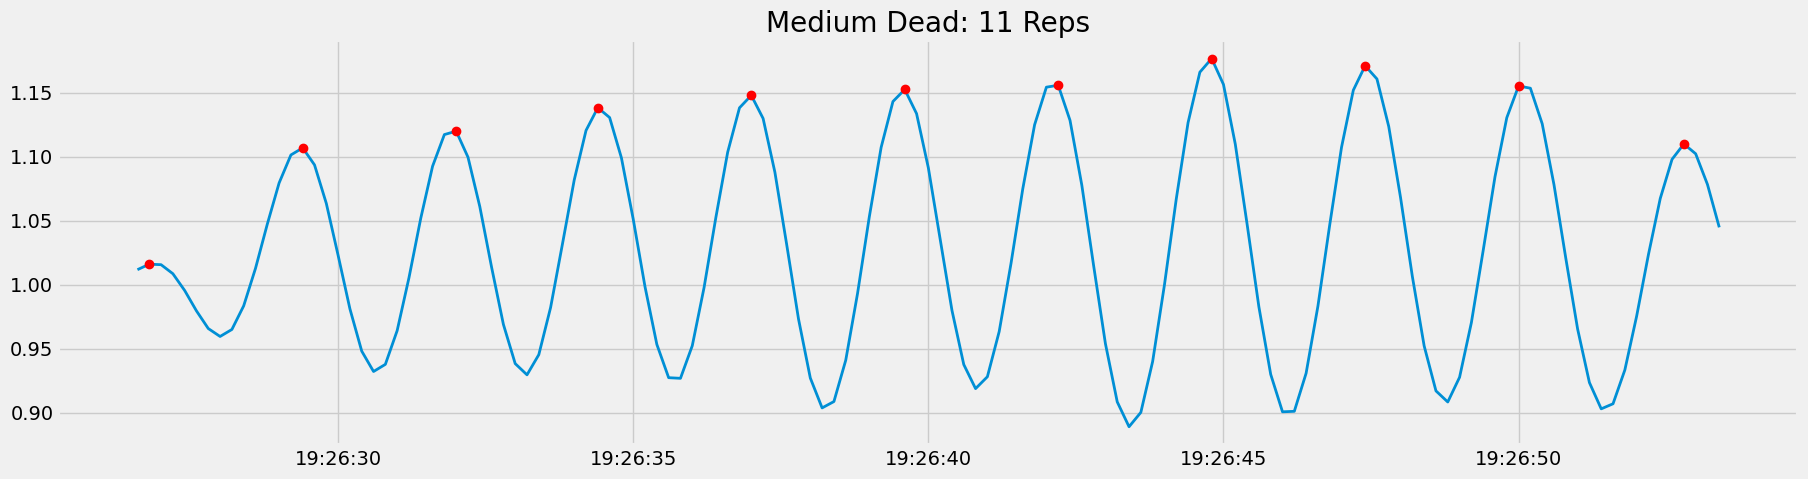

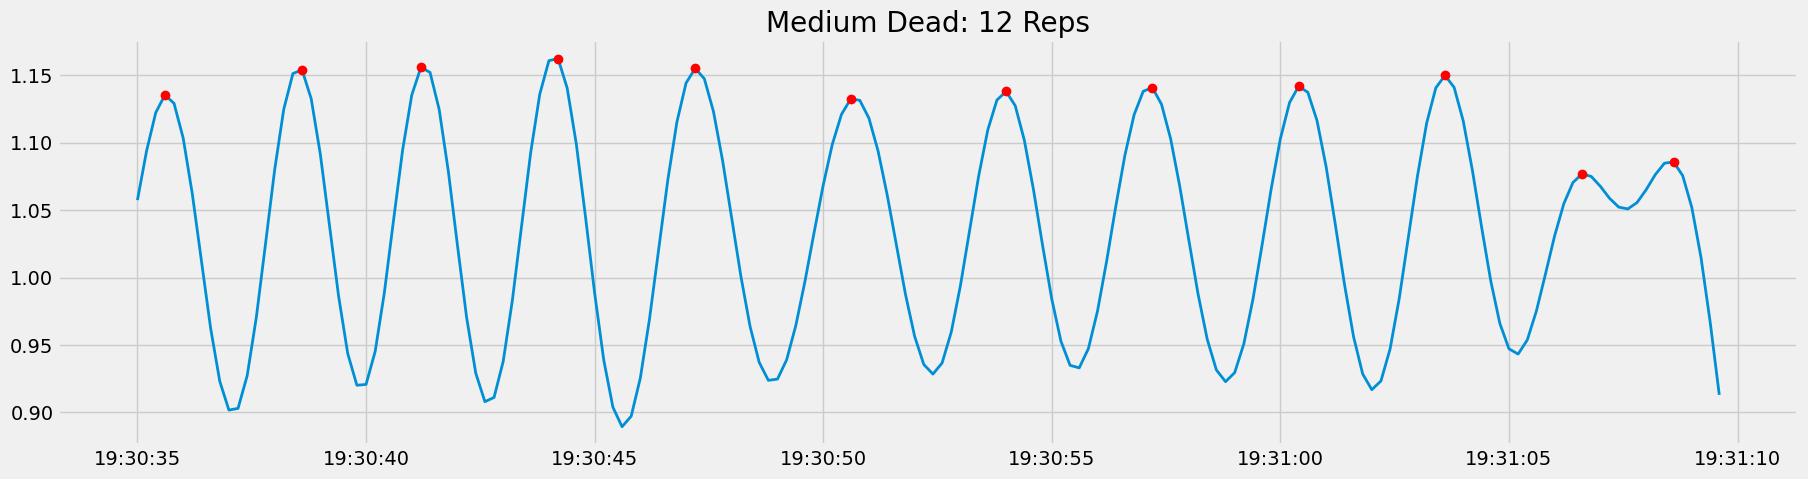

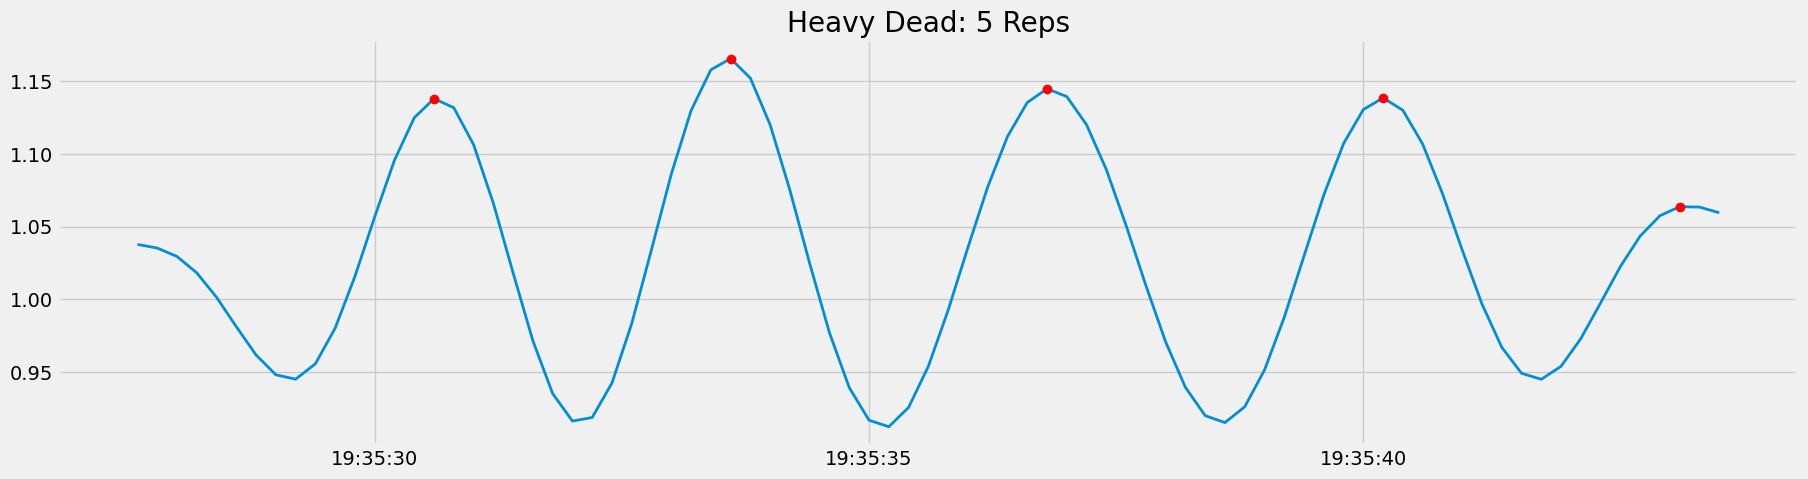

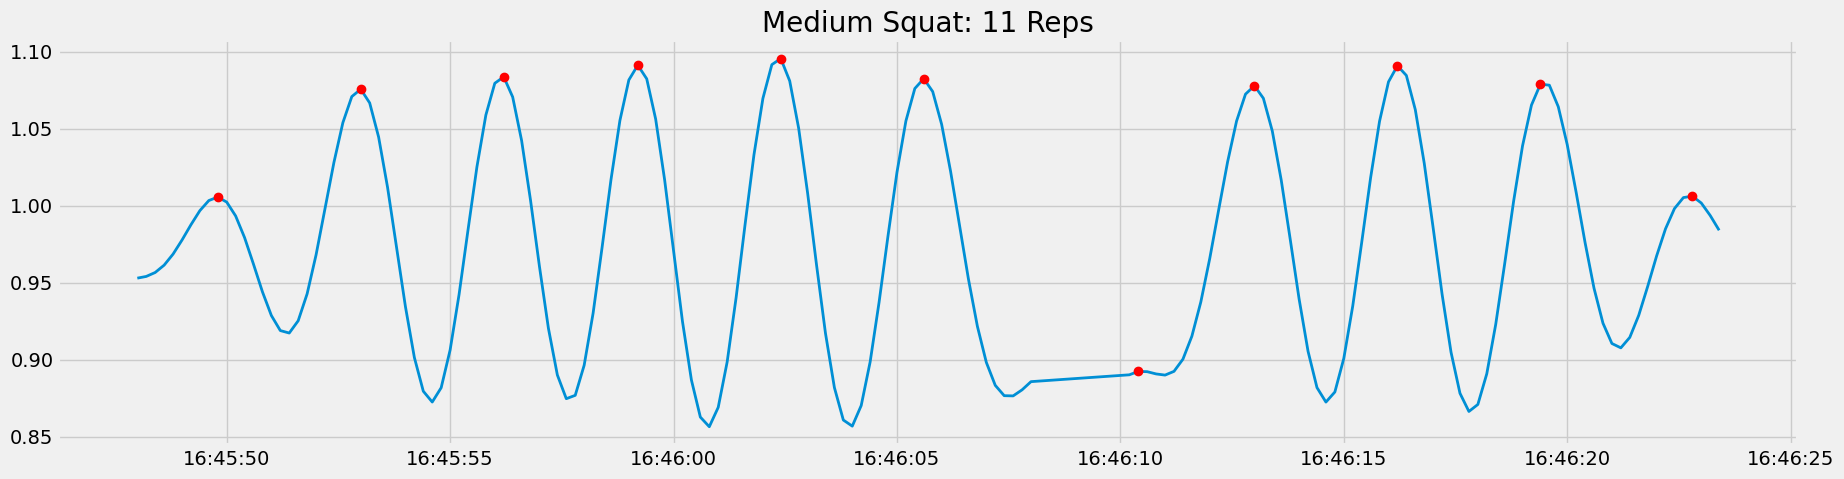

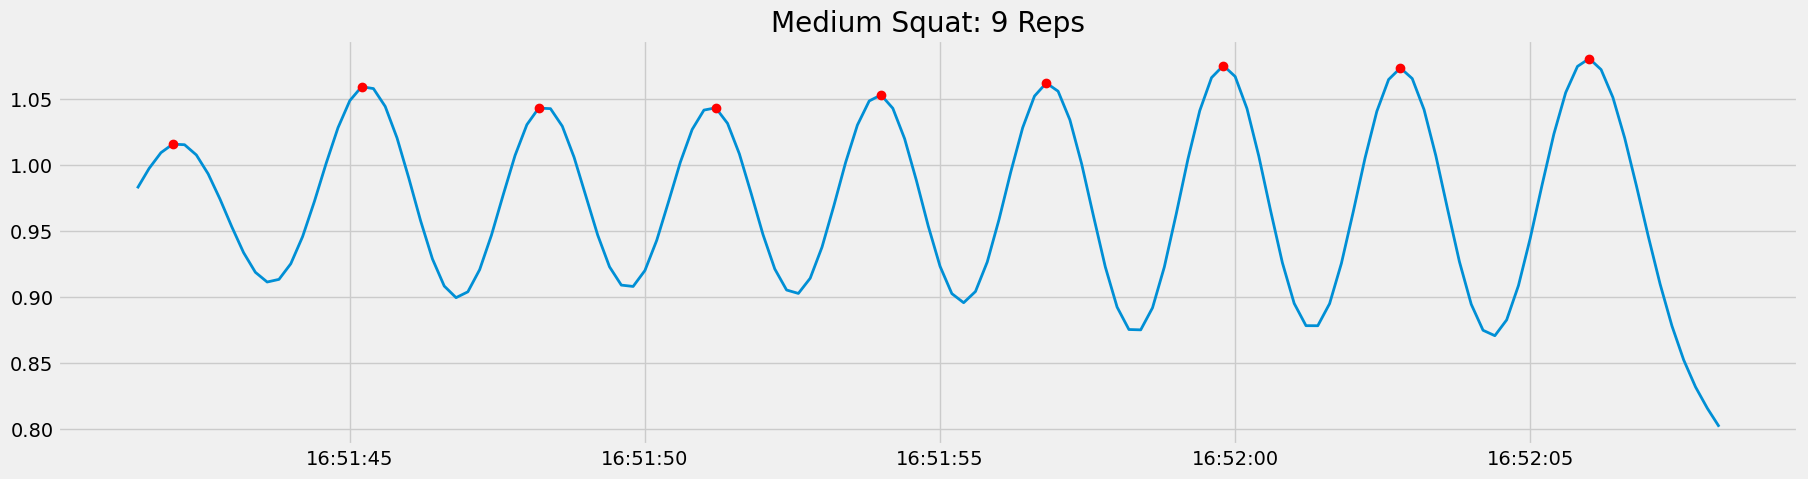

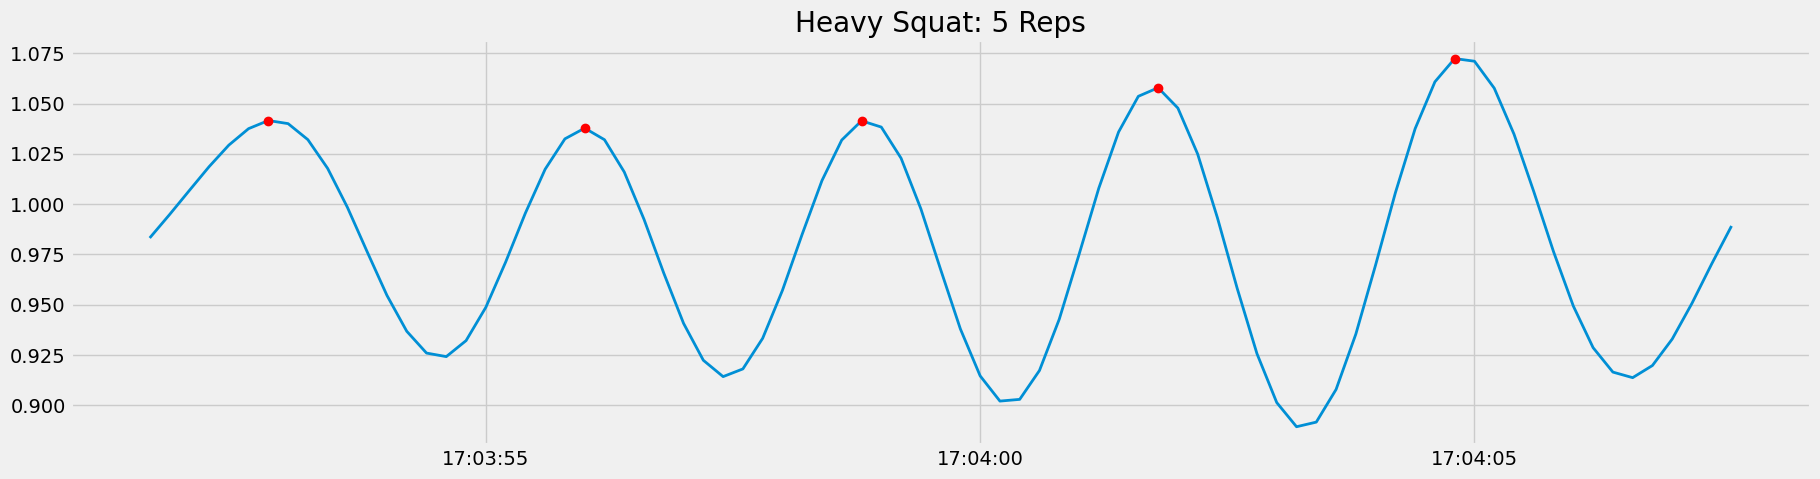

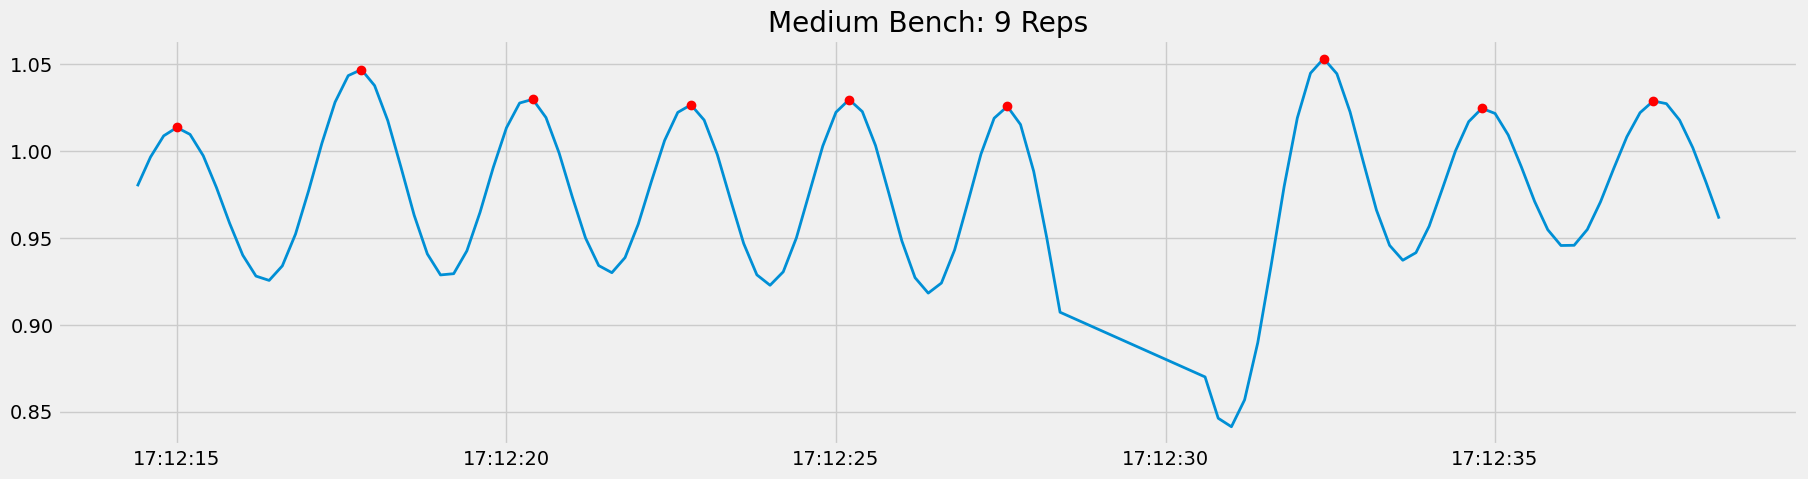

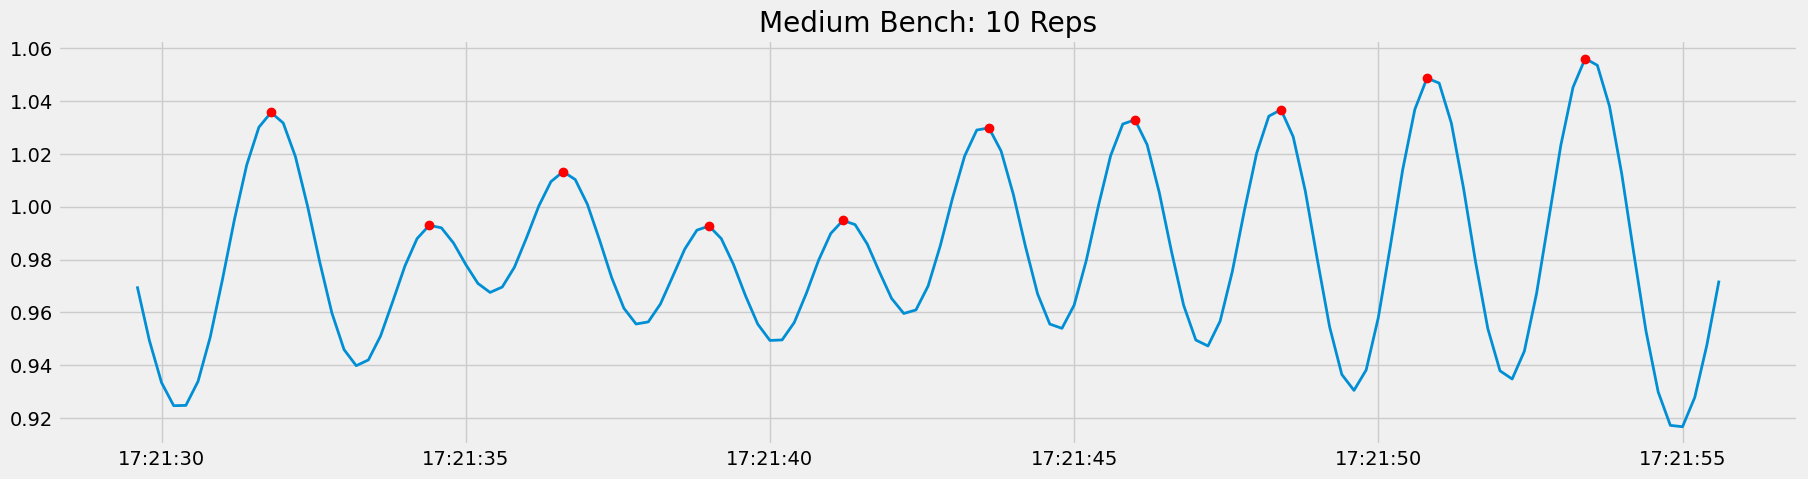

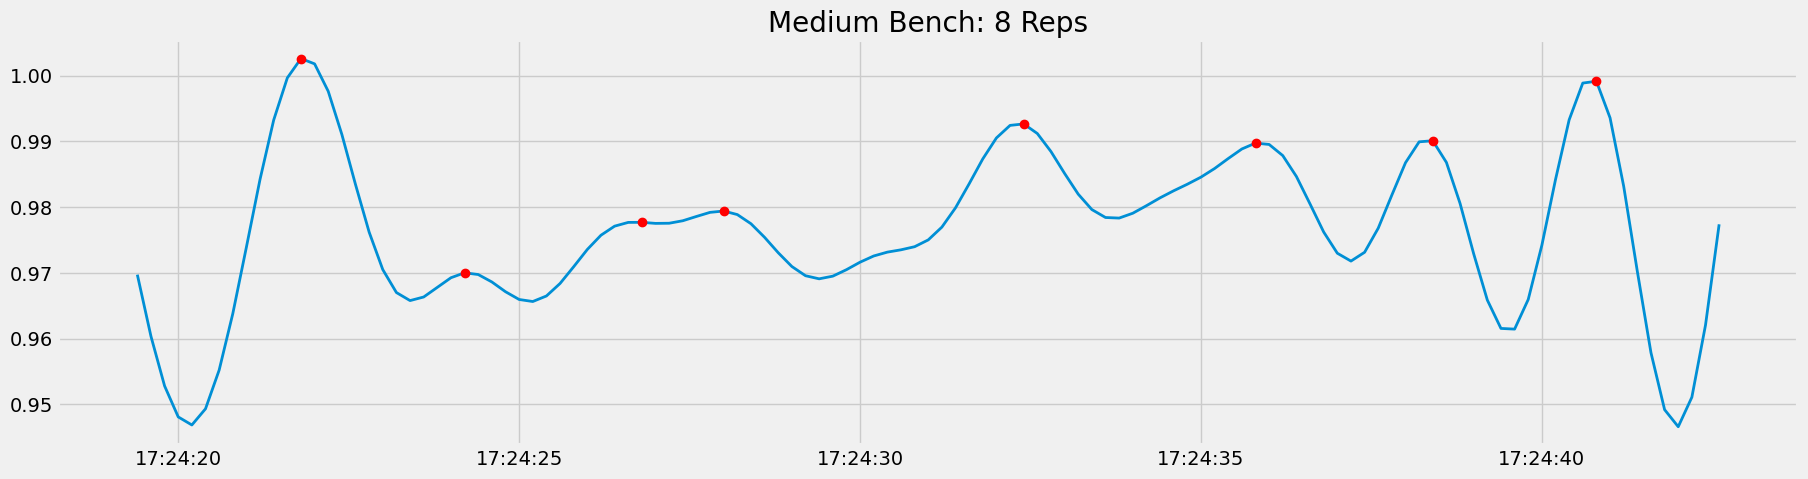

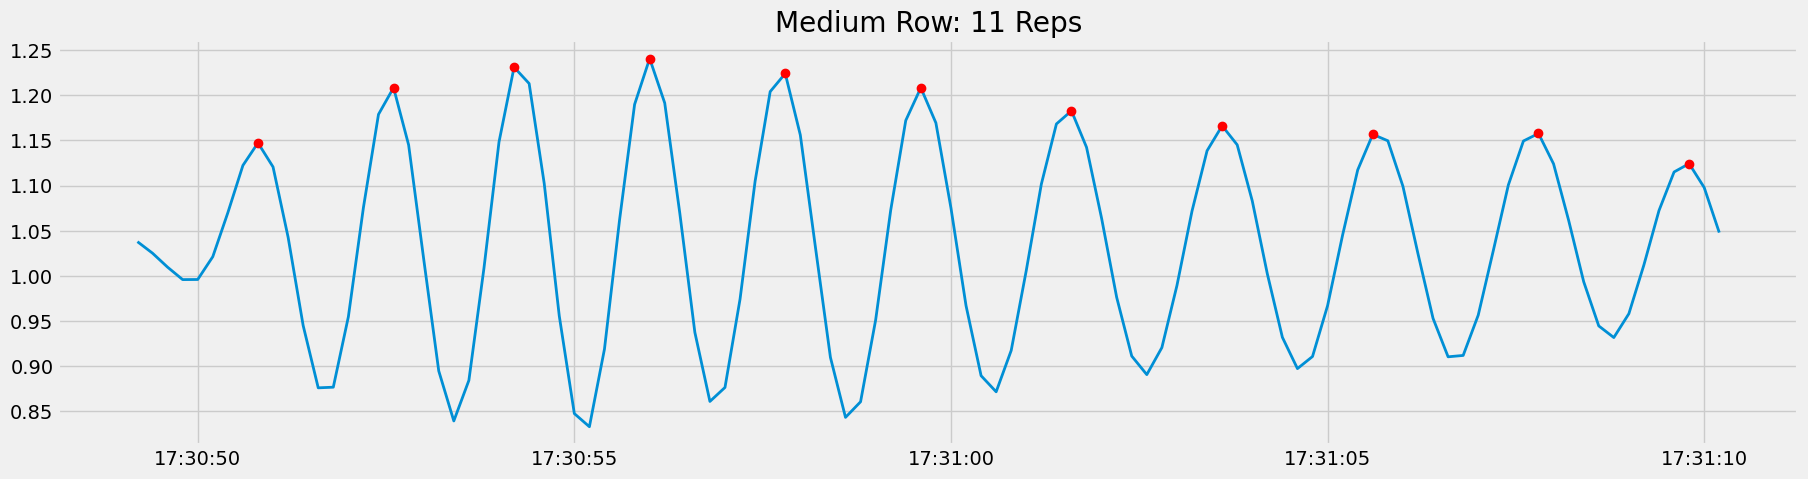

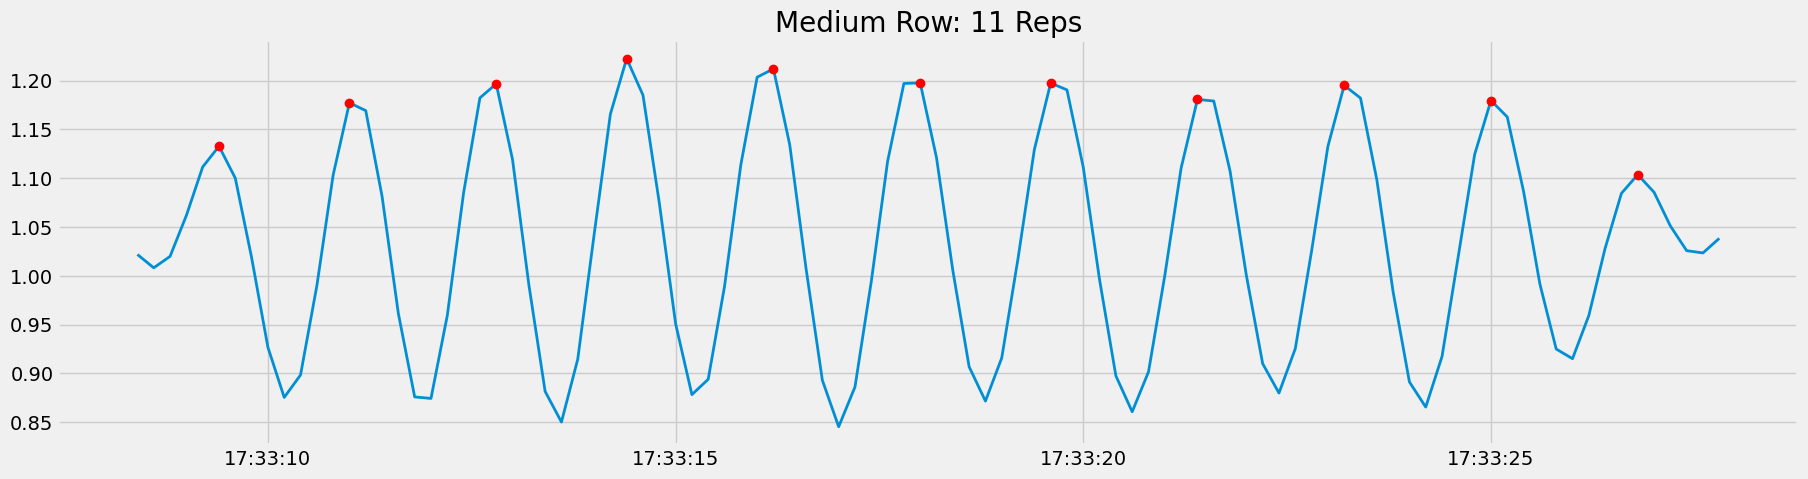

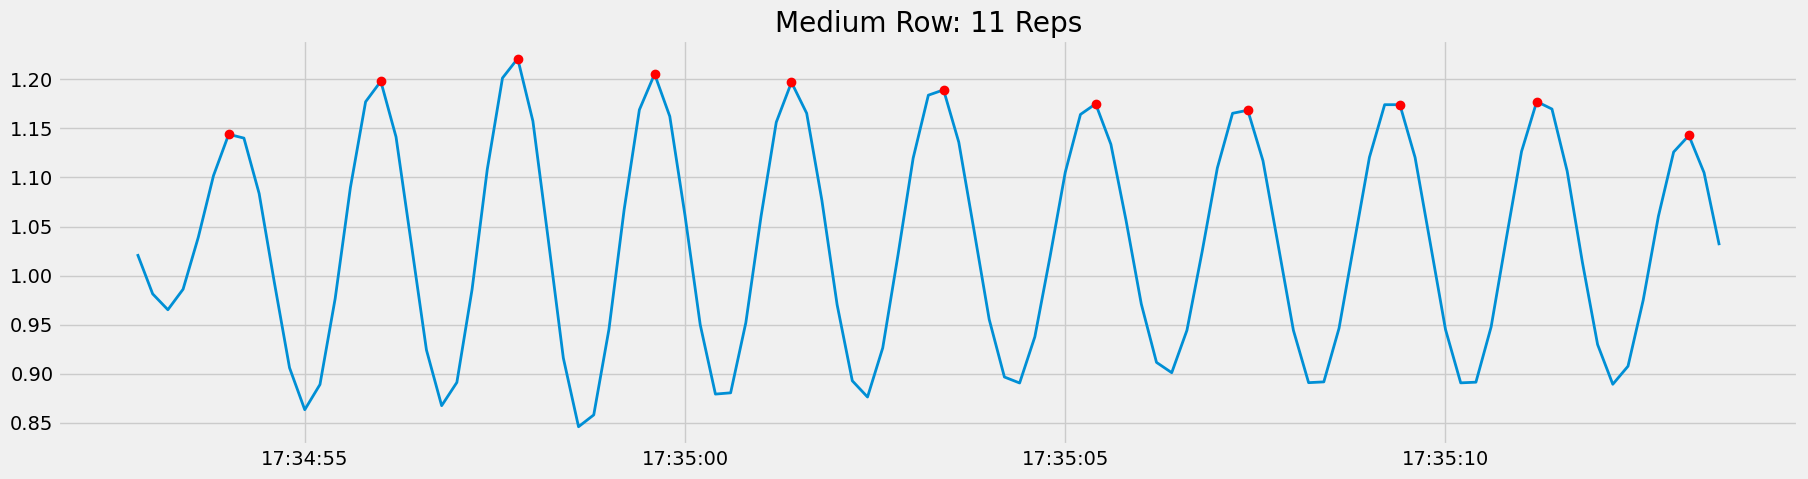

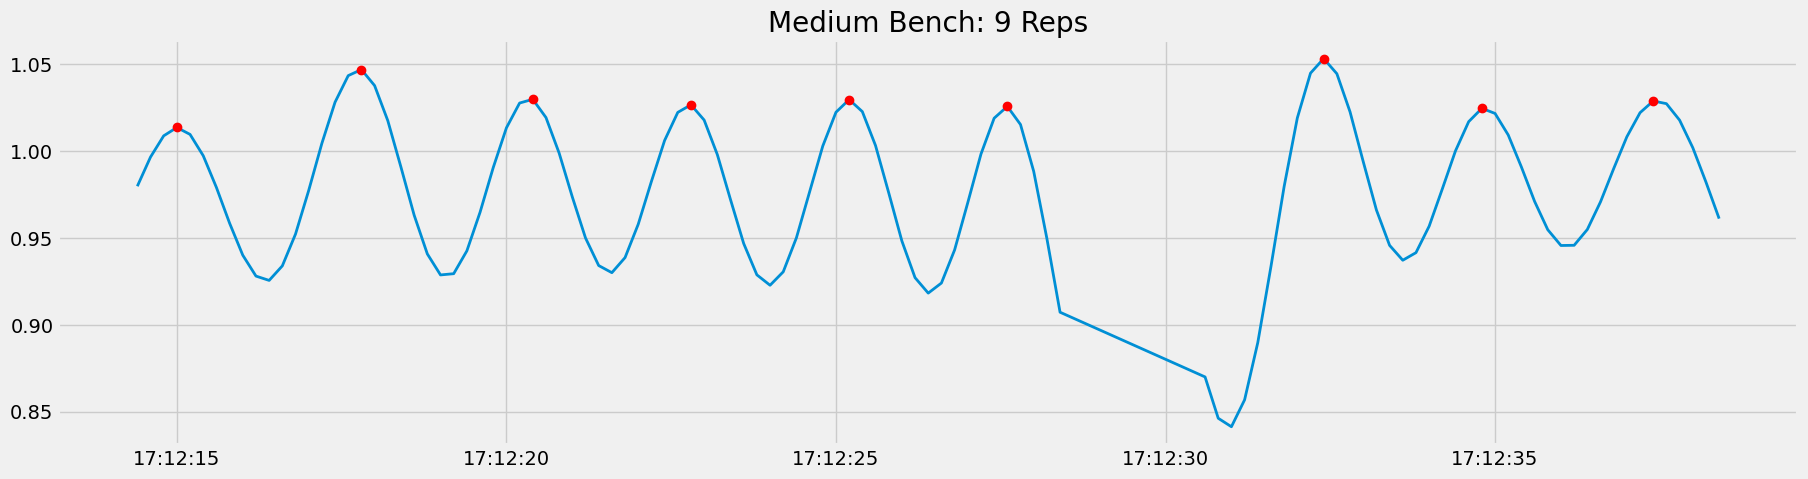

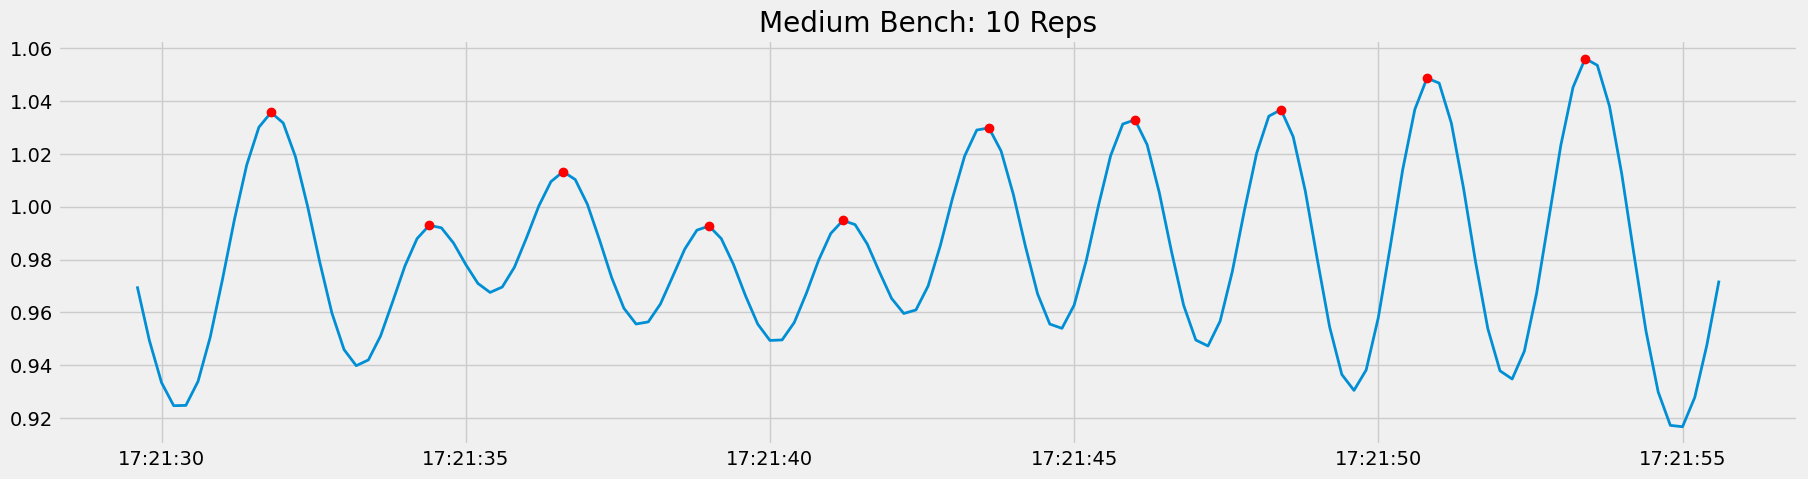

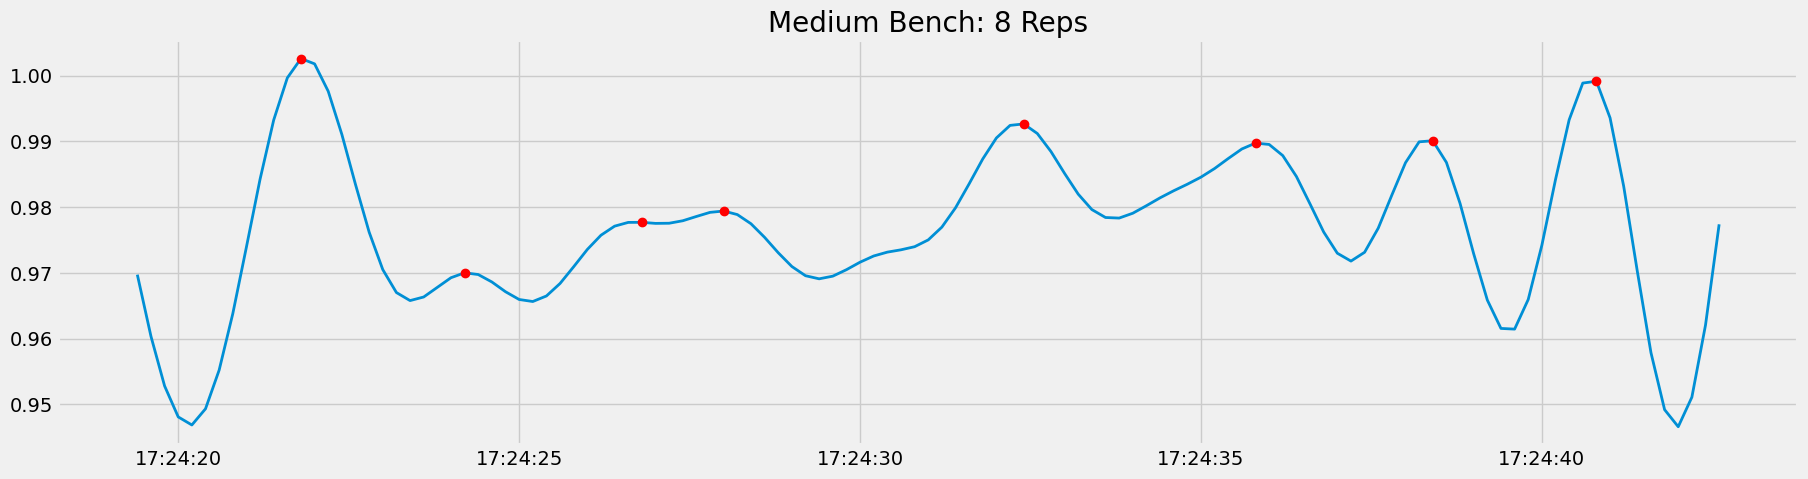

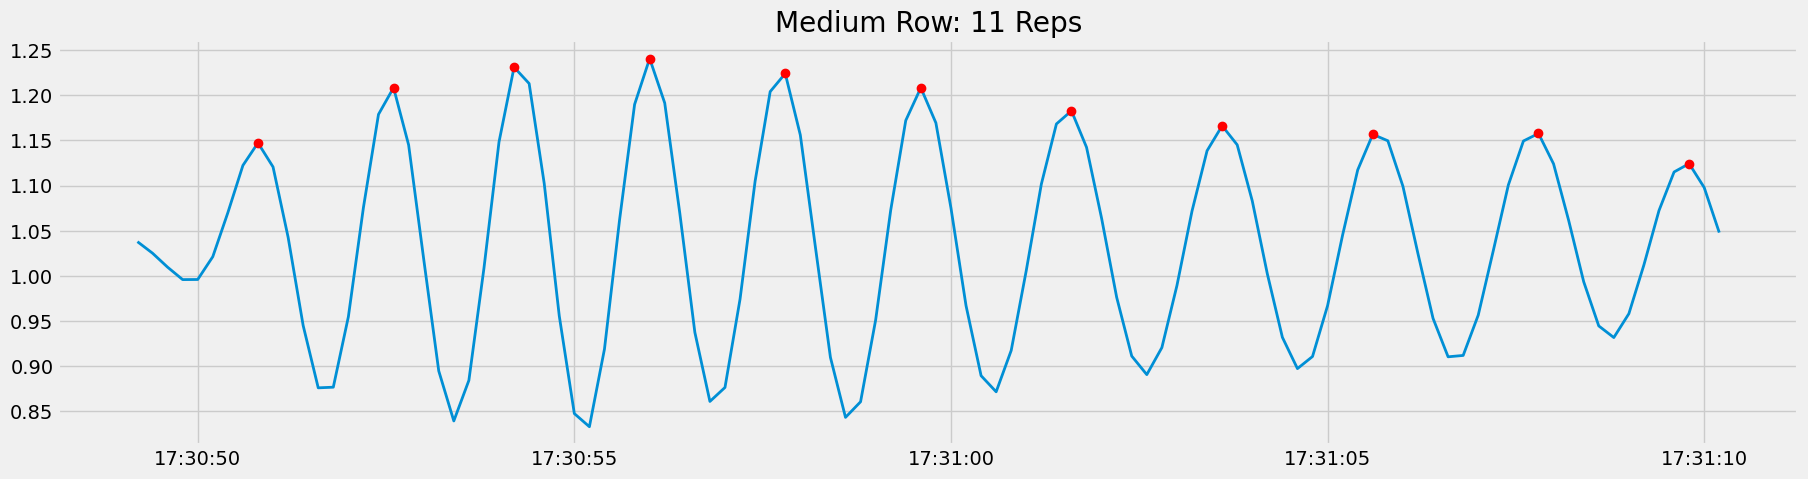

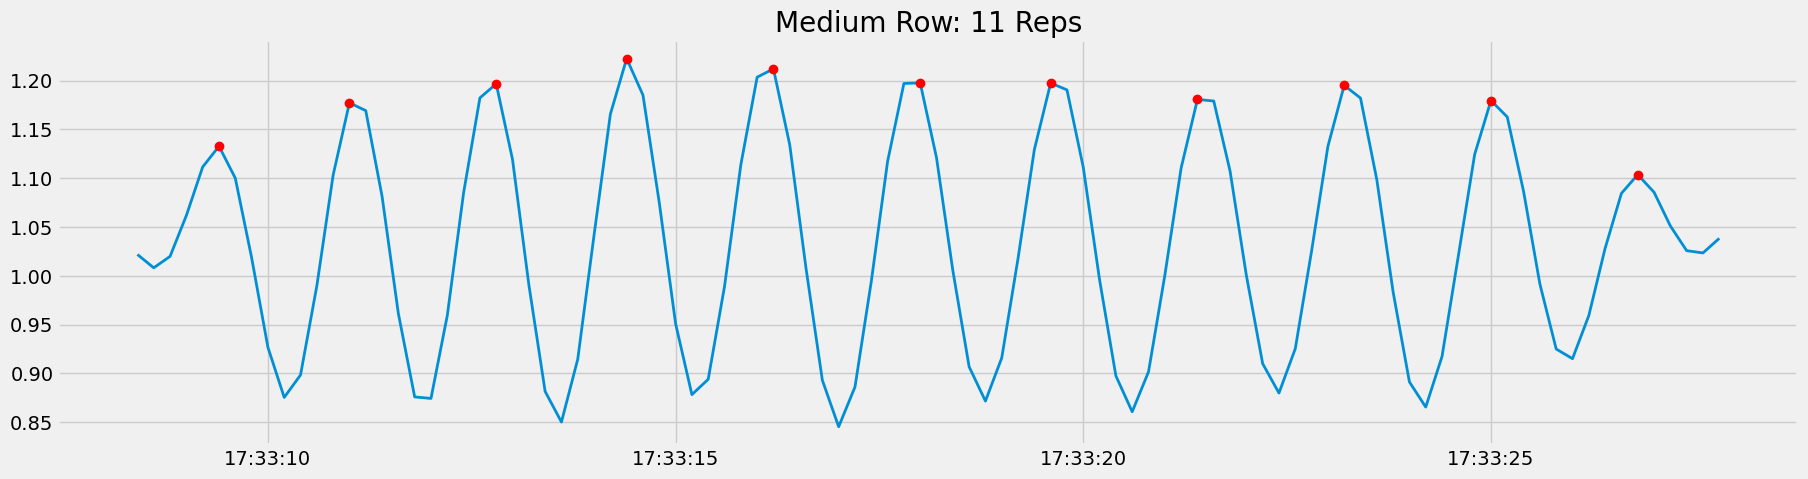

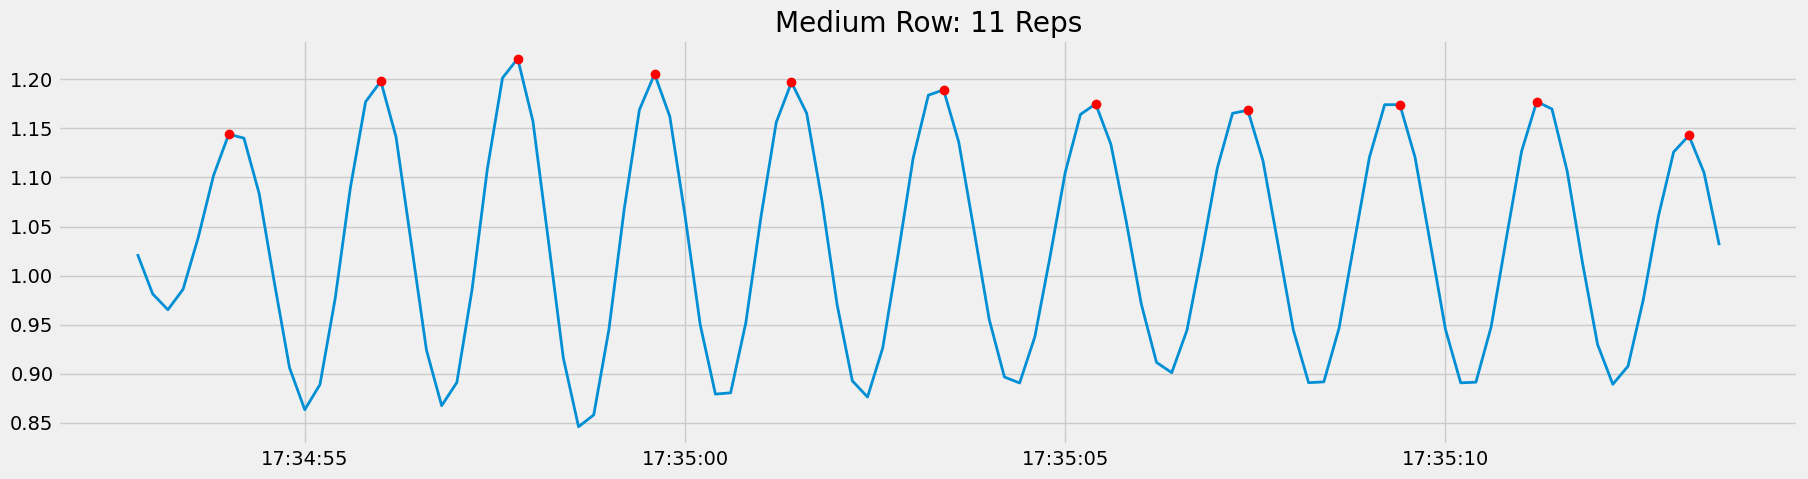

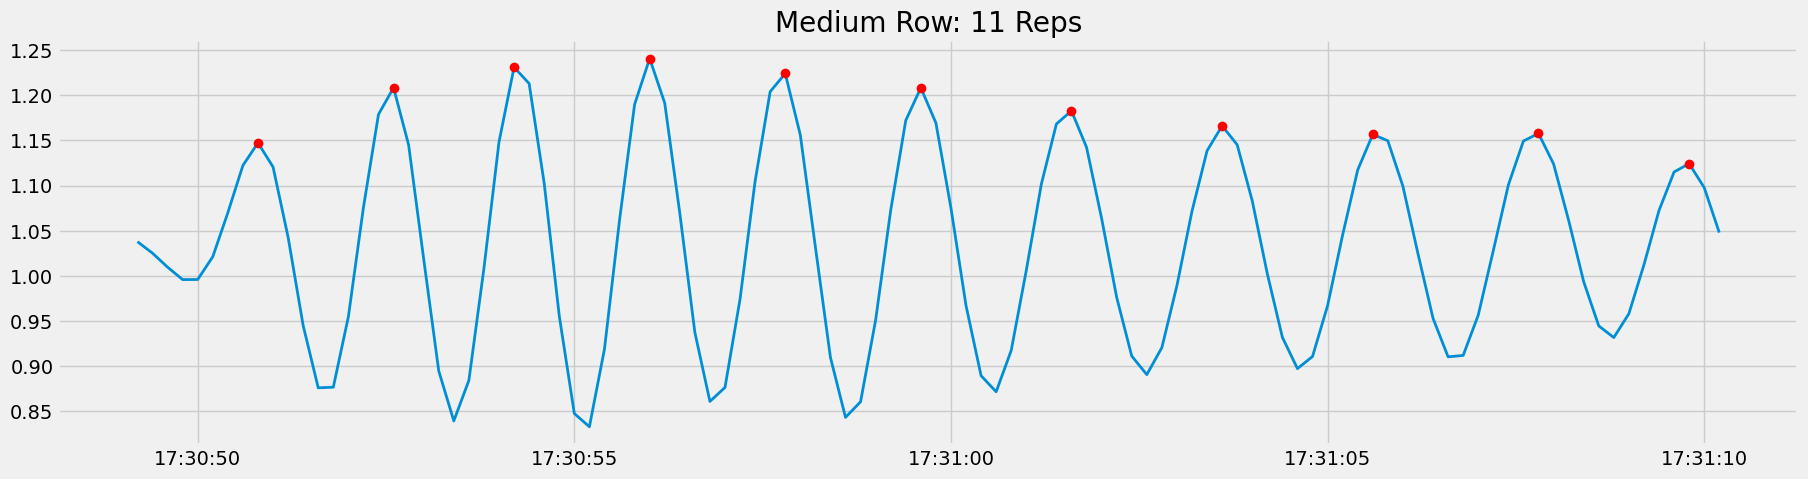

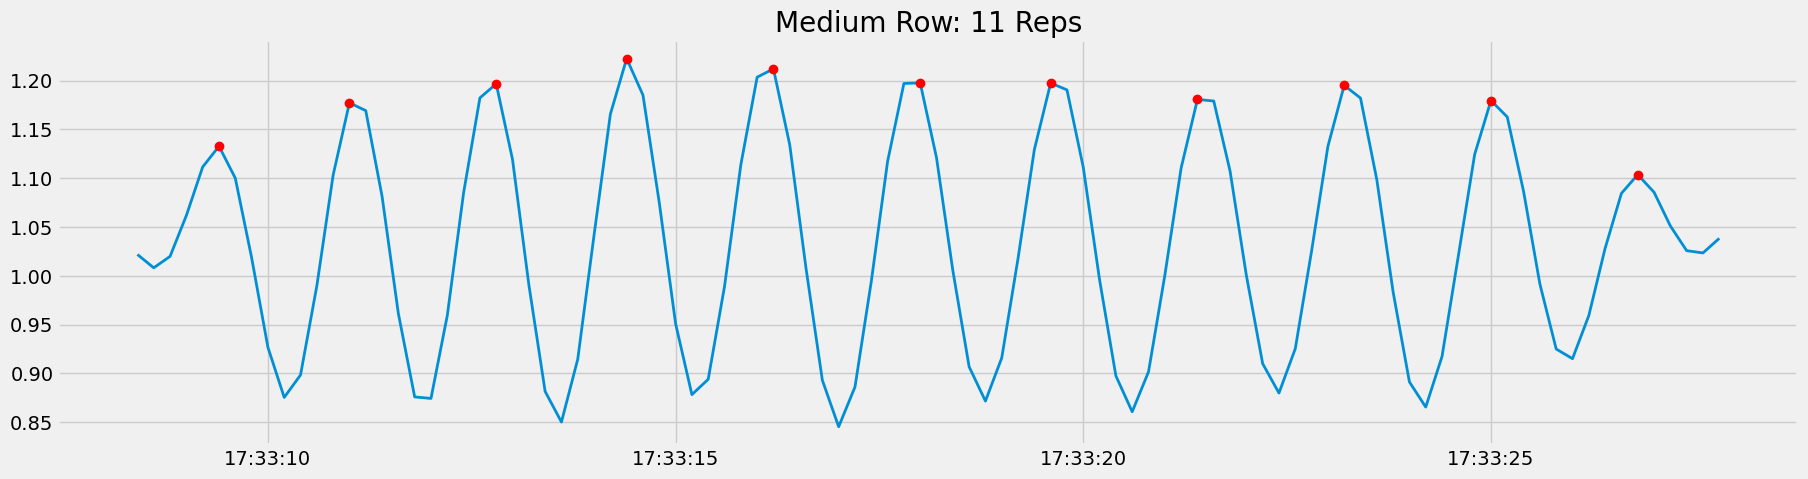

In [36]:
df['reps'] = df['category'].apply(lambda x: 5 if x == 'heavy' else 10)
rep_df = df.groupby(['label', 'category', 'set'])['reps'].max().reset_index()
rep_df['reps_pred'] = 0

for s in df['set'].unique():
    subset = df[df['set'] == s]
    
    column = 'acc_r'
    cutoff = 0.4
    
    if subset['label'].iloc[0] == 'squat' or subset['label'].iloc[0] == 'ohp':
        cutoff = 0.35
        
    if subset['label'].iloc[0] == 'row':
        cutoff = 0.65
        col = 'gyr_x'
        
    reps = count_repetations(subset, cutoff = cutoff, column = column)
    
    rep_df.loc[rep_df['set'] == s, 'reps_pred'] = reps

In [37]:
rep_df

label category  set  reps  reps_pred
0   bench    heavy    1     5          5
1   bench    heavy    2     5          4
2   bench    heavy    3     5          5
3   bench    heavy    4     5          5
4   bench    heavy   30     5          5
..    ...      ...  ...   ...        ...
80  squat   medium   28    10          8
81  squat   medium   29    10          8
82  squat   medium   38    10          7
83  squat   medium   63    10         11
84  squat   medium   64    10          9

[85 rows x 5 columns]

In [42]:
rep_df['reps_pred'].sort_values().unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [44]:
rep_df['reps_pred'].value_counts()

5     30
11    16
4     11
6     10
8      5
10     4
9      3
12     2
3      2
7      2
Name: reps_pred, dtype: int64

---

### Evaluate the results

In [38]:
error = mean_absolute_error(rep_df['reps'], rep_df['reps_pred']).round(2)

error

1.02

C:\Users\darsh\AppData\Local\Temp\ipykernel_19024\2889190412.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rep_df.groupby(['label', 'category'])['reps', 'reps_pred'].mean().plot.bar()


<AxesSubplot: xlabel='label,category'>

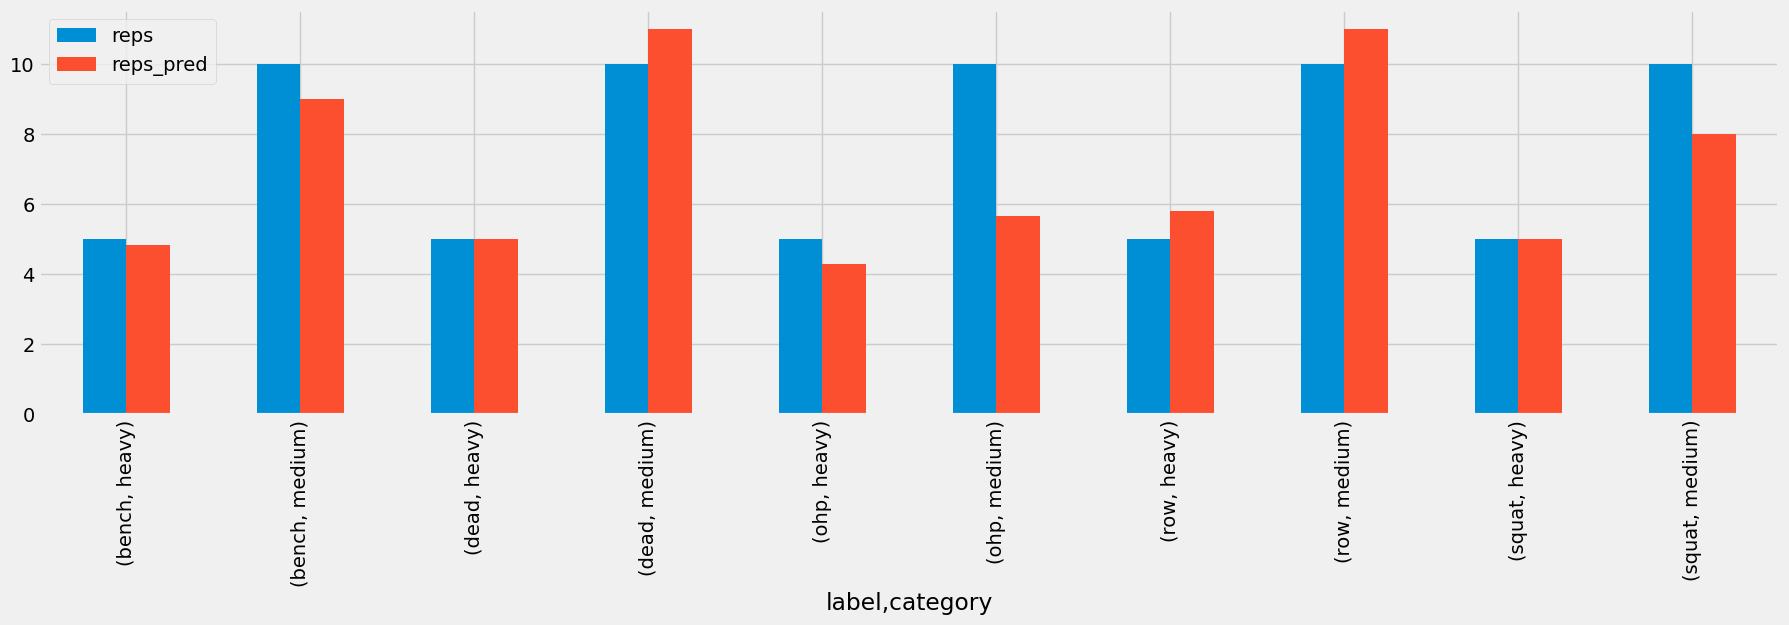

In [39]:
rep_df.groupby(['label', 'category'])['reps', 'reps_pred'].mean().plot.bar()

---